## EDA And Sensor Selection

### Work flow

1. Read in sensor and pull associated network
2. Graphical analysis of system
3. Get sensor data and analyse for completeness etc
4. Select sensors for study
5. Output OSM network of road network and associated sensors



In [1]:
# Import modules

import pandas as pd
import osmnx as ox
import numpy as np
import networkx as nx
import shapely
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import random
import mysql.connector
import csv
import heapq
from helper_functions import traversal_time, haversine_distance, test_stationarity, get_ts, analyse_time_series_of_sensor
from matplotlib import pyplot as plt

/tmp/ipykernel_428734/3338997694.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Get sensors
sensors = pd.read_csv('Data/midas_sensor_locations.csv')

#Get network for area just for pimary roads etc
cf = '["highway"~"motorway|motorway_link|primary|trunk"]'
G = ox.graph_from_place('Kent, United Kingdom', network_type='drive', custom_filter=cf, simplify=True)

edge_attributes = ox.graph_to_gdfs(G, nodes=True)[1]

#Tidy Network
#Where there is multiple road types select 1 (at random)
road_types = []
for i in list(edge_attributes['highway']):
    if isinstance(i, str): 
        road_types.append(i)
    else:
        road_types.append(i[0])
        
edge_attributes['highway'] = road_types

#Get Dict of road type to speed

#For edges with missing speed impute using mode
road_type_speed_limit = {}
for type in list(edge_attributes['highway'].value_counts().index):
    road_type_speed_limit[type] = edge_attributes[edge_attributes['highway'] == type]['maxspeed'].mode().values[0]


#Where speed missing or multuple, take from dict
speed = []
for i,r in edge_attributes.iterrows():
    #String case
    if isinstance(r['maxspeed'], str):
        speed.append(int("".join(filter(str.isdigit, r['maxspeed']))))
    #List case
    else:
        speed.append(int("".join(filter(str.isdigit, road_type_speed_limit[r['highway']]))))
        
edge_attributes['speed'] = speed

#Add travesal time to graph
for i,r in edge_attributes.iterrows():
    G[i[0]][i[1]][i[2]]['traversal_cost'] = traversal_time(r['length'],r['speed'])
    
node_attributes, edge_attributes = ox.graph_to_gdfs(G, nodes=True)
#Get edge centroids
edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y
#Add edge index
edge_attributes['edge_index'] = range(len(edge_attributes))
#Get boundary
graph_boundary=shapely.geometry.box(edge_attributes.geometry.total_bounds[0],edge_attributes.geometry.total_bounds[1],edge_attributes.geometry.total_bounds[2],edge_attributes.geometry.total_bounds[3])

#Read in sensors
sensor_points = []
for i,r in sensors.iterrows():
    sensor_points.append(Point([r['Longitude'],r['Latitude']]))
sensors['geometry'] = sensor_points

sensors_in_study = sensors[[graph_boundary.contains(point) for point in sensor_points]]

sensors_gdf = GeoDataFrame(sensors_in_study, crs="EPSG:4326", geometry=sensors_in_study['geometry'])
sensors_gdf.to_file("Data/examples/sensor_locations.json", driver="GeoJSON")
sensor_nearest_edges = ox.distance.nearest_edges(G, list(sensors_in_study['Longitude']), list(sensors_in_study['Latitude']), interpolate=None, return_dist=False)

roads = []
direction = []
for i in list(sensors_in_study['site_ID']):
    roads.append(i.split('/')[0])
    direction.append(i[-1:])
sensors_in_study['Road'] = roads
sensors_in_study['Direction'] = direction

/tmp/ipykernel_428734/2996697492.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/tmp/ipykernel_428734/2996697492.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y
/tmp/ipykernel_428734/2996697492.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['Road'] = roads
/tmp/ipykernel_428734/2996697492.py:72: SettingWi

In [3]:
#Set up cursor object to query time-series database
host = "localhost"
user = "chris"
password = "password"
database = "midas"

# Establish a database connection
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor(buffered=True)

#### General Data Pre-Processing

In [4]:
# Associate each sensor site to network
sensor_nodes = ox.distance.nearest_nodes(G, list(sensors_in_study['Longitude']), list(sensors_in_study['Latitude']), return_dist=False)
sensors_in_study['nearest node'] = sensor_nodes

# General data pre-processing
# Get location of Dover

dover = Point(1.313484253539137,51.123268155847605)
dover_node = ox.distance.nearest_nodes(G, dover.x, dover.y, return_dist=False)

# For each sensor
    # Compute shortest path
    # Compute Haversine distance

distances = []
sites_not_reachable = []

for i,r in sensors_in_study.iterrows():
    dist_append = {}
    dist_append['site ID'] = r['site_ID']
    try:
        dist_append['sp length'] = min(nx.dijkstra_path_length(G, r['nearest node'], dover_node, weight='length'),nx.dijkstra_path_length(G, dover_node, r['nearest node'], weight='length'))
        dist_append['sp traversal'] = min(nx.dijkstra_path_length(G, r['nearest node'], dover_node, weight='traversal_cost'),nx.dijkstra_path_length(G, dover_node, r['nearest node'], weight='traversal_cost'))
        dist_append['dist haversine'] = haversine_distance(dover,r['geometry'])
        distances.append(dist_append)
    except:
        sites_not_reachable.append(r['site_ID'])
    
    
distance_df = pd.DataFrame(distances)
distance_df.to_csv('Data/sensors_with_distances.csv')

/tmp/ipykernel_428734/2189329125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['nearest node'] = sensor_nodes


## Analysis Parameters

In [5]:
start_date = '2022-01-01'
end_date = '2022-12-31 23:45:00'

month_label = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}

## Route 1 Analysis - M20 / A20

### This route follows Maidstone -> Ashford -> Folkstone -> Dover
### Many sensors are densely situated outside Maidstone, otherwise sensors are fairly sparsely situated

#### Data prep for route analysis

In [6]:
#Read in sensors for A20 route

with open('Data/route1_a20.csv', newline='') as f:
    a20_sensors = f.read().splitlines()
print(a20_sensors)

# Create a datetime index with 15-minute frequency
datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')

a20_ts_data_raw = pd.DataFrame(index = datetime_index, columns = a20_sensors)
a20_ts_data_int = pd.DataFrame(index = datetime_index, columns = a20_sensors)

for site in a20_sensors:
    ts, ts_all = get_ts(site,start_date,end_date,cursor)
    a20_ts_data_raw[site] = ts_all['All Lanes']
    a20_ts_data_int[site] = ts_all['All Lanes_interpolated']
    

uk_bank_holidays_2022 = [
    '2022-01-01',  # New Year's Day (substitute day)
    '2022-04-15',  # Good Friday
    '2022-04-18',  # Easter Monday
    '2022-05-02',  # Early May Bank Holiday
    '2022-06-02',  # Spring Bank Holiday
    '2022-06-03',  # Platinum Jubilee Bank Holiday
    '2022-08-29',  # Summer Bank Holiday
    '2022-12-25',  # Christmas Day
    '2022-12-26',  # Boxing Day (substitute day)
]

day_lookup = pd.DataFrame(index = datetime_index)
day_lookup['bh'] = day_lookup.index.isin(pd.to_datetime(uk_bank_holidays_2022))

weekdays = []
weekends = []
for i,r in day_lookup.iterrows():
    if r['bh']:
        weekdays.append(False)
        weekends.append(False)        
    elif i.weekday() < 5:
        weekdays.append(True)
        weekends.append(False)
    else:
        weekdays.append(False)
        weekends.append(True)
        
day_lookup['wd'] = weekdays
day_lookup['we'] = weekends

['5892/1', '5889/1', 'A20/7113A', 'M20/7095A', 'M20/7076A', 'M20/7018A', 'M20/6913A', 'M20/6905A', 'M20/6868A', 'M20/6645A', 'M20/6590A', 'M20/6582A', 'M20/6576A', 'M20/6572A', 'M20/6570A', 'M20/6568A1', 'M20/6552A1', 'M20/6545A', 'M20/6547A1', 'M20/6540A', 'M20/6534A', 'M20/6538A', 'M20/6531A', 'M20/6526A', 'M20/6518A', 'M20/6520A', 'M20/6523A', 'M20/6514A', 'M20/6517A', 'M20/6506A', 'M20/6511A', 'M20/6501A', 'M20/6498A', 'M20/6481A', 'M20/6484A', 'M20/6487A', 'M20/6491A', 'M20/6494A', 'M20/6477A', 'M20/6460A', 'M20/6465A', 'M20/6468A', 'M20/6472A', 'M20/6476A', 'M20/6454A', 'M20/6404A']


/tmp/ipykernel_428734/1494839294.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:103: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perfo

In [287]:
dover = Point(1.313484253539137,51.123268155847605)
dover_node = ox.distance.nearest_nodes(G, dover.x, dover.y, return_dist=False)
sensor_level_data_list = []
route = 'route1'
sensor_num = 1

# Sensor to Sensor Matrix
s2s_time = np.zeros((len(a20_sensors),len(a20_sensors)))
s2s_corr_wd = np.zeros((len(a20_sensors),len(a20_sensors)))
s2s_corr_we = np.zeros((len(a20_sensors),len(a20_sensors)))
u_i = 0


for u in a20_sensors:
    
    sensor_level_append = {}
    sensor_level_append['sensor'] = u
    u_node = sensors_in_study[sensors_in_study['site_ID'] == u]['nearest node'].values[0]
    v_i = 0
    count_15 = 0
    count_30 = 0
    count_45 = 0
    count_60 = 0
    for v in a20_sensors:
        v_node = sensors_in_study[sensors_in_study['site_ID'] == v]['nearest node'].values[0]
        #SP
        travel_time = nx.dijkstra_path_length(G, u_node, v_node, weight='traversal_cost')
        #Correlation
        correlation_wd = np.corrcoef(a20_ts_data_int[u].loc[day_lookup[day_lookup['wd']].index],a20_ts_data_int[v].loc[day_lookup[day_lookup['wd']].index])
        correlation_we = np.corrcoef(a20_ts_data_int[u].loc[day_lookup[day_lookup['we']].index],a20_ts_data_int[v].loc[day_lookup[day_lookup['we']].index])
        #Append to matrix
        s2s_time[u_i,v_i] = travel_time
        s2s_corr_wd[u_i,v_i] = correlation_wd[0][1]
        s2s_corr_we[u_i,v_i] = correlation_we[0][1]
        
        if travel_time <= 15:
            count_15 += 1
        if travel_time <= 30:
            count_30 += 1
        if travel_time <= 45:
            count_45 += 1
        if travel_time <= 60:
            count_60 += 1
        v_i += 1
    
    sensor_level_append['Reachable 15'] = count_15
    sensor_level_append['Reachable 30'] = count_30
    sensor_level_append['Reachable 45'] = count_45
    sensor_level_append['Reachable 60'] = count_60
    
    #Dist to dover
    dist_to_dover = min(nx.dijkstra_path_length(G, u_node, dover_node, weight='traversal_cost'),nx.dijkstra_path_length(G, dover_node, u_node, weight='traversal_cost'))
    sensor_level_append['Time to Dover'] = dist_to_dover
    sensor_level_data_list.append(sensor_level_append)
    
    #Isocrone    
    
    #Get 15 min isochrone from sensor

    start_node = u_node
    max_travel_time = 15

    queue = [(0, start_node)]

    # Dictionary to store the cumulative travel time for each node
    travel_times = {node: float('inf') for node in G.nodes}
    travel_times[start_node] = 0

    while queue:
        current_time, current_node = heapq.heappop(queue)
        
        # Check if the current node has been reached within the allowed travel time
        if current_time > max_travel_time:
            print('Time over allowed traversal time')
            break
        
        for neighbor in G.neighbors(current_node):
            # Calculate the total travel time to the neighbor from the start node
            neighbor_time = current_time + G[current_node][neighbor][0]['traversal_cost']
            
            # Update the travel time if it's smaller than the current recorded time
            if neighbor_time < travel_times[neighbor]:
                travel_times[neighbor] = neighbor_time
                heapq.heappush(queue, (neighbor_time, neighbor))
                
    isocrone = node_attributes.loc[[node for node, time in travel_times.items() if time <= max_travel_time]]
    isocrone['travel time'] = isocrone.index.map(travel_times)

    isocrone_gdf = GeoDataFrame(isocrone, crs="EPSG:4326", geometry=isocrone['geometry'])
    isocrone_gdf.to_file("Data/route1/isochrone_{}_{}.json".format(route,sensor_num), driver="GeoJSON")
    
    sensor_num += 1
    u_i += 1
    
sensor_level_data = pd.DataFrame(sensor_level_data_list)
sensor_level_data = sensor_level_data.set_index('sensor')

/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time


### Analysis 1 - Data quality tests across all sensors

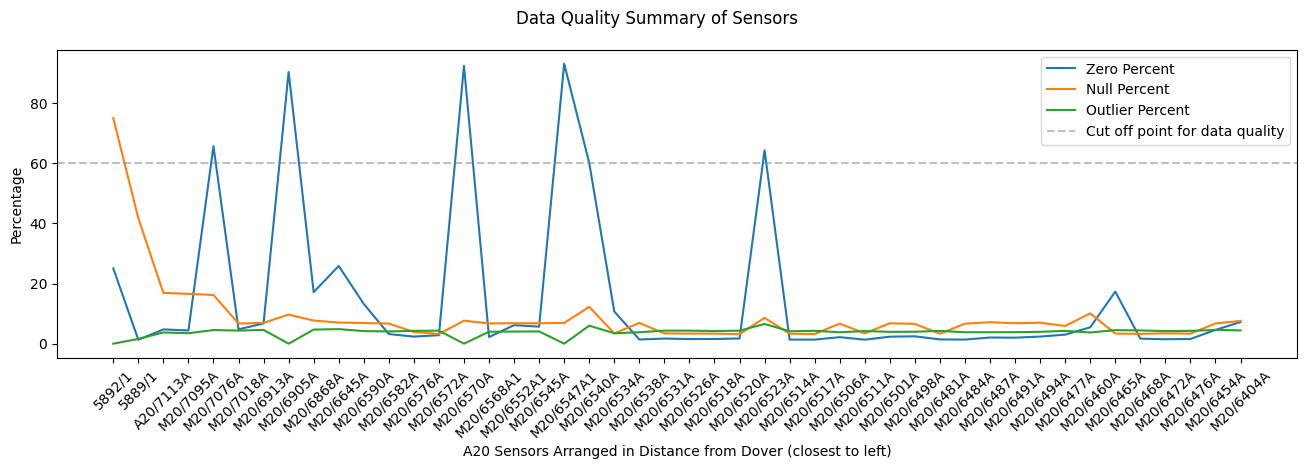

In [289]:
plot_quality_list = []

for col in a20_ts_data_raw.columns:
    sensor_data = a20_ts_data_raw[col]
    
    mean_value = sensor_data.mean()
    std_dev = sensor_data.std()

    plot_append = {}
    
    plot_append['Sensor'] = col
    plot_append['Zero Percent'] = ((sensor_data == 0).sum() / len(sensor_data)) * 100
    plot_append['Null Percent'] = (sensor_data.isnull().sum() / len(sensor_data)) * 100
    plot_append['Outlier Percent'] = (((sensor_data > mean_value + 2 * std_dev) | (sensor_data < mean_value - 2 * std_dev)).sum()) / len(sensor_data) * 100
    plot_quality_list.append(plot_append)

a20_sensor_quality = pd.DataFrame(plot_quality_list).set_index('Sensor')

# Sensor on x axis
# Percentage on y axis
# Three lines (missing, zeros, outliers)

fig, ax = plt.subplots(1,1, figsize = [16,4])
a20_sensor_quality.plot(ax = ax)
ax.set_xticks(range(len(list(a20_sensor_quality.index))),list(a20_sensor_quality.index), rotation=45)
ax.axhline(y=60, color='gray', linestyle='--', alpha=0.5, label = 'Cut off point for data quality')
ax.set_xlabel('A20 Sensors Arranged in Distance from Dover (closest to left)')
ax.set_ylabel('Percentage')
plt.suptitle('Data Quality Summary of Sensors')
plt.legend()
plt.show()

#### Key findings

- Data quality tends to improve further away from Dover
- Zero seems to imply sensor not working, but zero is also a valid reading. Potentially very confusing
    - Should we treat zeros as missing for purposes of data imutation?
- Sensor closest to Dover unusuable as virtually all data is either missing or zero
    - Remove any sensor with a null or zero rate above 60% - somewhat arbitrary but the plot seems to support this

In [290]:
#Add data quality flag

good_sensors = []

for i,r in a20_sensor_quality.iterrows():
    if (r['Zero Percent'] > 60) or (r['Null Percent'] > 60):
        good_sensors.append(False)
    else:
        good_sensors.append(True)

sensor_level_data['Data Quality Check'] = good_sensors

### Analysis 2 - Observe evoluation of traffic along road

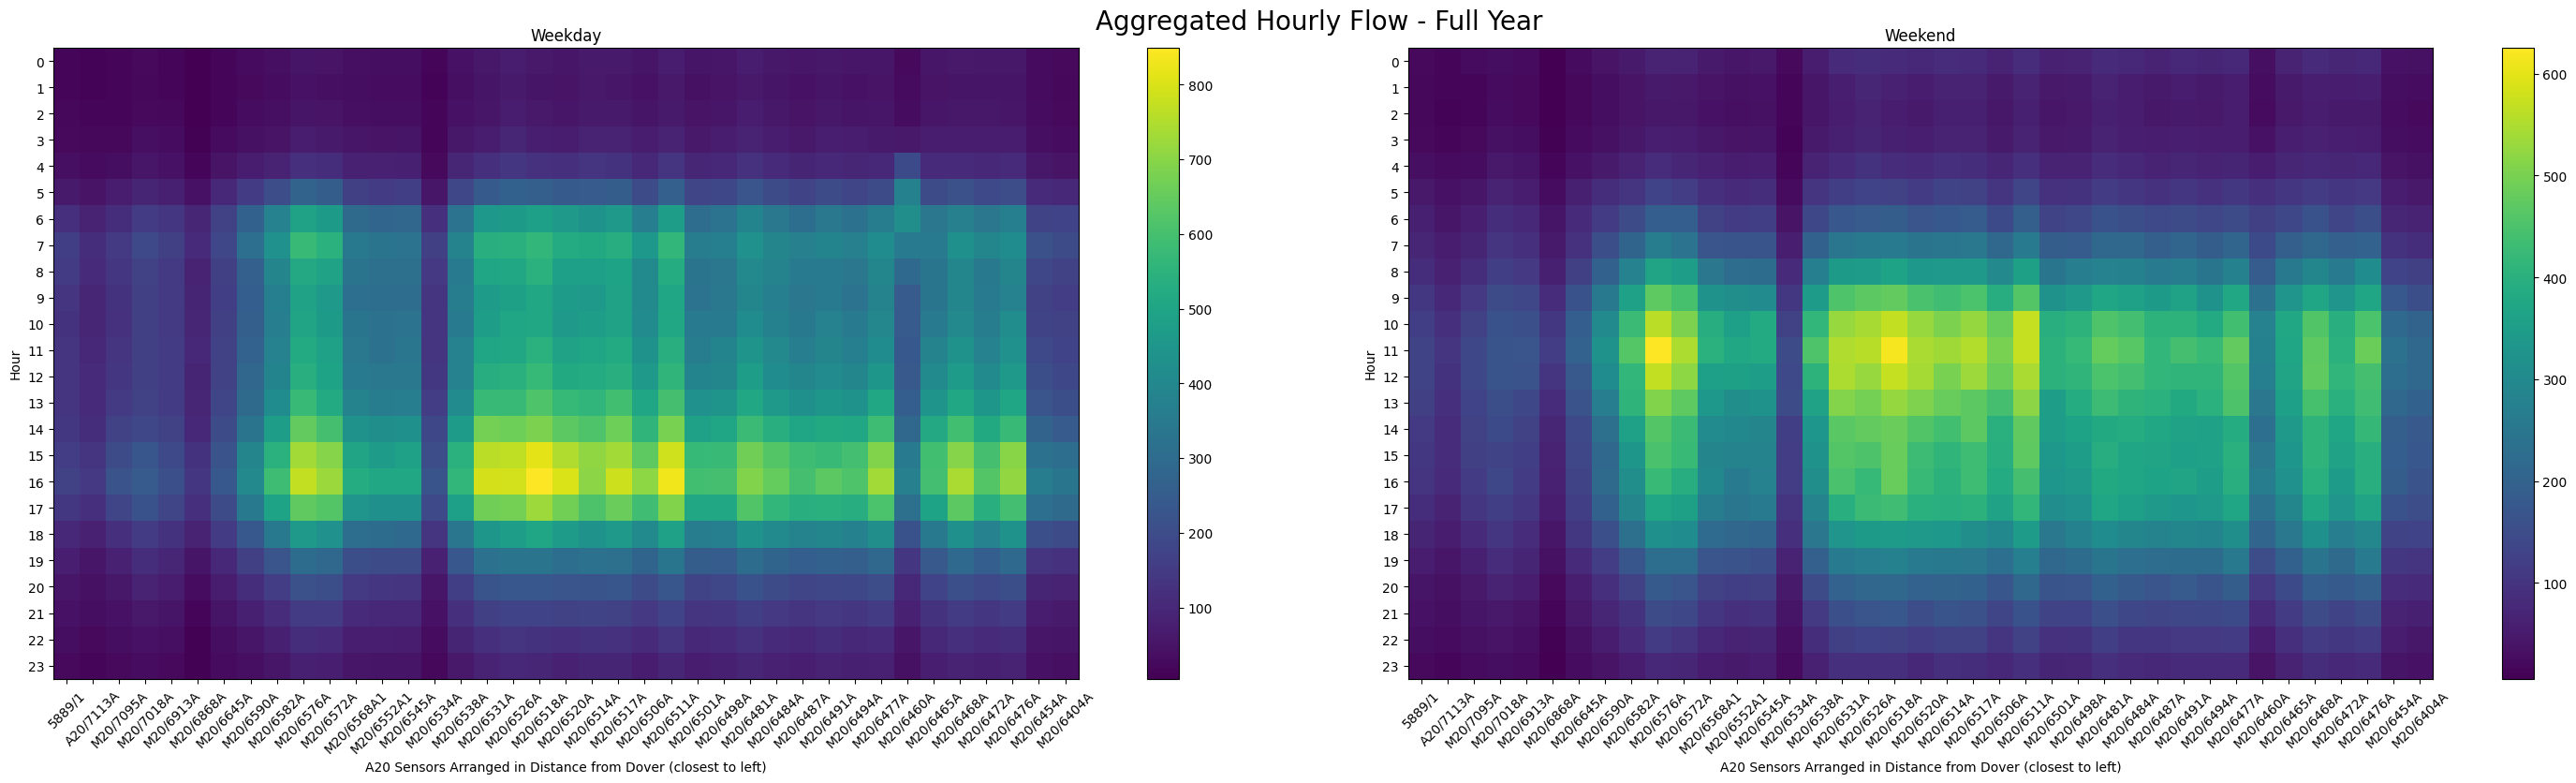

In [237]:
# Yearly weekday
quality_sensors = a20_ts_data_int[list(sensor_level_data[sensor_level_data['Data Quality Check']].index)]
#Get Weekday Readings
weekday_readings = quality_sensors.loc[day_lookup[day_lookup['wd']].index]
hourly_mean_weekday = weekday_readings.groupby(weekday_readings.index.hour).mean()
#Get Weekend Readings
weekend_readings = quality_sensors.loc[day_lookup[day_lookup['we']].index]
hourly_mean_weekend = weekend_readings.groupby(weekend_readings.index.hour).mean()

# Specify the size of the plot using figsize
fig, ax = plt.subplots(1,2,figsize=(30, 8))

#Weekday Plot
im = ax[0].imshow(hourly_mean_weekday.values, cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=ax[0]) 
ax[0].set_xticks(list(range(len(list(hourly_mean_weekday.columns)))),list(hourly_mean_weekday.columns), rotation=45)
ax[0].set_yticks(range(24),range(24))
ax[0].set_ylabel('Hour')
ax[0].set_xlabel('A20 Sensors Arranged in Distance from Dover (closest to left)')
ax[0].set_title('Weekday')

#Weekend Plot
im = ax[1].imshow(hourly_mean_weekend.values, cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=ax[1]) 
ax[1].set_xticks(range(len(list(hourly_mean_weekend.columns))),list(hourly_mean_weekend.columns), rotation=45)
ax[1].set_yticks(range(24),range(24))
ax[1].set_ylabel('Hour')
ax[1].set_xlabel('A20 Sensors Arranged in Distance from Dover (closest to left)')
ax[1].set_title('Weekend')

plt.suptitle('Aggregated Hourly Flow - Full Year',fontsize = 20)

plt.tight_layout()
plt.show()

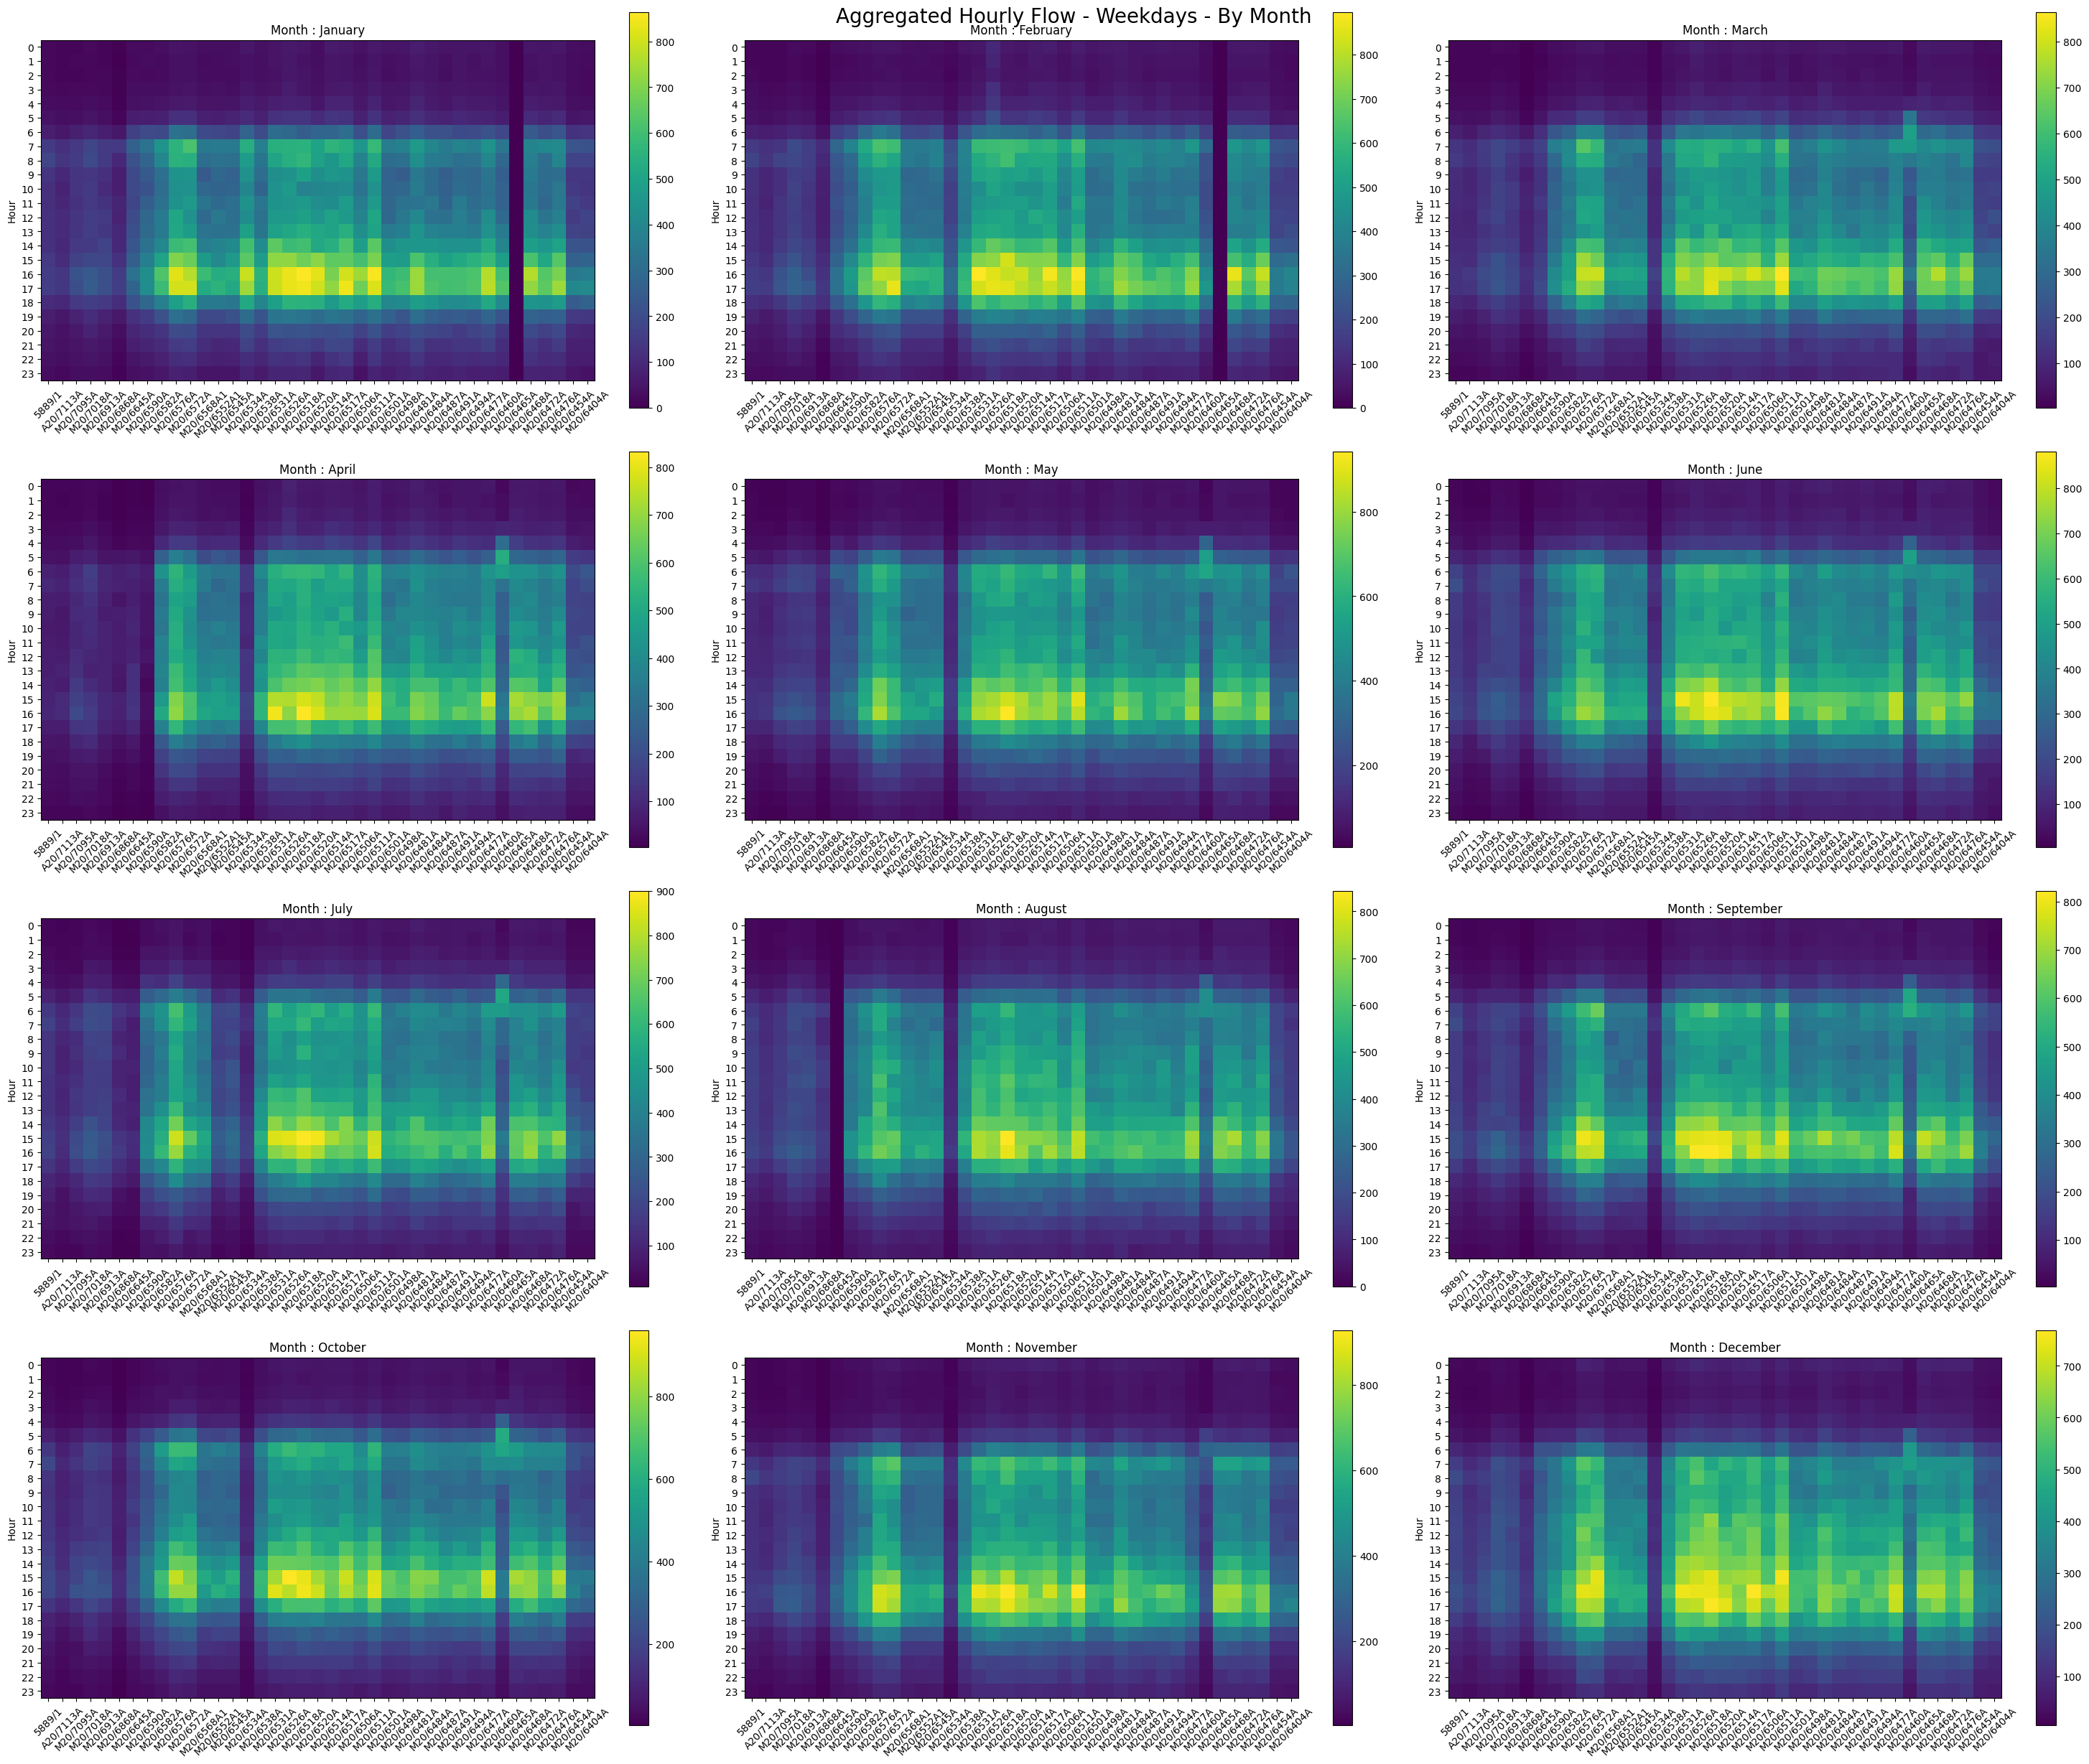

In [238]:
#Weekday

# Yearly weekday

quality_sensors = a20_ts_data_int[list(sensor_level_data[sensor_level_data['Data Quality Check']].index)]
#Get Weekday Readings
weekday_readings = quality_sensors.loc[day_lookup[day_lookup['wd']].index]


fig, ax = plt.subplots(4,3,figsize=(30, 25))

ax_across = 0
ax_down = 0

for m in range(1,13):

    month_data = weekday_readings[weekday_readings.index.month == m].groupby(weekday_readings[weekday_readings.index.month == m].index.hour).mean()

    #Weekday Plot
    im = ax[ax_down,ax_across].imshow(month_data.values, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax[ax_down,ax_across]) 
    ax[ax_down,ax_across].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
    ax[ax_down,ax_across].set_yticks(range(24),range(24))
    ax[ax_down,ax_across].set_ylabel('Hour')
    ax[ax_down,ax_across].set_title('Month : {}'.format(month_label[m]))
    
    if ax_across < 2:
        ax_across += 1
    else:
        ax_across = 0
        ax_down += 1


plt.suptitle('Aggregated Hourly Flow - Weekdays - By Month', fontsize = 20)
plt.tight_layout()  
plt.show()

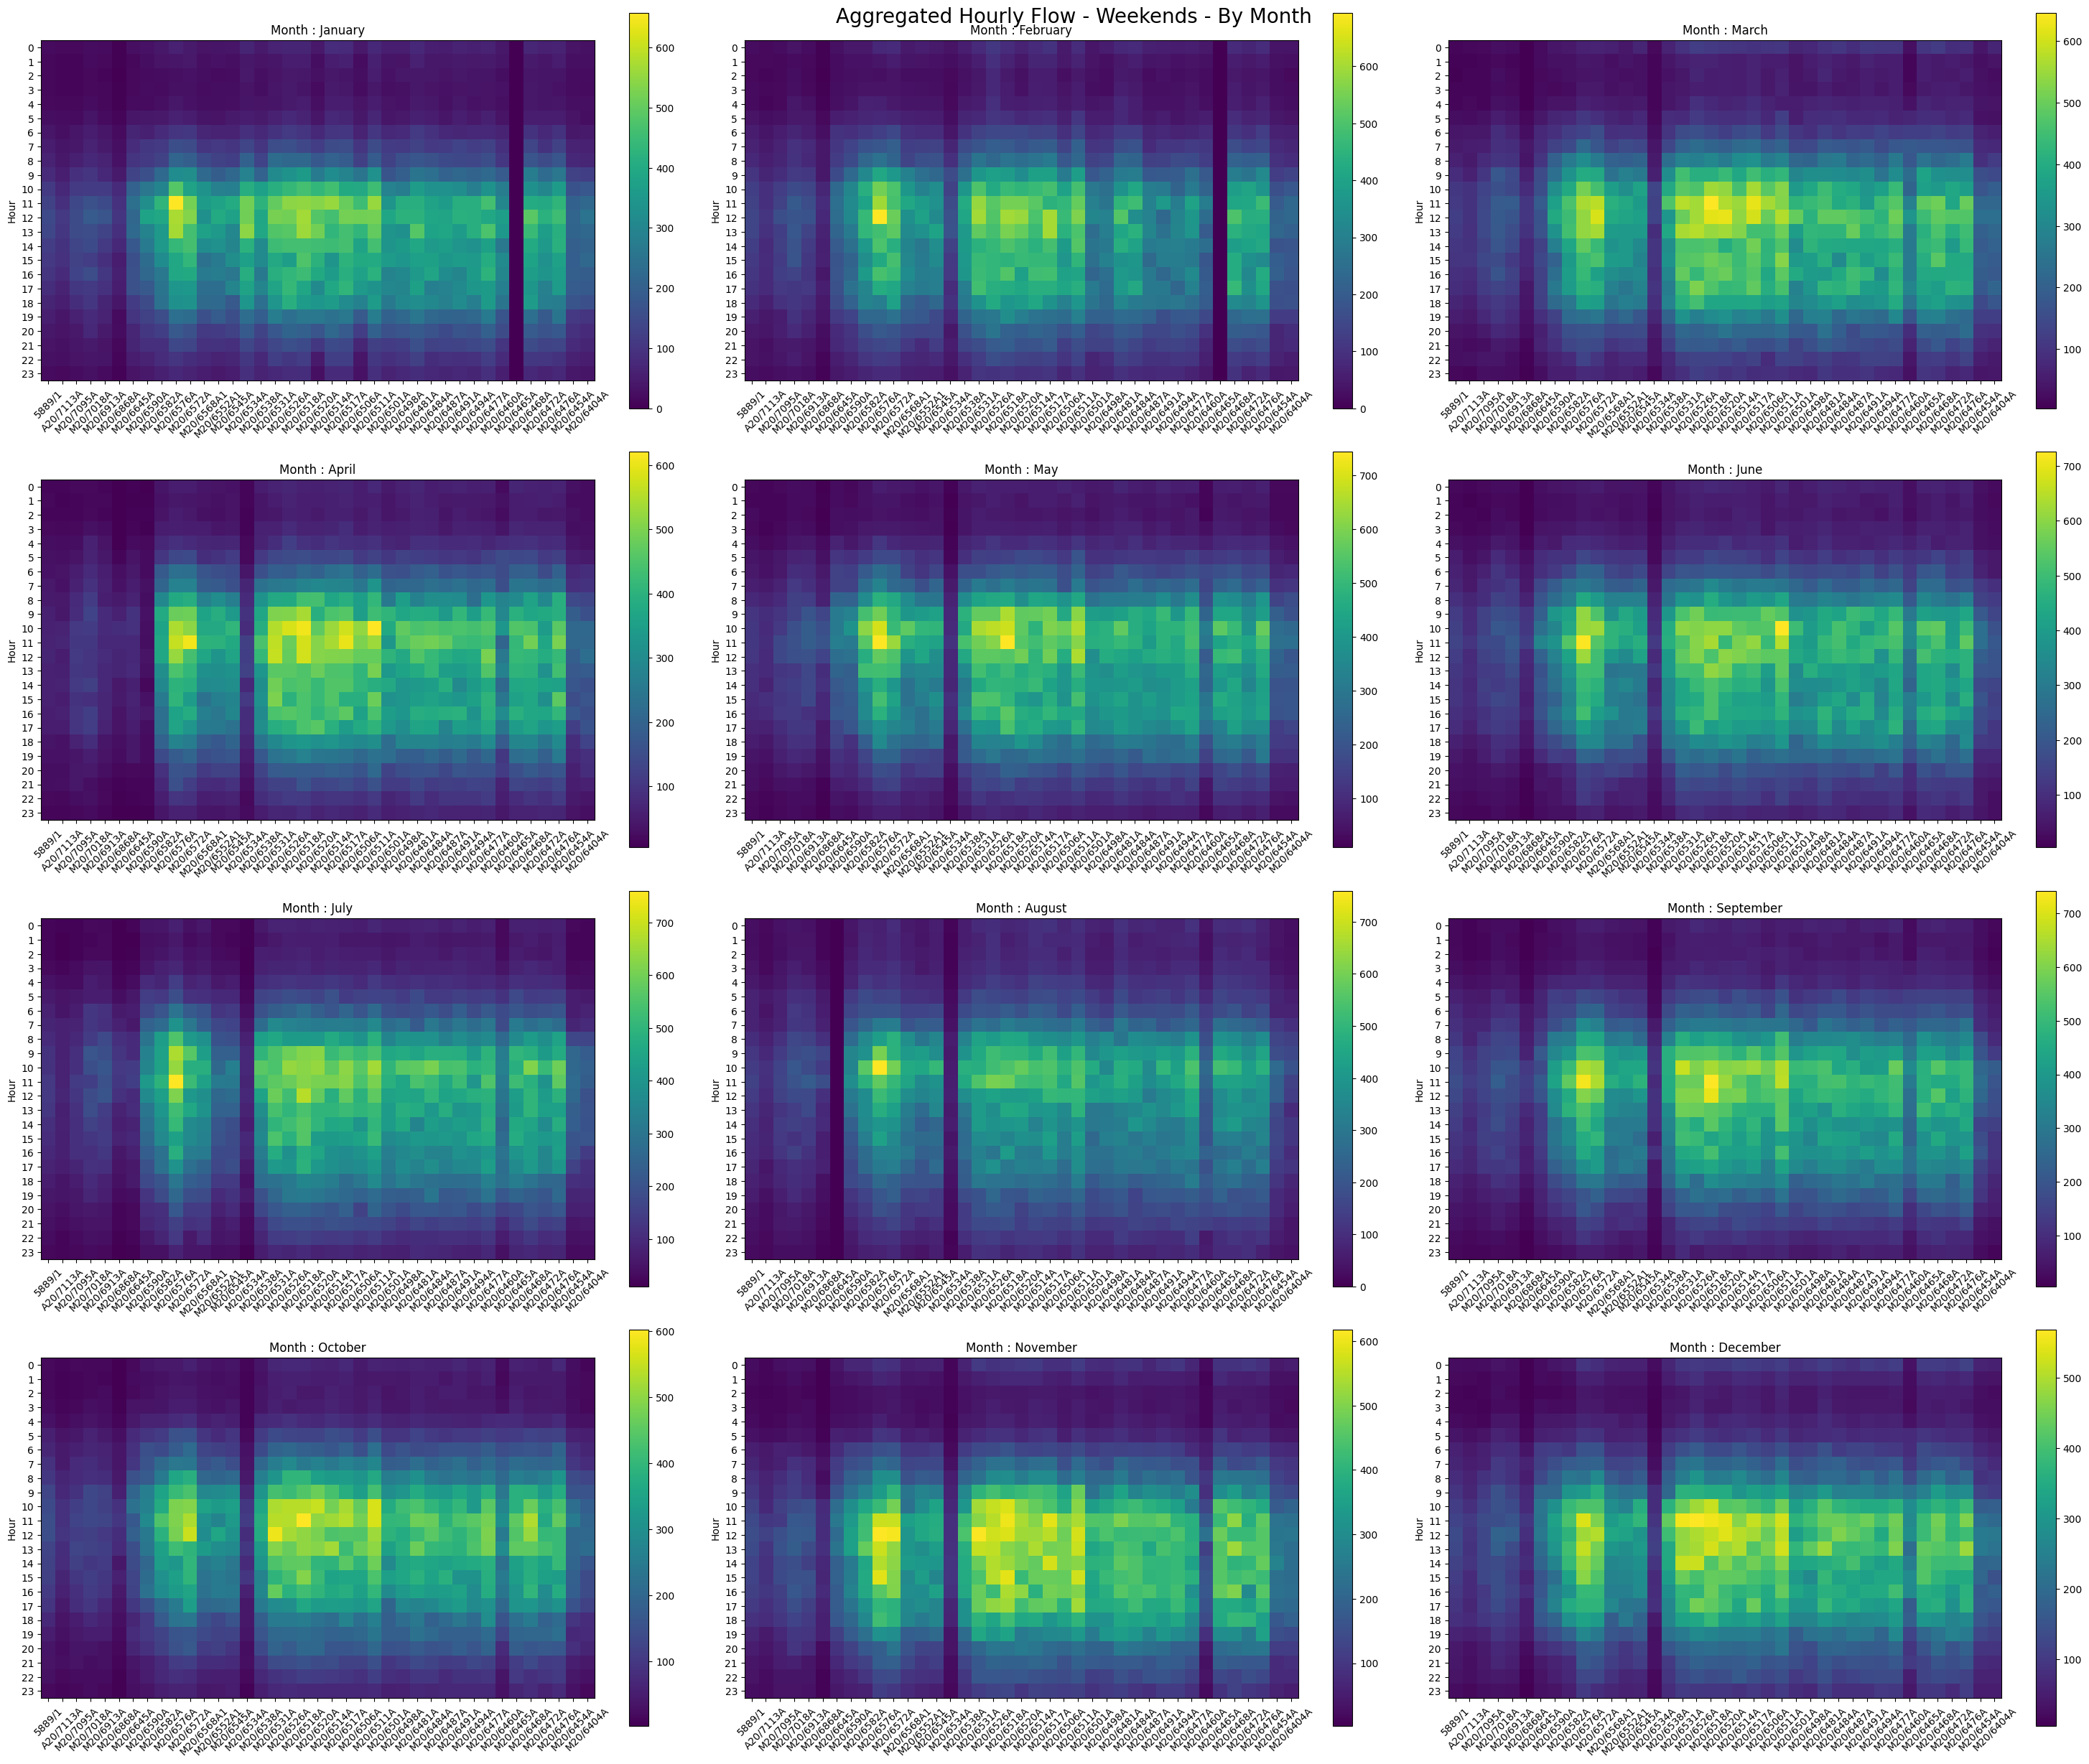

In [239]:
#Weekday

# Yearly weekday
quality_sensors = a20_ts_data_int[list(sensor_level_data[sensor_level_data['Data Quality Check']].index)]
#Get Weekday Readings
weekend_readings = quality_sensors.loc[day_lookup[day_lookup['we']].index]

fig, ax = plt.subplots(4,3,figsize=(30, 25))

ax_across = 0
ax_down = 0

for m in range(1,13):

    month_data = weekend_readings[weekend_readings.index.month == m].groupby(weekend_readings[weekend_readings.index.month == m].index.hour).mean()

    #Weekday Plot
    im = ax[ax_down,ax_across].imshow(month_data.values, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax[ax_down,ax_across]) 
    ax[ax_down,ax_across].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
    ax[ax_down,ax_across].set_yticks(range(24),range(24))
    ax[ax_down,ax_across].set_ylabel('Hour')
    ax[ax_down,ax_across].set_title('Month : {}'.format(month_label[m]))
    
    if ax_across < 2:
        ax_across += 1
    else:
        ax_across = 0
        ax_down += 1

plt.suptitle('Aggregated Hourly Flow - Weekends - By Month', fontsize = 20)
plt.tight_layout()  
plt.show()

#### Key findings

- Distinct weekend/weekday patterns
    - Weekdays tend to peak in early evening which implies significant commuter traffic on road
    - Weekend tend to peak around midday
- Not all traffic flow down the road to Dover, there are two significant drop off points which are probably around Ashford and Folkstone (need to double check this)
    - Make argument for approach to simulate traffic demand, as a data-driven demand model would capture these variances in destination points
- Weekend patterns more variable across the year than weekday

### Analysis 3 - Spatial Correlation Analysis

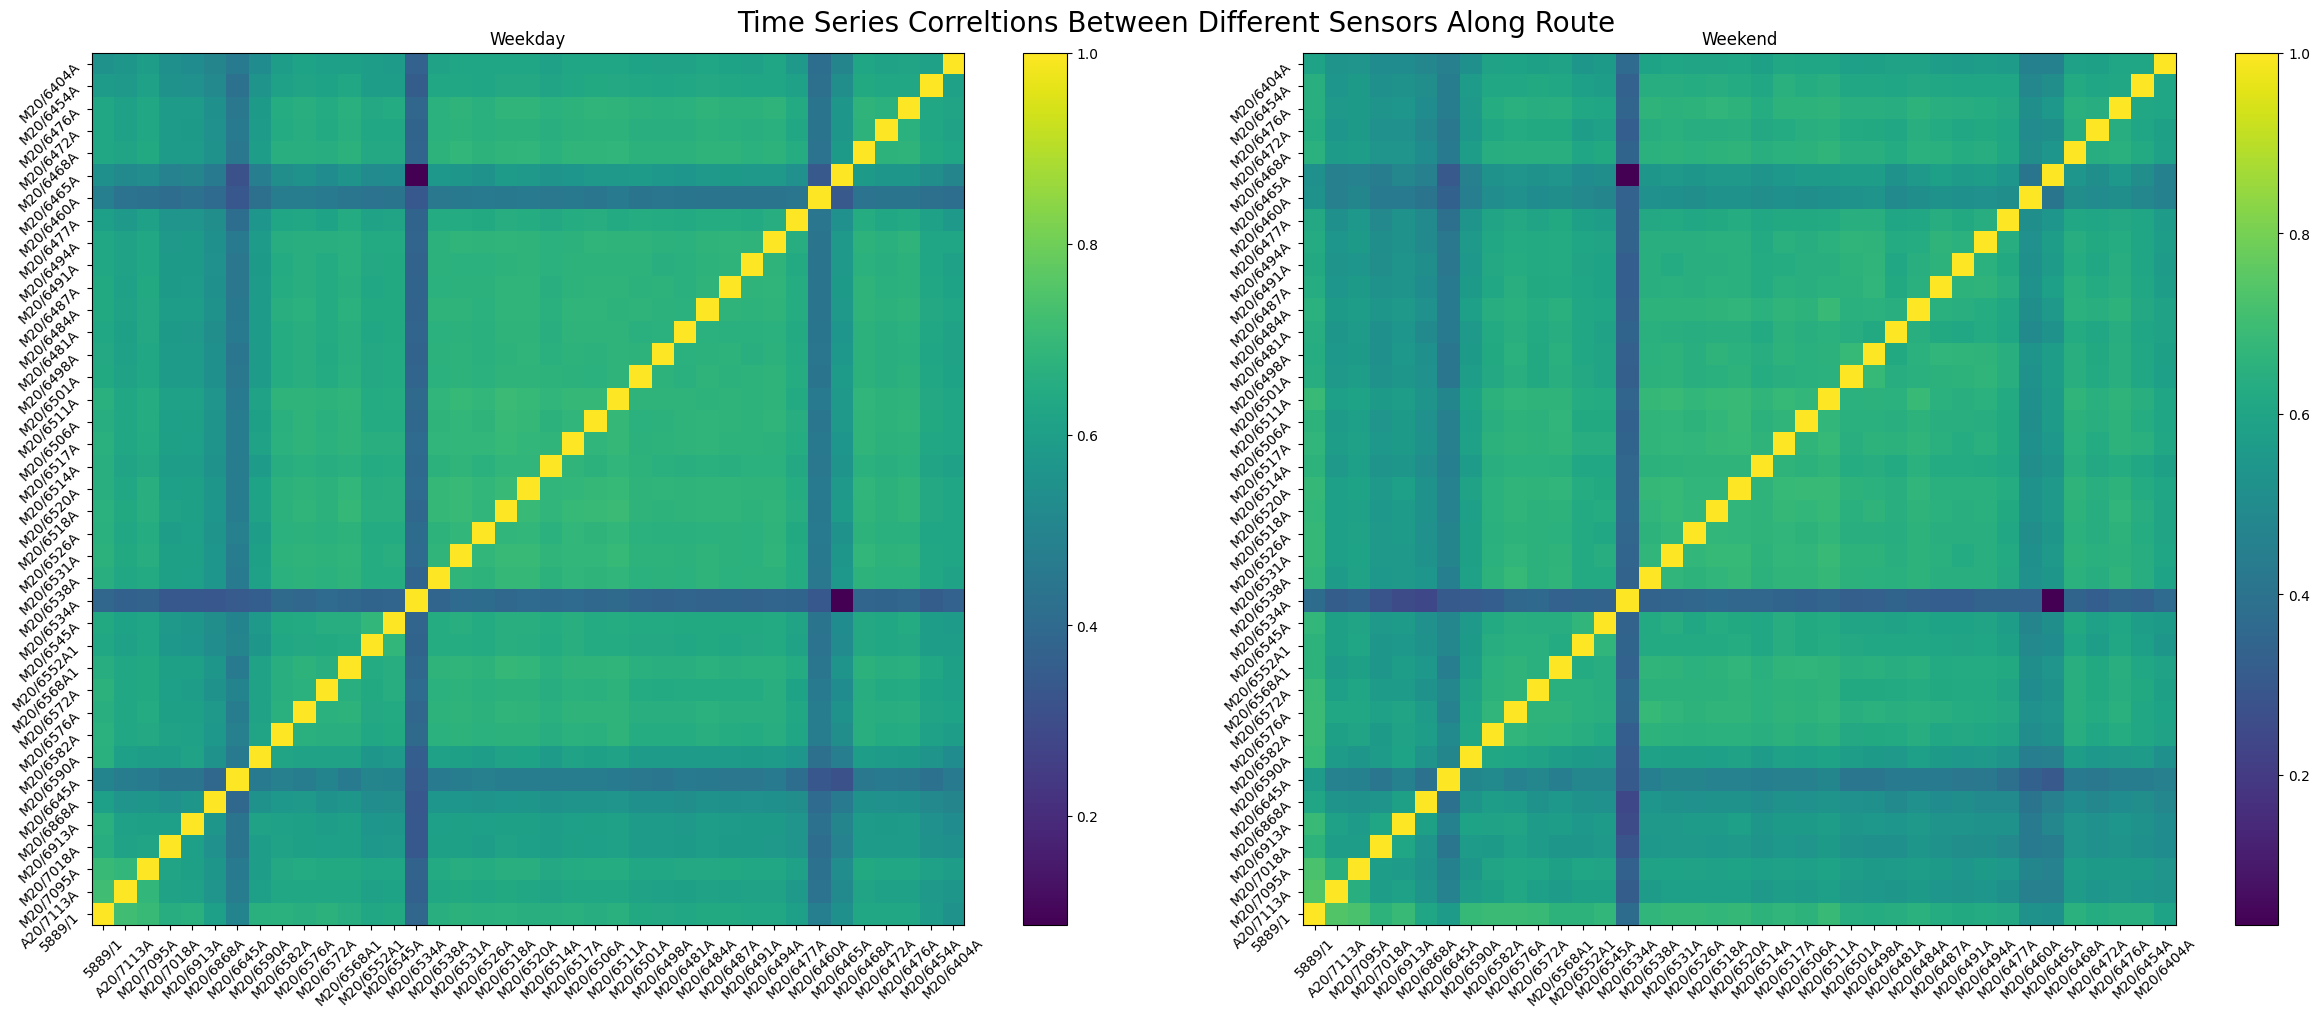

In [285]:
mask = list(sensor_level_data['Data Quality Check'])

fig, ax = plt.subplots(1,2,figsize=(25, 10))

# Weekday
# Create a heatmap with nan values greyed out
im = ax[0].imshow(np.flip(s2s_corr_wd[mask, :][:, mask], axis = 0), cmap='viridis', interpolation='none')
# Add colorbar
plt.colorbar(im, ax=ax[0]) 
ax[0].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax[0].set_yticks(list(range(len(list(month_data.columns)))),list(month_data.columns)[::-1], rotation=45)
ax[0].set_title('Weekday')

# Weekend
# Create a heatmap with nan values greyed out
im = ax[1].imshow(np.flip(s2s_corr_we[mask, :][:, mask], axis = 0), cmap='viridis', interpolation='none')
# Add colorbar
plt.colorbar(im, ax=ax[1]) 
ax[1].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax[1].set_yticks(list(range(len(list(month_data.columns)))),list(month_data.columns)[::-1], rotation=45)
ax[1].set_title('Weekend')

plt.suptitle('Time Series Correltions Between Different Sensors Along Route', fontsize = 20)

plt.tight_layout()
# Show the plot
plt.show()

#### Key findings

- Sensor closest to Dover has a generally strong correlation to all other sensors, which diminishes somewhat with distance
- A small band of sensors (around Folkstone?) have poorer correlation than all other sensors - perhaps a lot of localised traffic influencing the readings
- Weekend correlation weaker and less consistent than weekday correlation
- A few sensors show very poor correlation, perhaps data quality issues to investigate, or they are really part of a seperate system 

### Analysis 4 - Travel Time Analysis

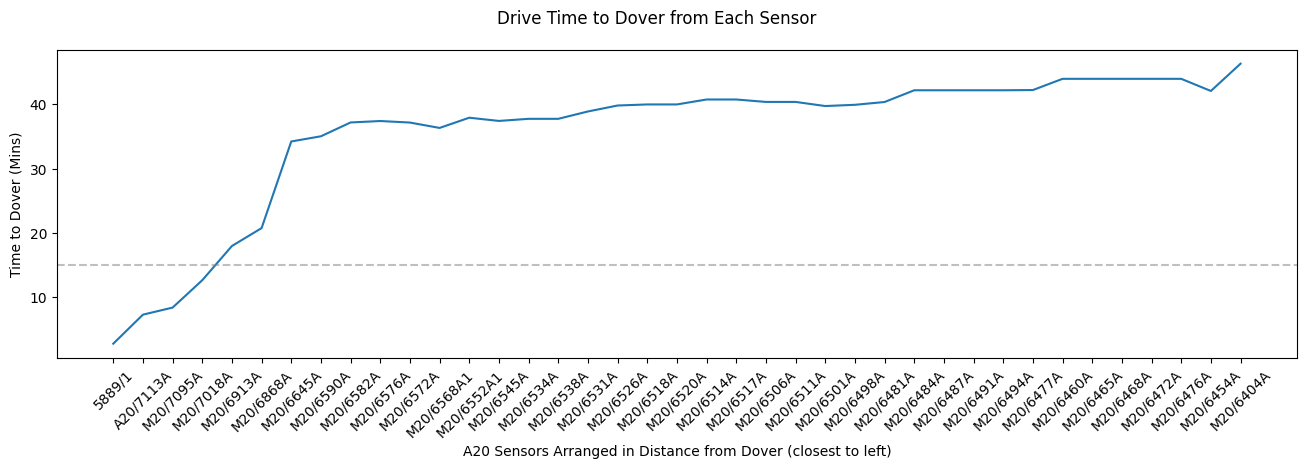

In [298]:
#Travel time to Dover

fig, ax = plt.subplots(1,1, figsize = [16,4])

sensor_level_data[sensor_level_data['Data Quality Check']]['Time to Dover'].plot(ax = ax)
ax.set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax.axhline(y=15, color='gray', linestyle='--', alpha=0.5, label = 'Cut off point for data quality')
ax.set_xlabel('A20 Sensors Arranged in Distance from Dover (closest to left)')
ax.set_ylabel('Time to Dover (Mins)')
plt.suptitle('Drive Time to Dover from Each Sensor')
plt.show()

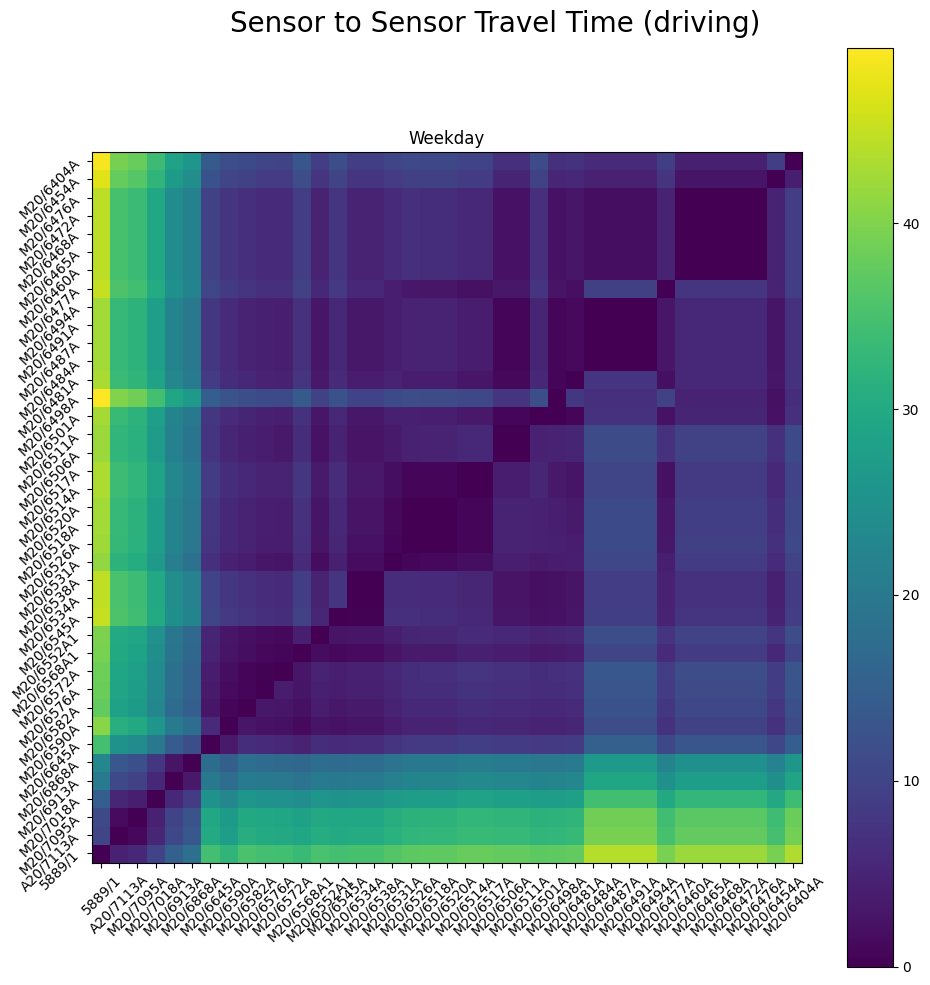

In [303]:
#Travel time cube

fig, ax = plt.subplots(figsize=(10, 10))

# Weekday
# Create a heatmap with nan values greyed out
im = ax.imshow(np.flip(s2s_time[mask, :][:, mask], axis = 0), cmap='viridis', interpolation='none')
# Add colorbar
plt.colorbar(im, ax=ax) 
ax.set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax.set_yticks(list(range(len(list(month_data.columns)))),list(month_data.columns)[::-1], rotation=45)
ax.set_title('Weekday')

plt.suptitle('Sensor to Sensor Travel Time (driving)', fontsize = 20)

plt.tight_layout()
# Show the plot
plt.show()

#### Key findings

- 4 or 5 sensors are reachable from Dover within 15 mins
- At most drive time to Dover is around 45 mins
- There is a significant increase in drive times to Dover around Folkstone (?) which then plateaus considerably, reflecting the spatial clustering of sensors along the road

### Analysis 5.1 - Time Series Analysis of Crucial Sensor (sensor closest to Dover)

-----------------
Next Columns : Lane 1
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 461
Rate of zeros : 1.3%
Count of nulls : 14610
Rate of nulls : 41.7%
Count of outliers : 554
Rate of outliers : 1.6%
-----------------




/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:164: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


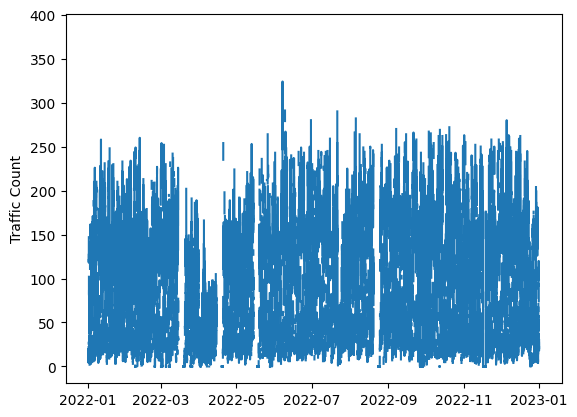

/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

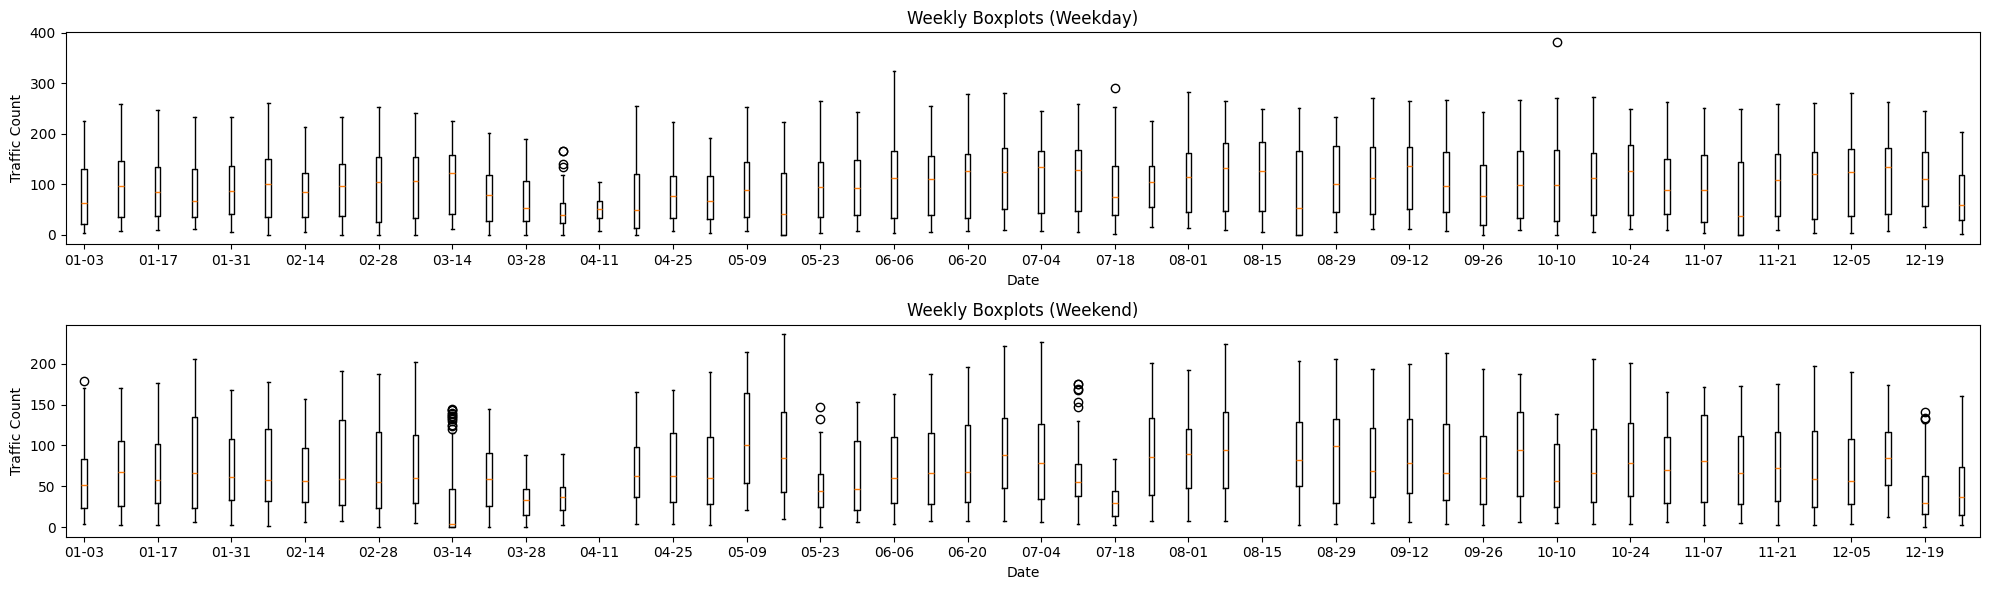

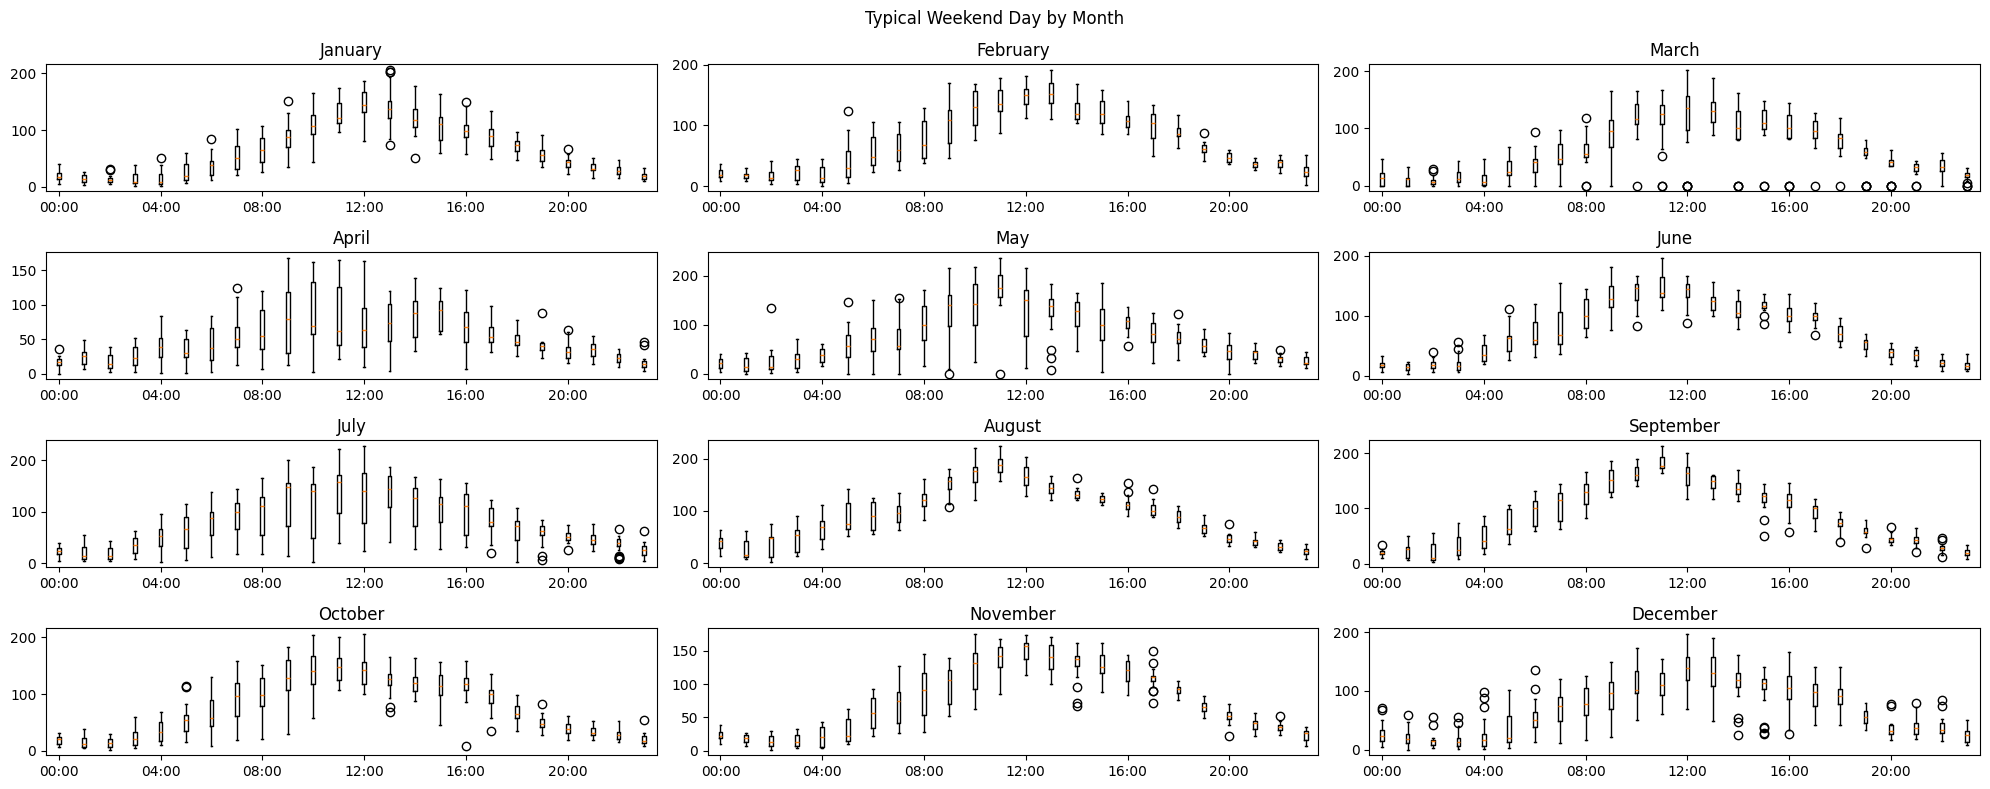

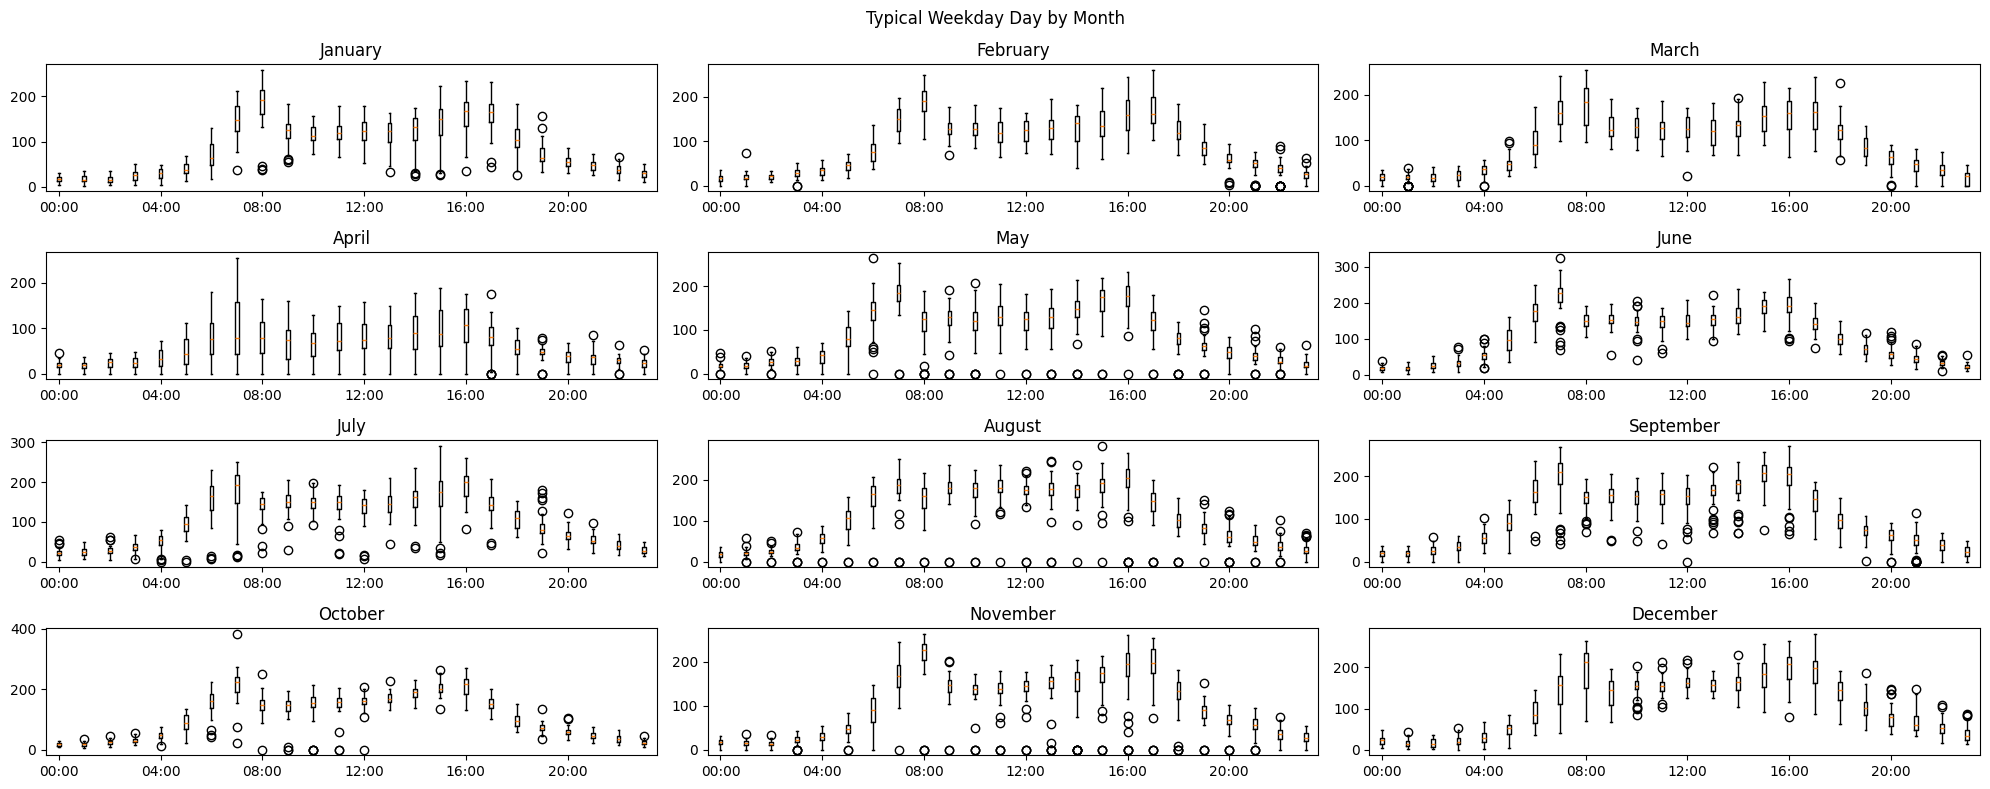

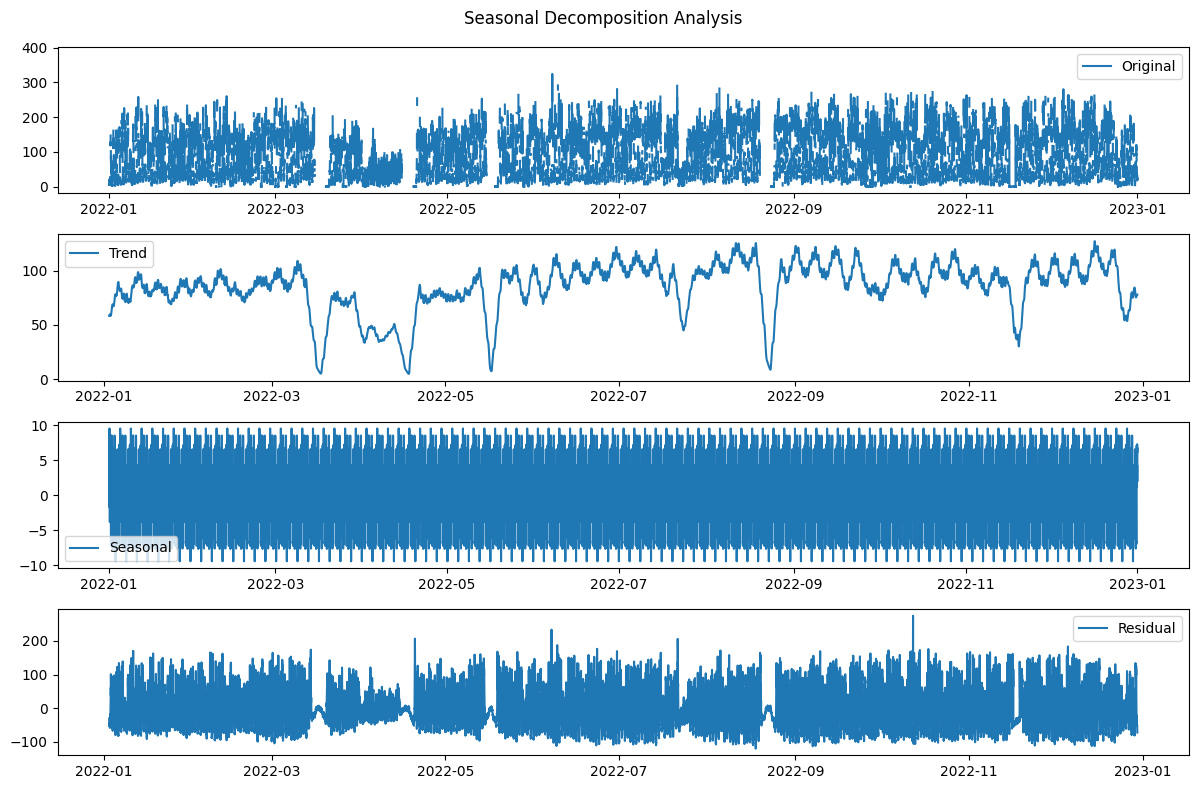

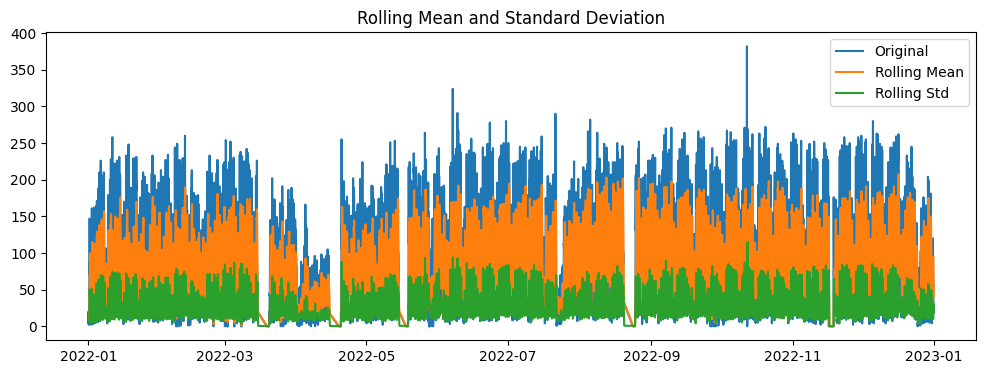

Augmented Dickey-Fuller Test:
Test Statistic: -21.079320770896476
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:355: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:364: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


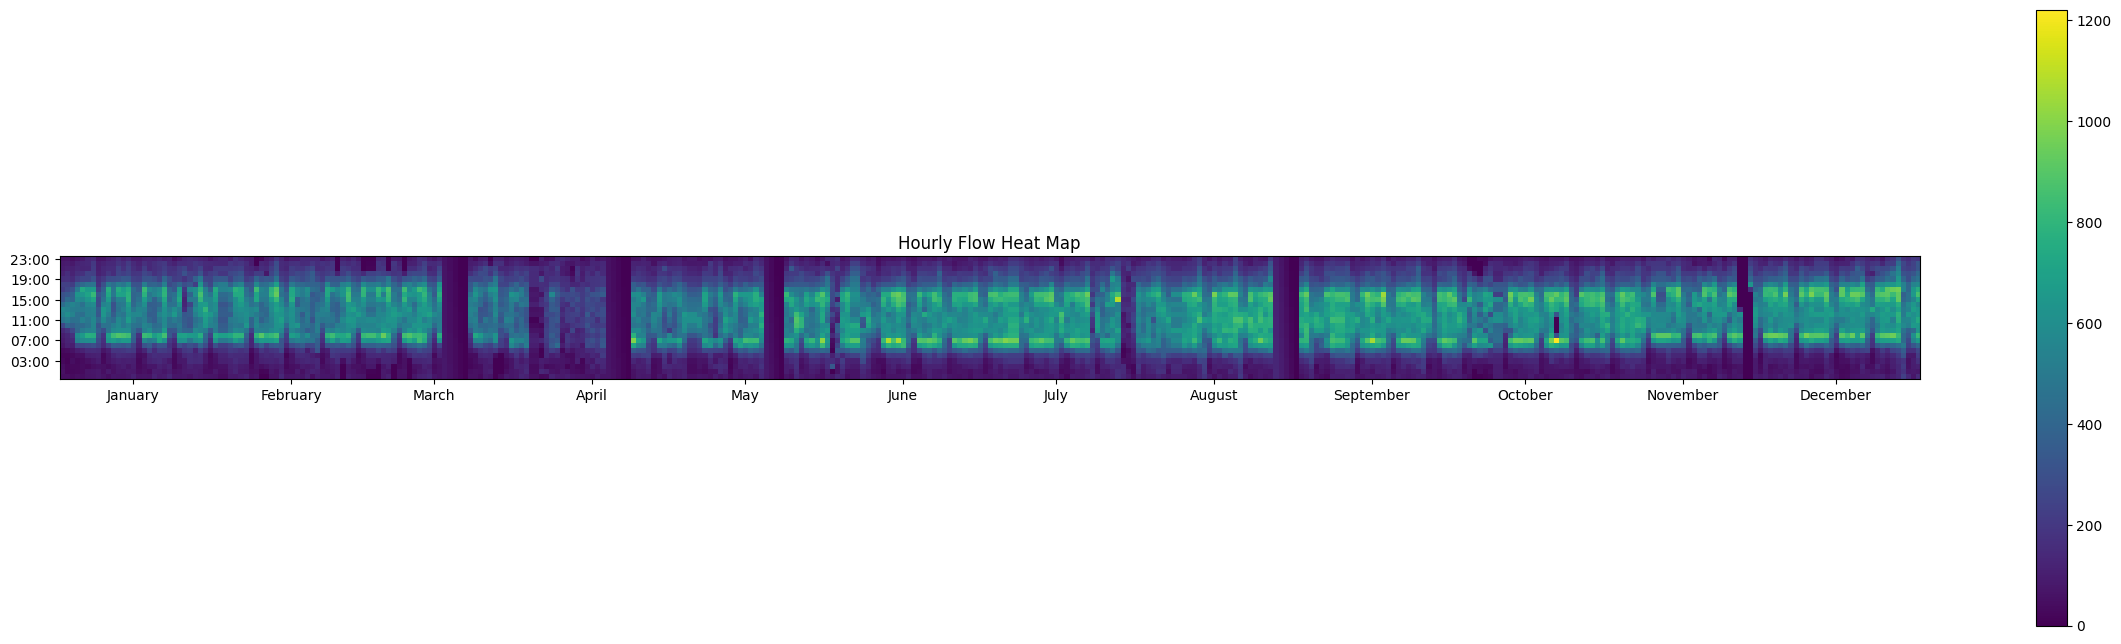

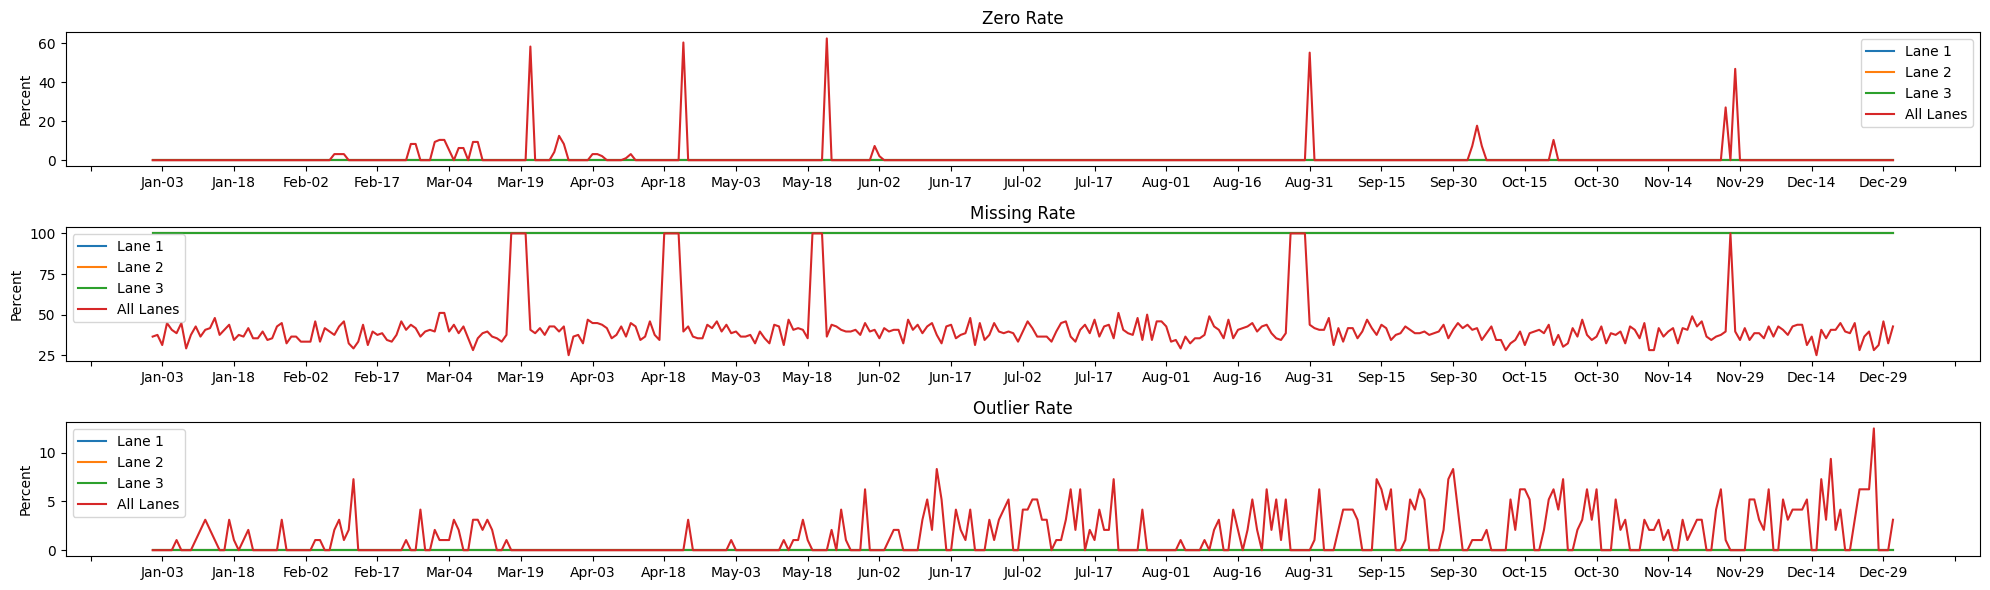

In [308]:
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_level_data[sensor_level_data['Data Quality Check']].index[0],start_date,end_date,cursor)

### Analysis 5.2 - Time Series Analysis of Crucial Sensor (sensor next closest to Dover)

-----------------
Next Columns : Lane 1
Count of zeros : 839
Rate of zeros : 2.4%
Count of nulls : 14087
Rate of nulls : 40.2%
Count of outliers : 55
Rate of outliers : 0.2%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 2101
Rate of zeros : 6.0%
Count of nulls : 13989
Rate of nulls : 39.9%
Count of outliers : 1085
Rate of outliers : 3.1%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 1665
Rate of zeros : 4.8%
Count of nulls : 5923
Rate of nulls : 16.9%
Count of outliers : 1309
Rate of outliers : 3.7%
-----------------




/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:164: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


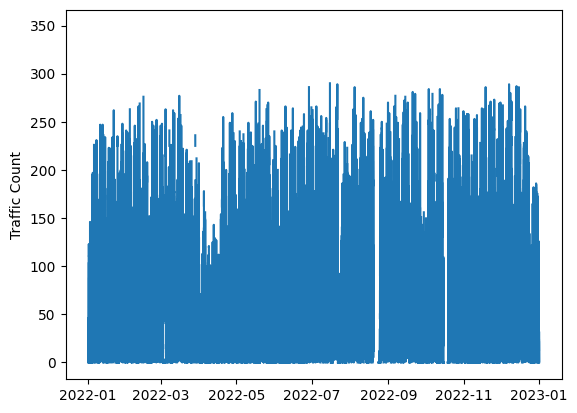

/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

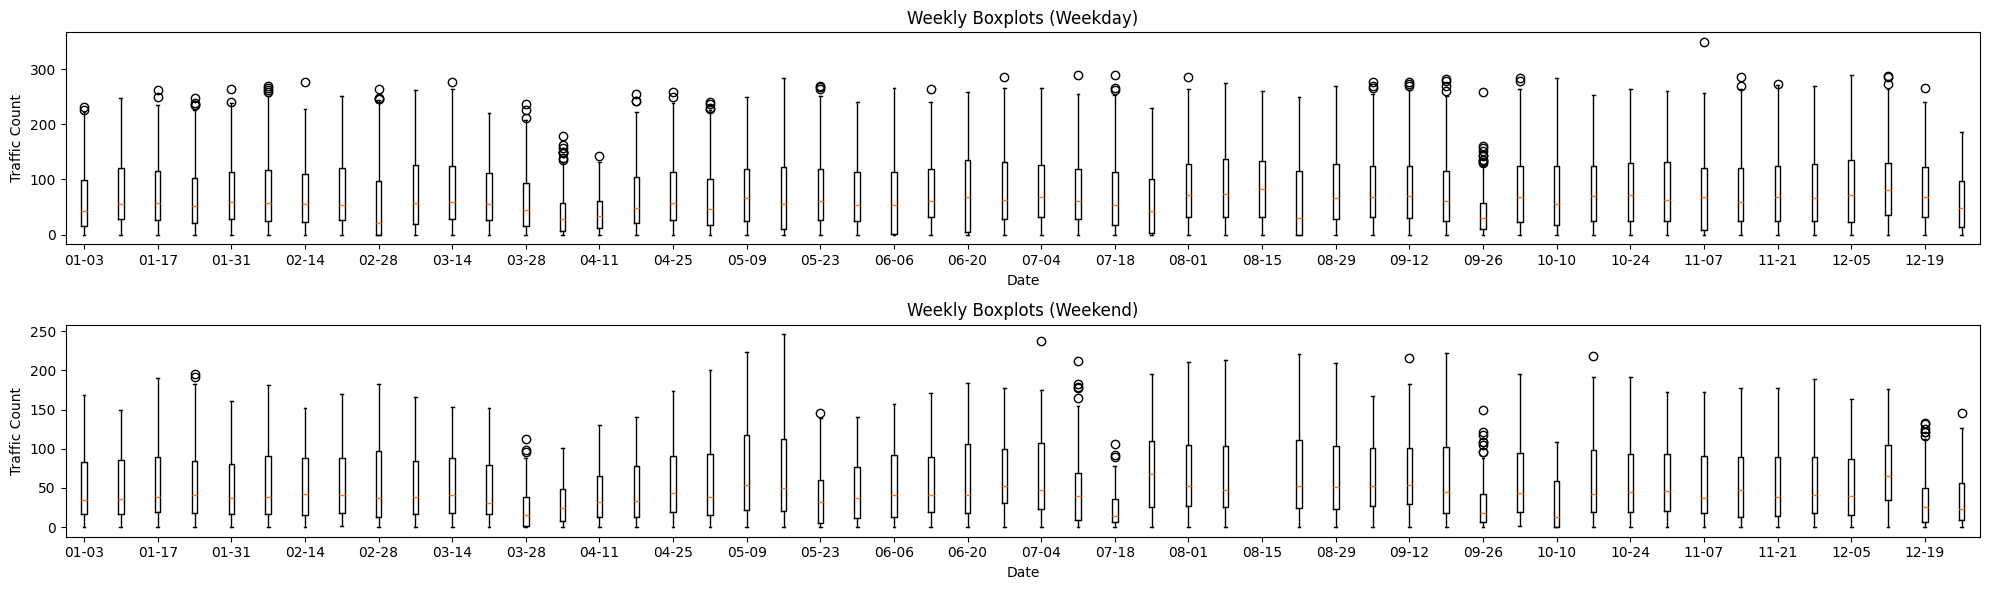

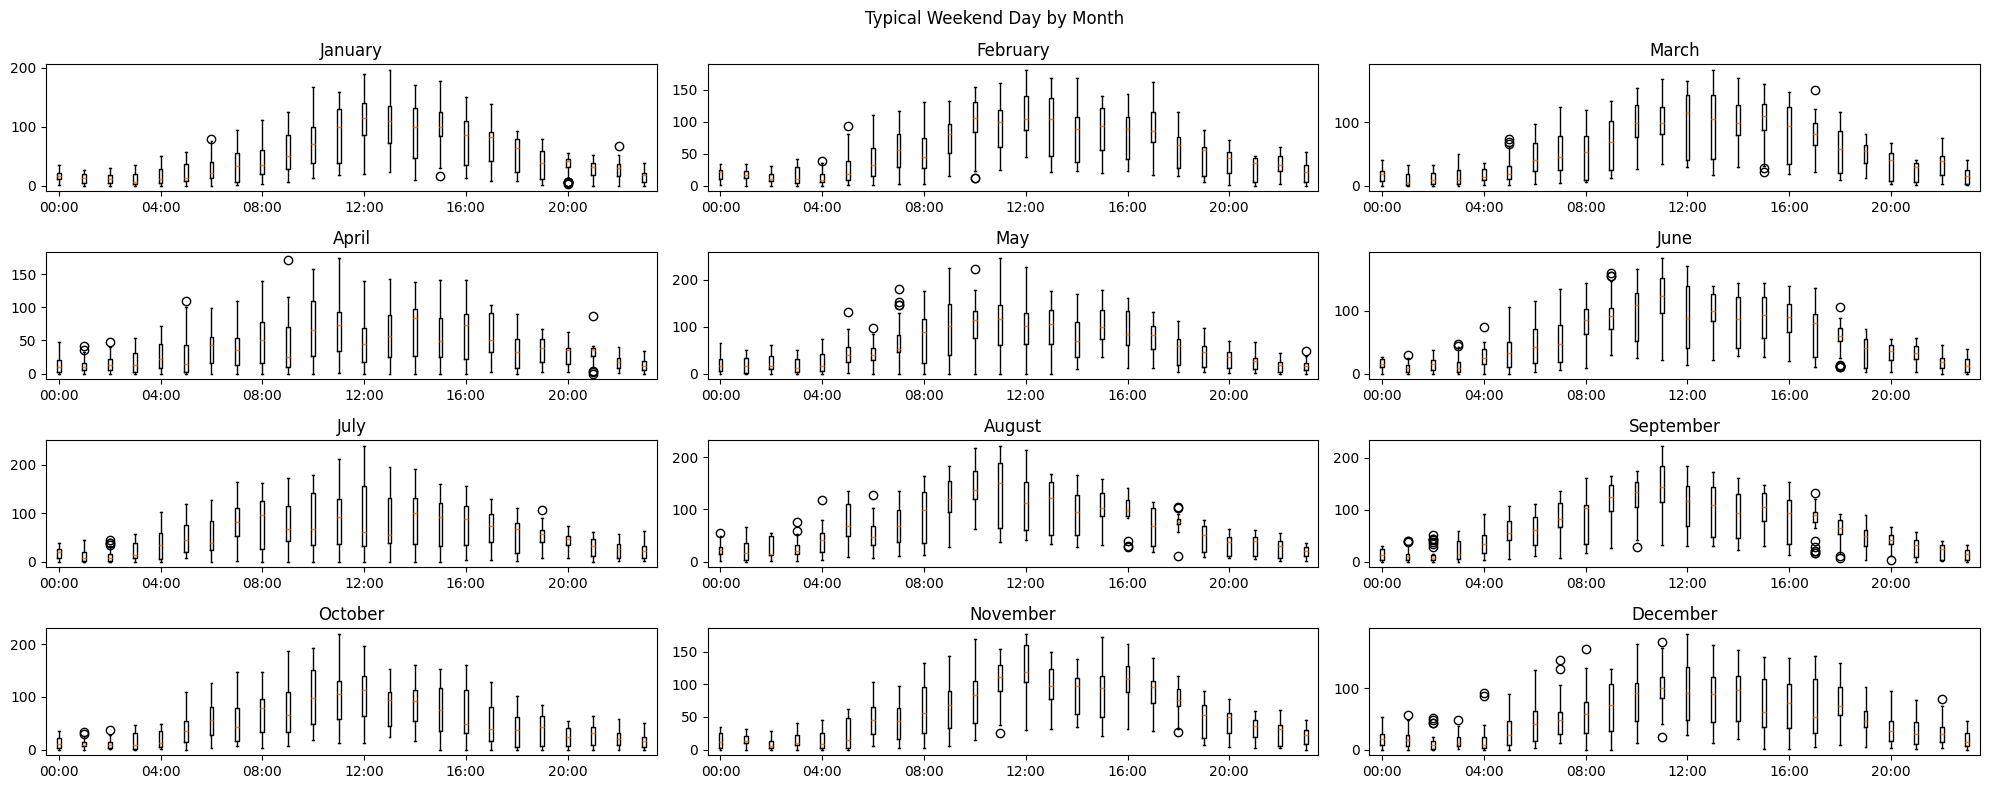

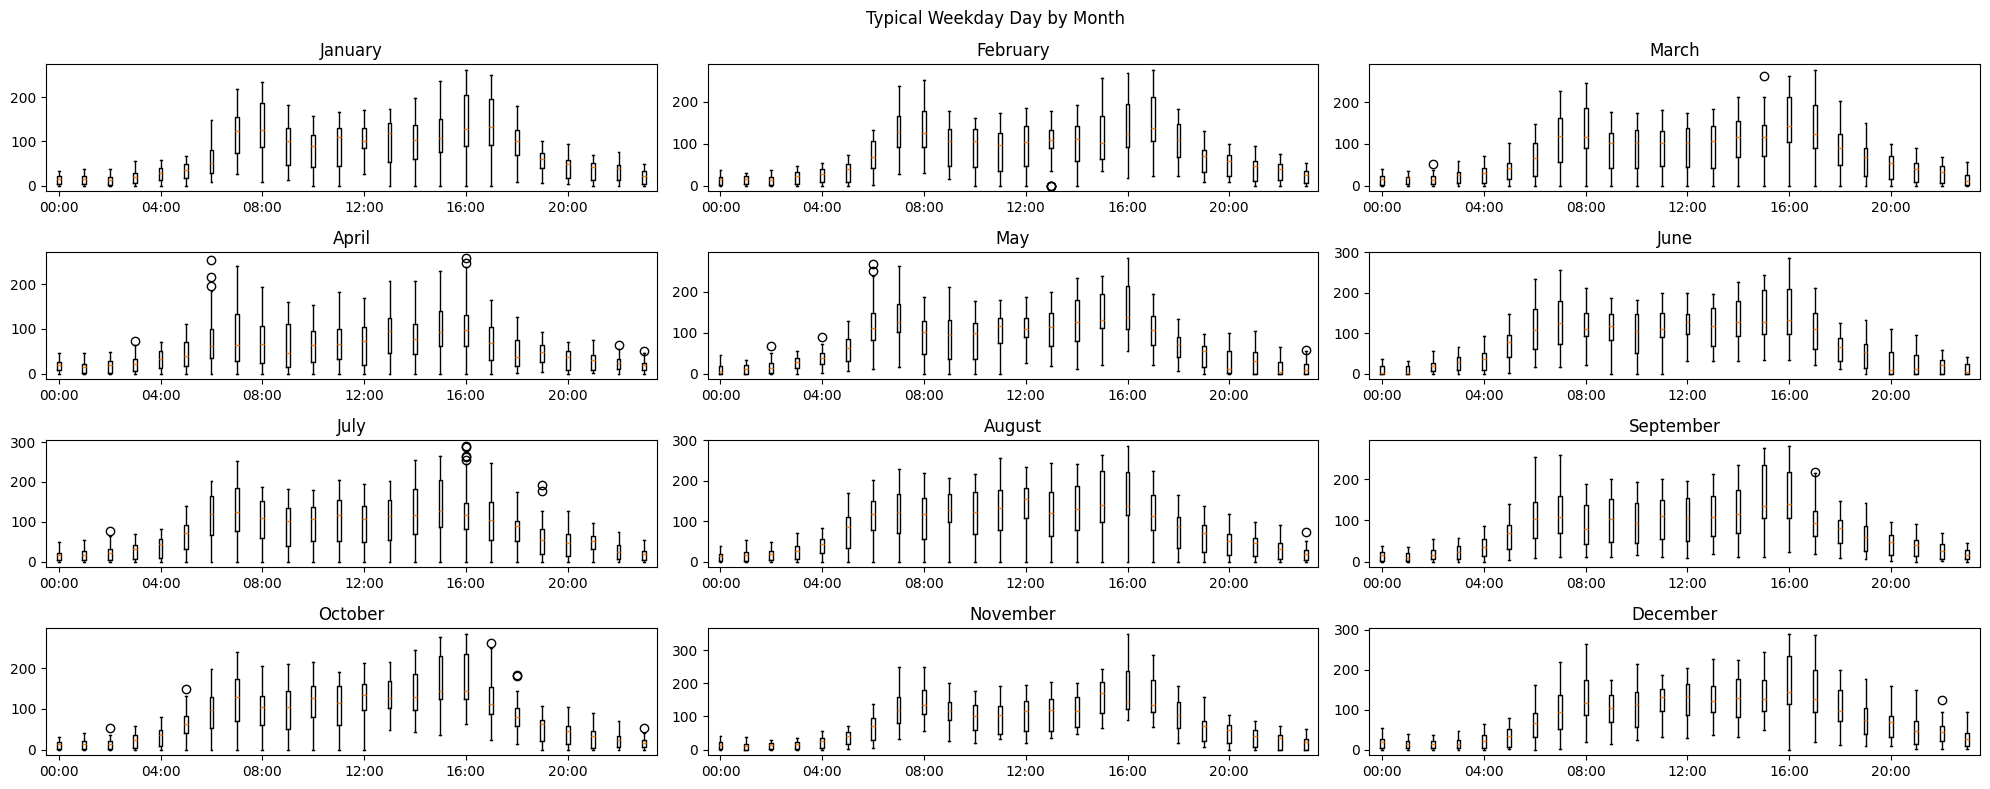

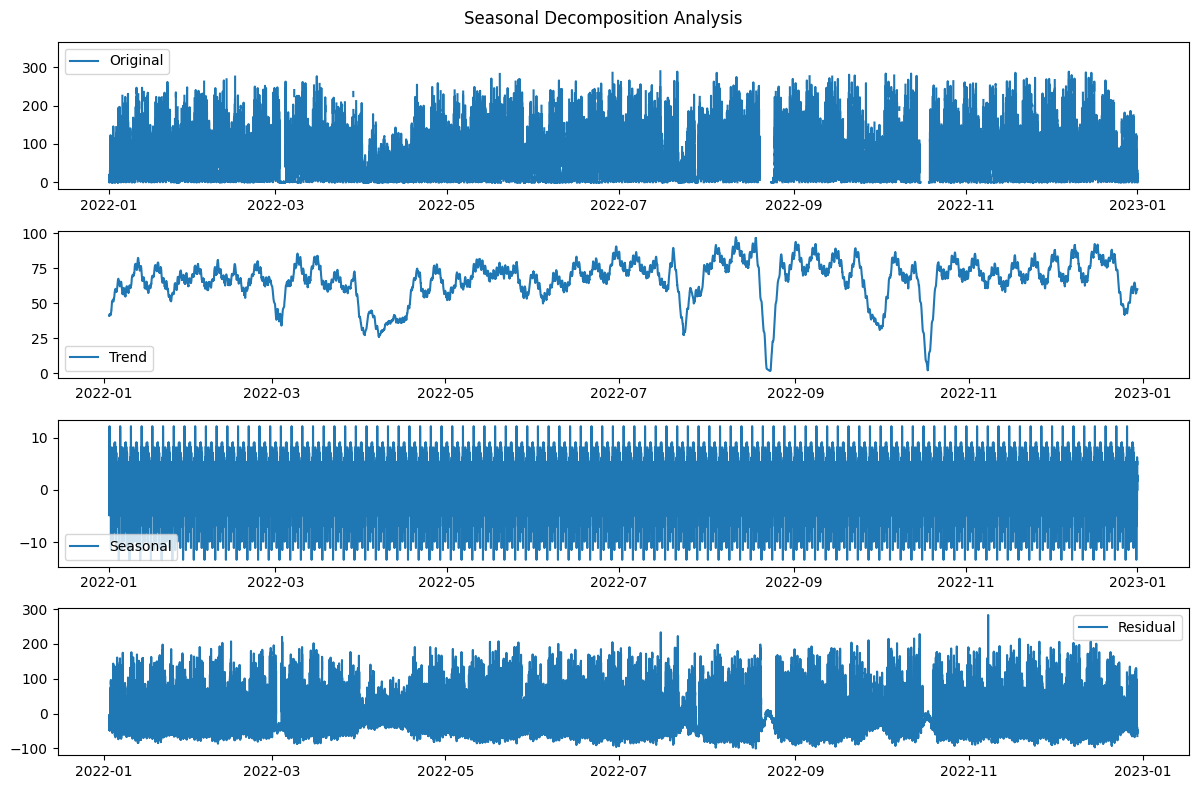

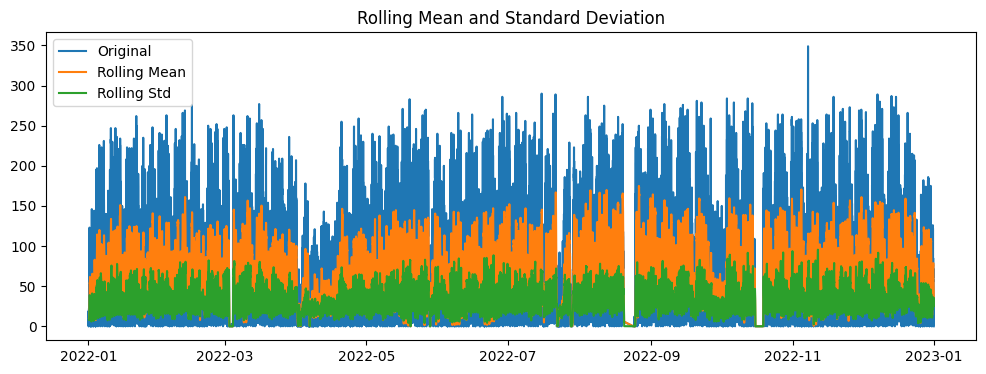

Augmented Dickey-Fuller Test:
Test Statistic: -30.056628225098258
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:355: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:364: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


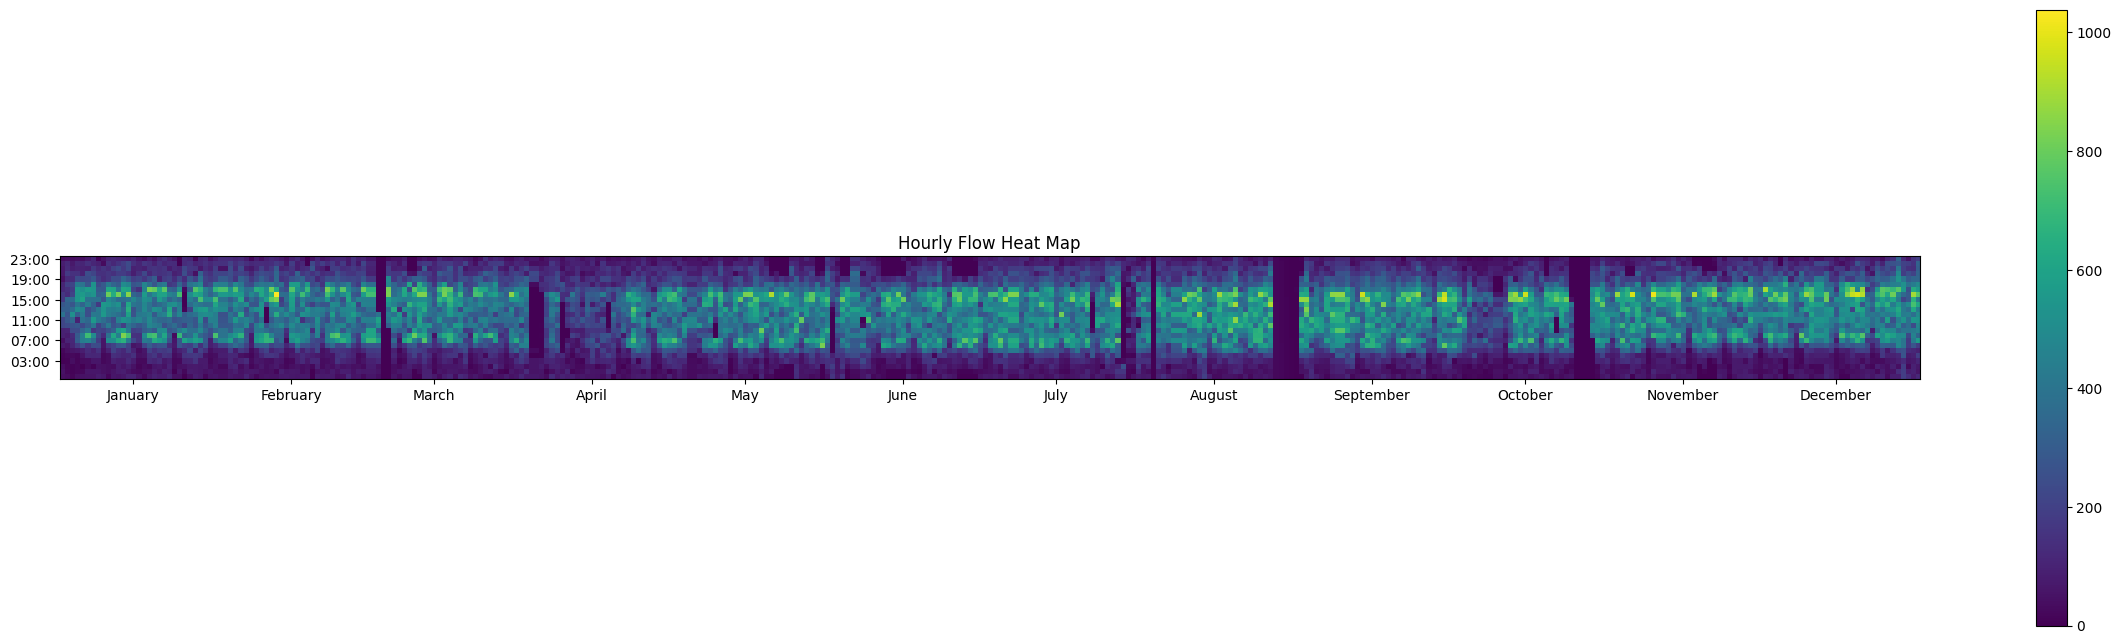

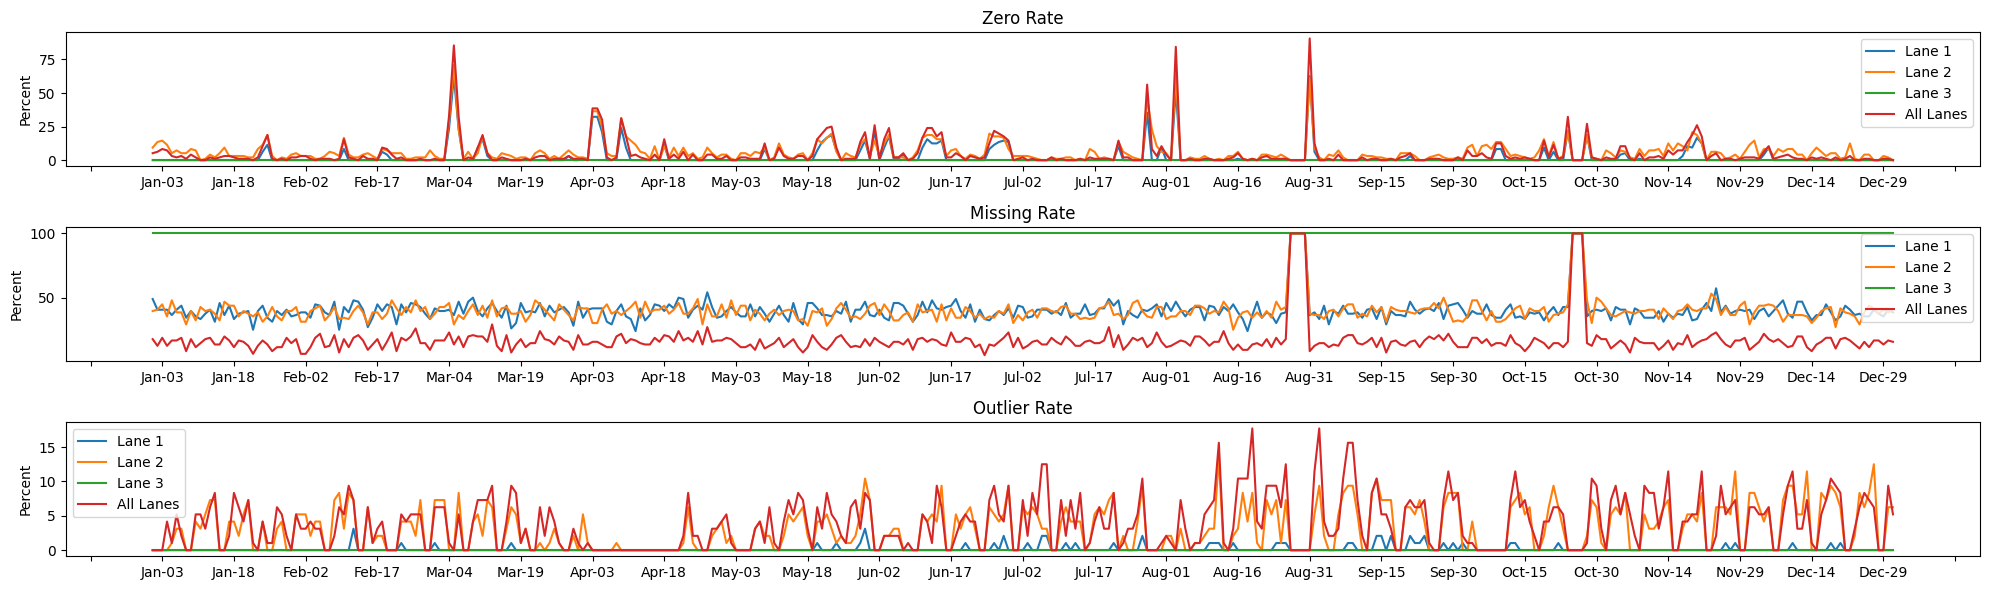

In [309]:
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_level_data[sensor_level_data['Data Quality Check']].index[1],start_date,end_date,cursor)

### Analysis 5.3 - Time Series Analysis of Crucial Sensor (sensor furthest from Dover)

-----------------
Next Columns : Lane 1
Count of zeros : 2120
Rate of zeros : 6.1%
Count of nulls : 14052
Rate of nulls : 40.1%
Count of outliers : 13
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 616
Rate of zeros : 1.8%
Count of nulls : 13864
Rate of nulls : 39.6%
Count of outliers : 969
Rate of outliers : 2.8%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 8410
Rate of zeros : 24.0%
Count of nulls : 13906
Rate of nulls : 39.7%
Count of outliers : 1149
Rate of outliers : 3.3%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 2528
Rate of zeros : 7.2%
Count of nulls : 2656
Rate of nulls : 7.6%
Count of outliers : 1548
Rate of outliers : 4.4%
-----------------




/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:164: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


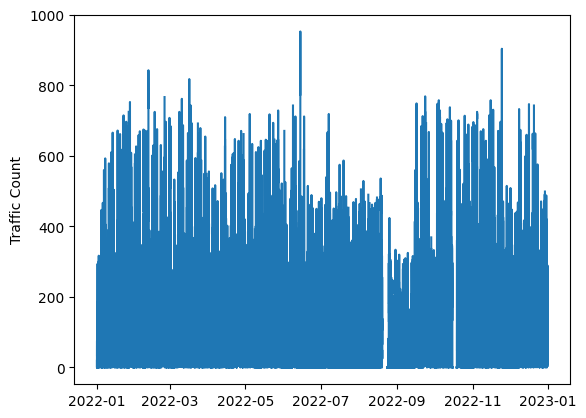

/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

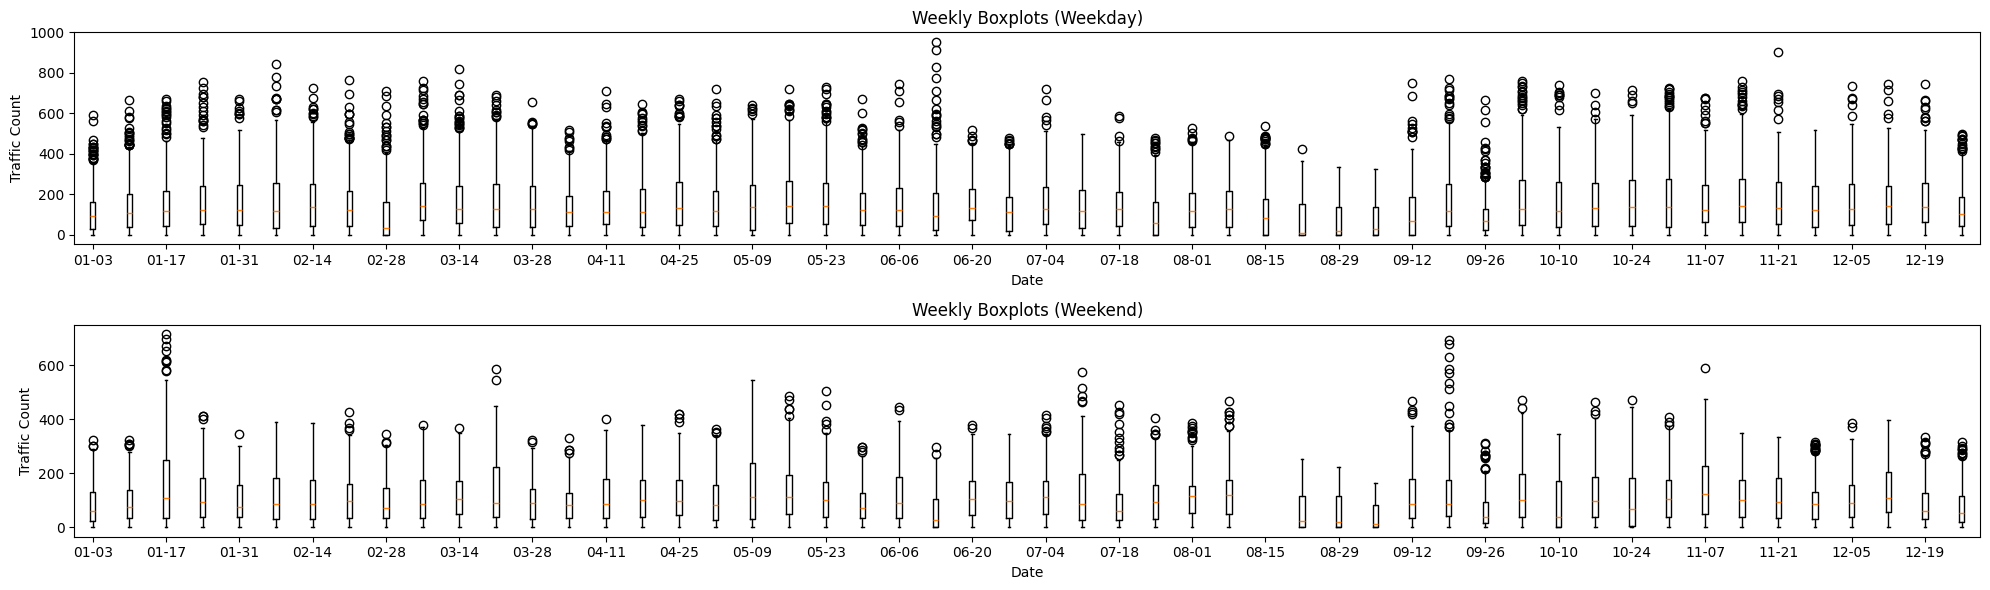

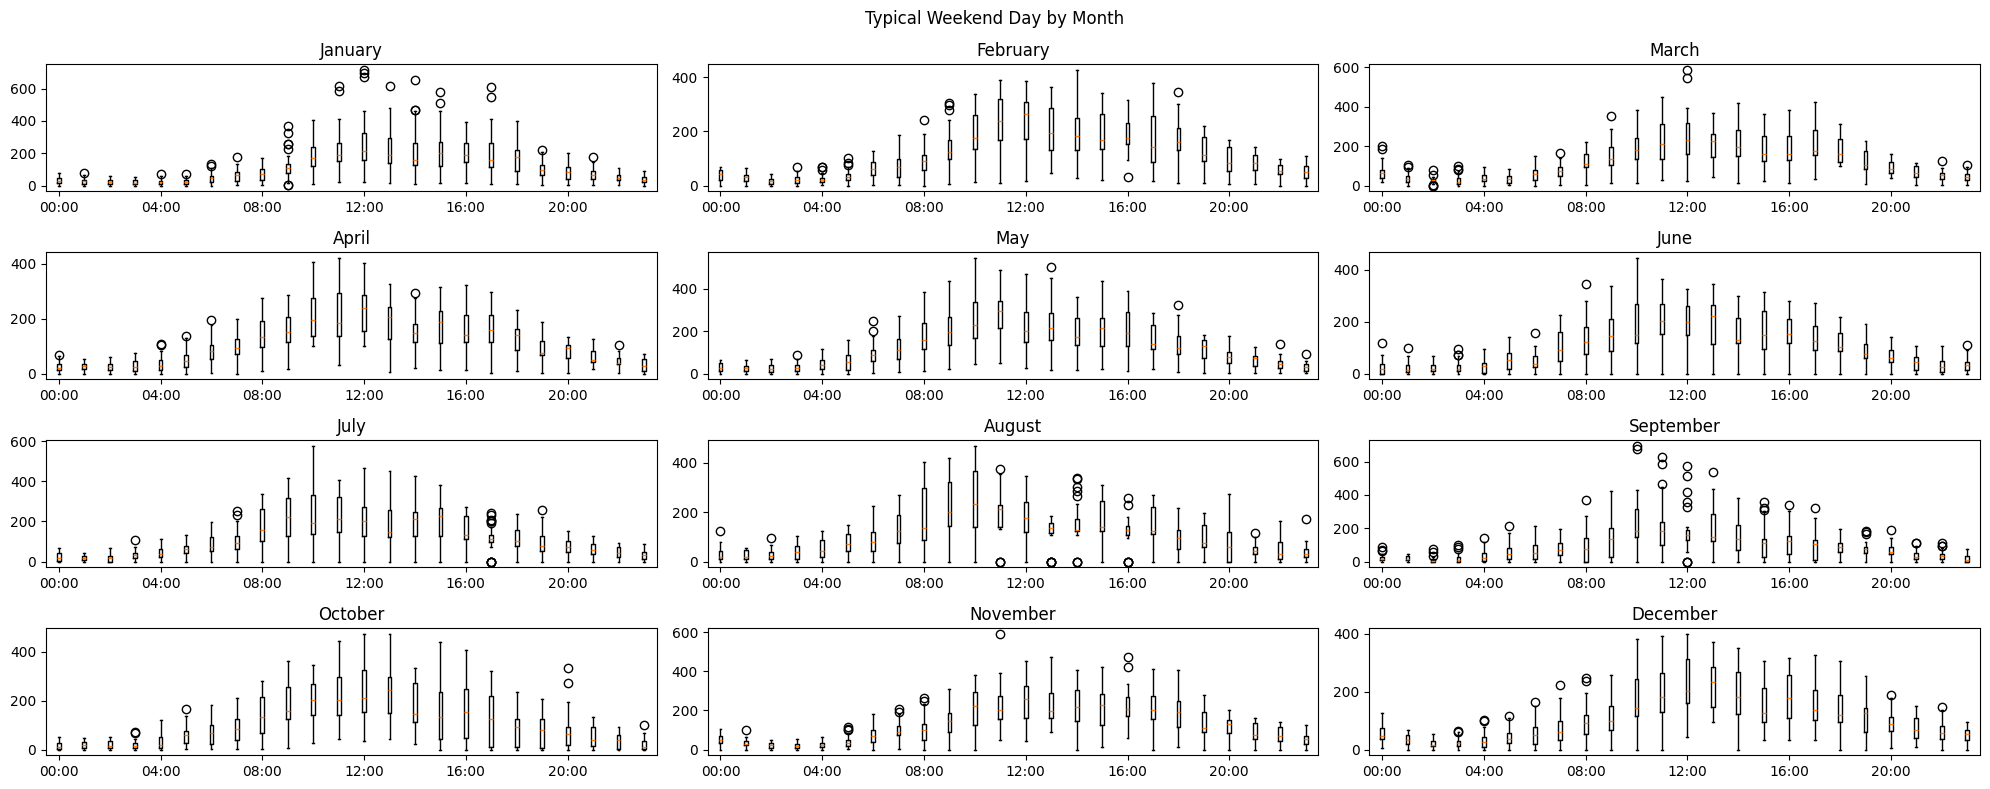

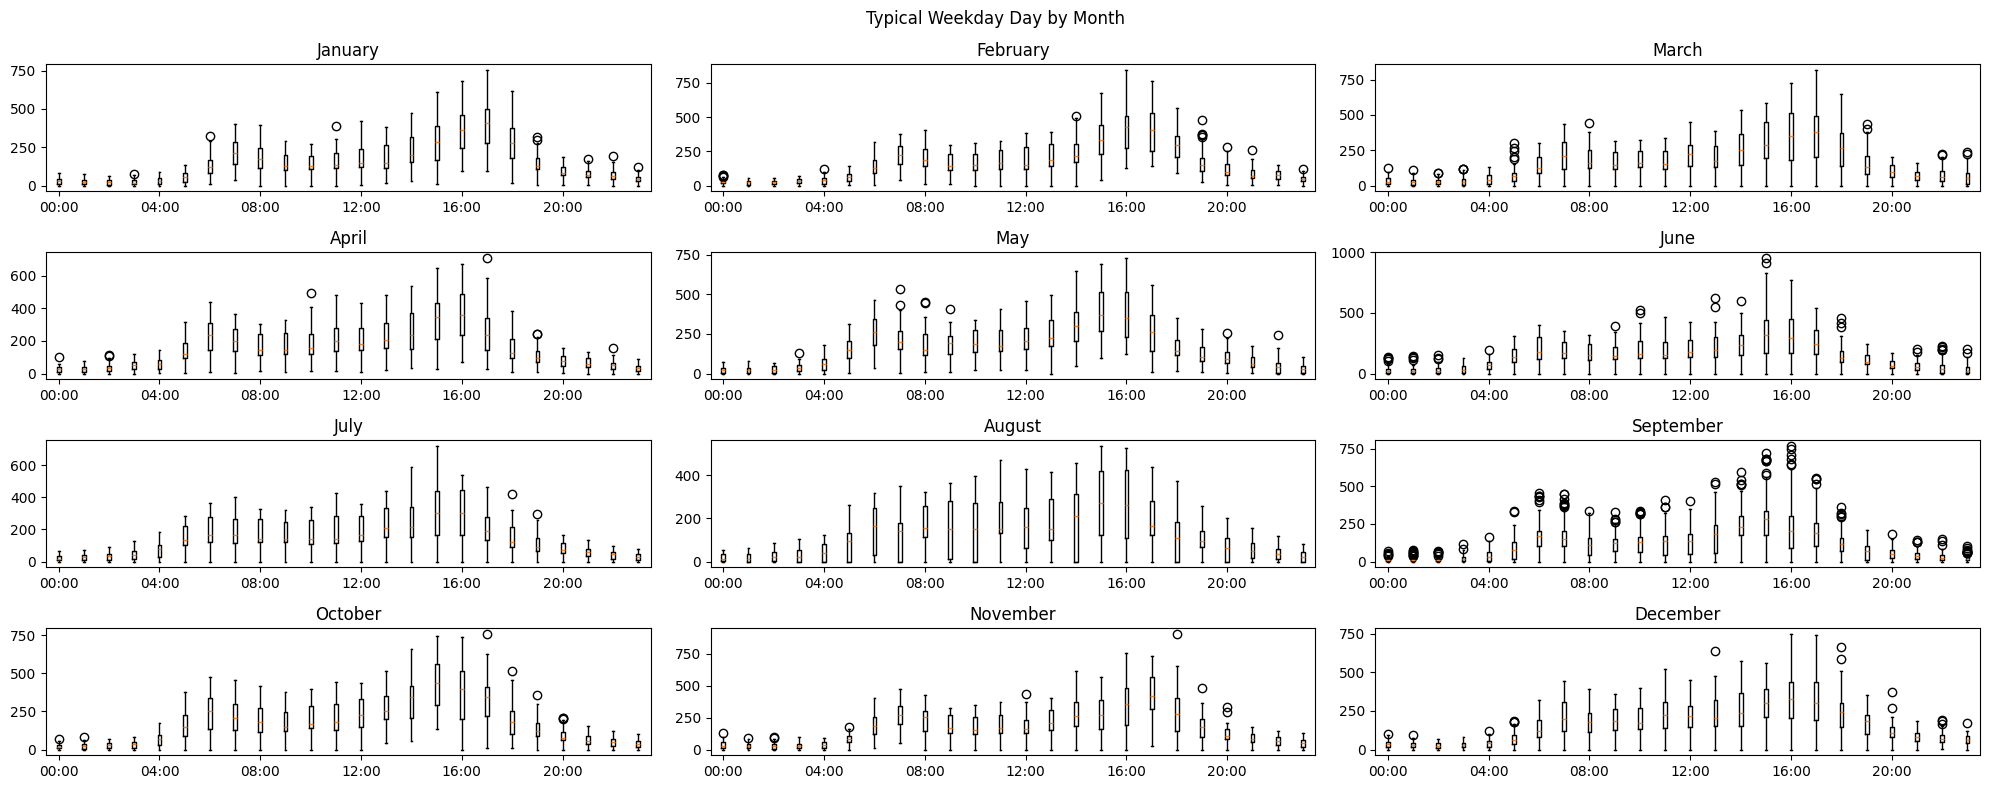

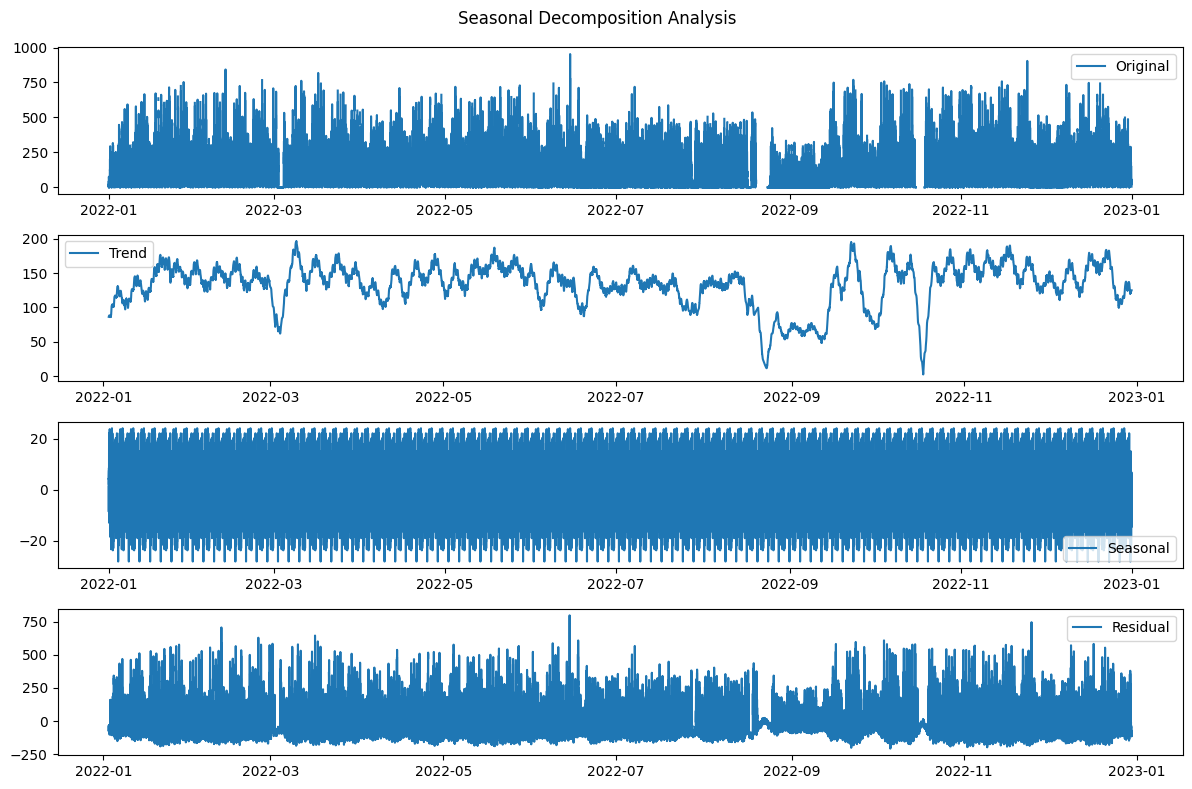

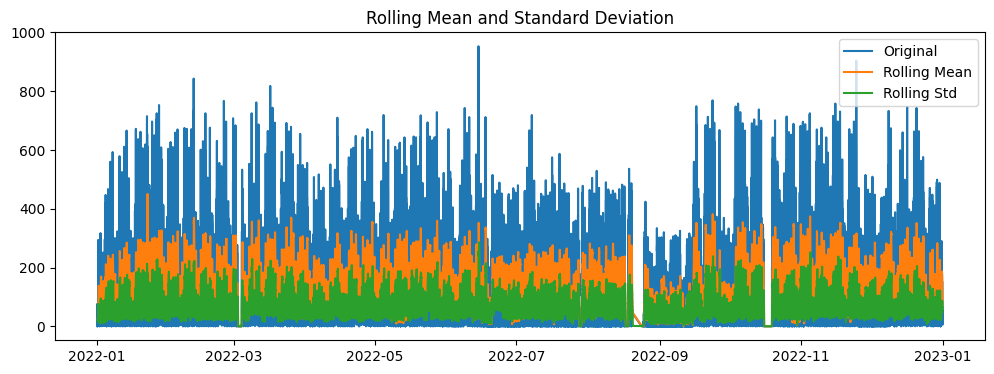

Augmented Dickey-Fuller Test:
Test Statistic: -31.129290218577953
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:355: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:364: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


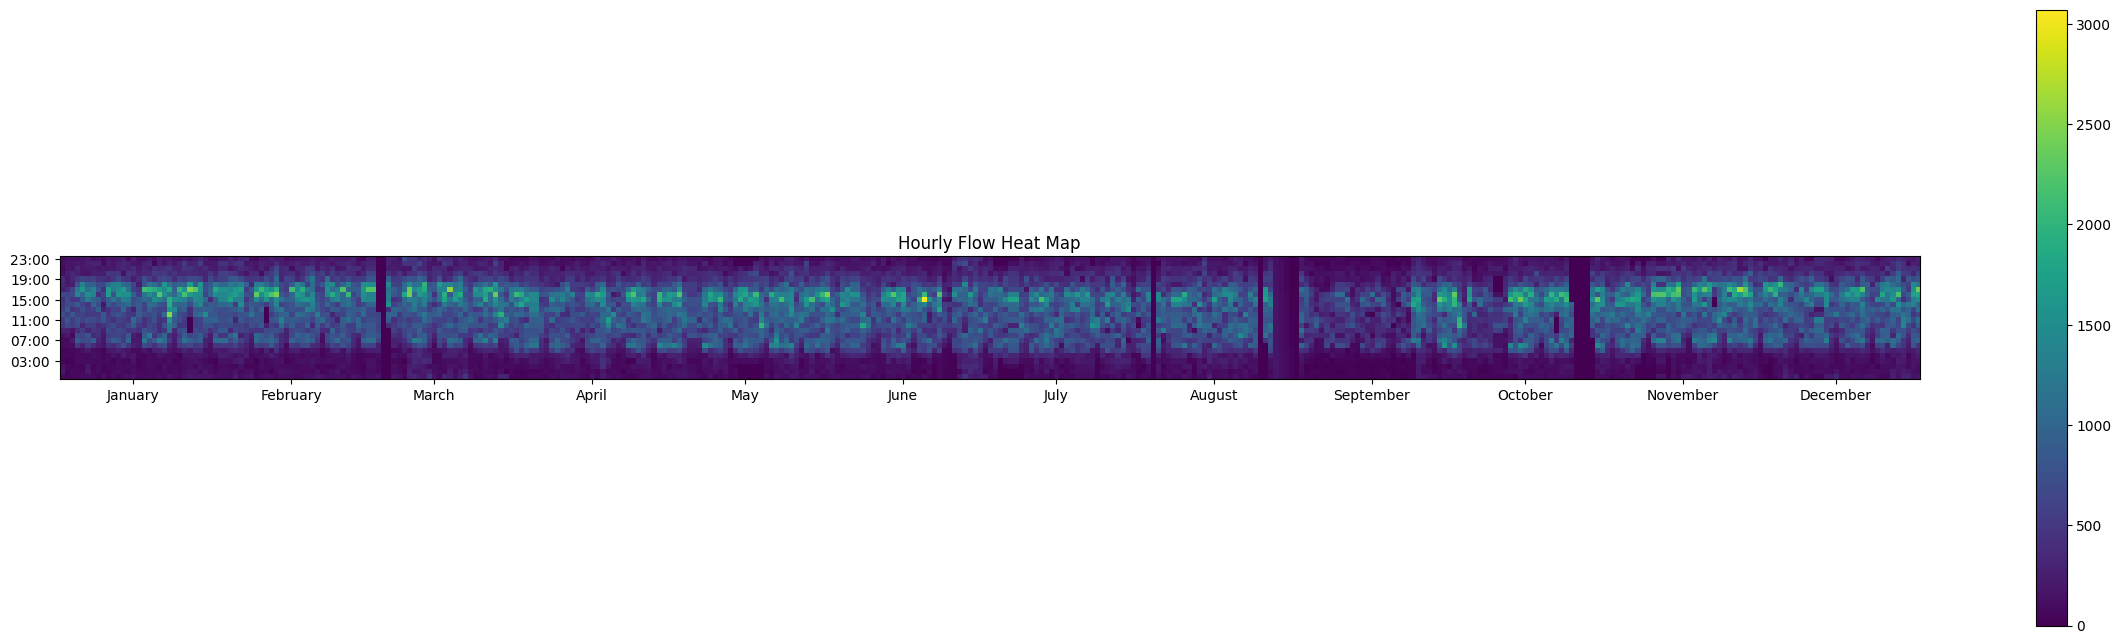

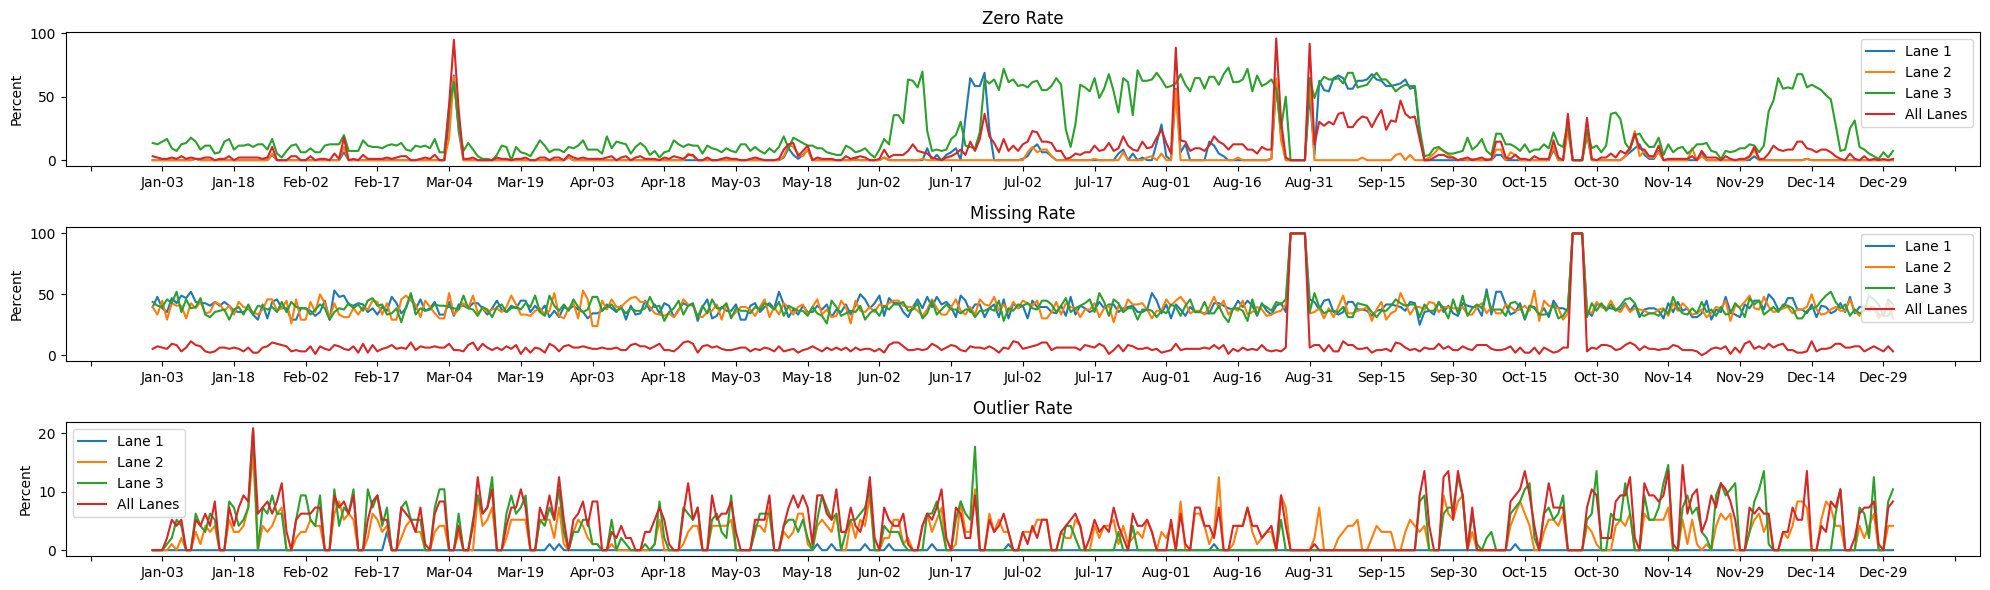

In [312]:
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_level_data[sensor_level_data['Data Quality Check']].index[-1],start_date,end_date,cursor)

## Route 2 Analysis - M2 / A2

### This route follows Medway -> Favershame -> Canterbury -> Dover
### Sensors very sparsely located except around Medway where very dense

### Data prep

In [313]:
#Read in sensors for A20 route

with open('Data/route2_a2.csv', newline='') as f:
    a2_sensors = f.read().splitlines()
print(a2_sensors)

['5993/1', '5823/1', '9949/3', 'M2/8844A', 'A2/8845A', 'M2/8815A', 'M2/8742A', 'M2/8643A', 'M2/8560A', 'M2/8565A', 'M2/8570A', 'M2/8575A', 'M2/8579A', '5845/2', 'M2/8534A', 'M2/8540A', 'M2/8545A', 'M2/8550A', 'M2/8555A', 'M2/8523A', 'M2/8497A', 'M2/8450A', 'M2/8441A', 'A2/8420A']


In [314]:
# Create a datetime index with 15-minute frequency
datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')

a2_ts_data_raw = pd.DataFrame(index = datetime_index, columns = a2_sensors)
a2_ts_data_int = pd.DataFrame(index = datetime_index, columns = a2_sensors)

for site in a2_sensors:
    ts, ts_all = get_ts(site,start_date,end_date,cursor)
    a2_ts_data_raw[site] = ts_all['All Lanes']
    a2_ts_data_int[site] = ts_all['All Lanes_interpolated']

/tmp/ipykernel_7350/3948439968.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:103: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

In [315]:
uk_bank_holidays_2022 = [
    '2022-01-01',  # New Year's Day (substitute day)
    '2022-04-15',  # Good Friday
    '2022-04-18',  # Easter Monday
    '2022-05-02',  # Early May Bank Holiday
    '2022-06-02',  # Spring Bank Holiday
    '2022-06-03',  # Platinum Jubilee Bank Holiday
    '2022-08-29',  # Summer Bank Holiday
    '2022-12-25',  # Christmas Day
    '2022-12-26',  # Boxing Day (substitute day)
]

day_lookup = pd.DataFrame(index = datetime_index)
day_lookup['bh'] = day_lookup.index.isin(pd.to_datetime(uk_bank_holidays_2022))

weekdays = []
weekends = []
for i,r in day_lookup.iterrows():
    if r['bh']:
        weekdays.append(False)
        weekends.append(False)        
    elif i.weekday() < 5:
        weekdays.append(True)
        weekends.append(False)
    else:
        weekdays.append(False)
        weekends.append(True)
        
day_lookup['wd'] = weekdays
day_lookup['we'] = weekends

In [316]:
dover = Point(1.313484253539137,51.123268155847605)
dover_node = ox.distance.nearest_nodes(G, dover.x, dover.y, return_dist=False)
sensor_level_data_list = []
route = 'route1'
sensor_num = 1

# Sensor to Sensor Matrix
s2s_time = np.zeros((len(a2_sensors),len(a2_sensors)))
s2s_corr_wd = np.zeros((len(a2_sensors),len(a2_sensors)))
s2s_corr_we = np.zeros((len(a2_sensors),len(a2_sensors)))
u_i = 0


for u in a2_sensors:
    
    sensor_level_append = {}
    sensor_level_append['sensor'] = u
    u_node = sensors_in_study[sensors_in_study['site_ID'] == u]['nearest node'].values[0]
    v_i = 0
    count_15 = 0
    count_30 = 0
    count_45 = 0
    count_60 = 0
    for v in a2_sensors:
        v_node = sensors_in_study[sensors_in_study['site_ID'] == v]['nearest node'].values[0]
        #SP
        travel_time = nx.dijkstra_path_length(G, u_node, v_node, weight='traversal_cost')
        #Correlation
        correlation_wd = np.corrcoef(a2_ts_data_int[u].loc[day_lookup[day_lookup['wd']].index],a2_ts_data_int[v].loc[day_lookup[day_lookup['wd']].index])
        correlation_we = np.corrcoef(a2_ts_data_int[u].loc[day_lookup[day_lookup['we']].index],a2_ts_data_int[v].loc[day_lookup[day_lookup['we']].index])
        #Append to matrix
        s2s_time[u_i,v_i] = travel_time
        s2s_corr_wd[u_i,v_i] = correlation_wd[0][1]
        s2s_corr_we[u_i,v_i] = correlation_we[0][1]
        
        if travel_time <= 15:
            count_15 += 1
        if travel_time <= 30:
            count_30 += 1
        if travel_time <= 45:
            count_45 += 1
        if travel_time <= 60:
            count_60 += 1
        v_i += 1
    
    sensor_level_append['Reachable 15'] = count_15
    sensor_level_append['Reachable 30'] = count_30
    sensor_level_append['Reachable 45'] = count_45
    sensor_level_append['Reachable 60'] = count_60
    
    #Dist to dover
    dist_to_dover = min(nx.dijkstra_path_length(G, u_node, dover_node, weight='traversal_cost'),nx.dijkstra_path_length(G, dover_node, u_node, weight='traversal_cost'))
    sensor_level_append['Time to Dover'] = dist_to_dover
    sensor_level_data_list.append(sensor_level_append)
    
    #Isocrone    
    
    #Get 15 min isochrone from sensor

    start_node = u_node
    max_travel_time = 15

    queue = [(0, start_node)]

    # Dictionary to store the cumulative travel time for each node
    travel_times = {node: float('inf') for node in G.nodes}
    travel_times[start_node] = 0

    while queue:
        current_time, current_node = heapq.heappop(queue)
        
        # Check if the current node has been reached within the allowed travel time
        if current_time > max_travel_time:
            print('Time over allowed traversal time')
            break
        
        for neighbor in G.neighbors(current_node):
            # Calculate the total travel time to the neighbor from the start node
            neighbor_time = current_time + G[current_node][neighbor][0]['traversal_cost']
            
            # Update the travel time if it's smaller than the current recorded time
            if neighbor_time < travel_times[neighbor]:
                travel_times[neighbor] = neighbor_time
                heapq.heappush(queue, (neighbor_time, neighbor))
                
    isocrone = node_attributes.loc[[node for node, time in travel_times.items() if time <= max_travel_time]]
    isocrone['travel time'] = isocrone.index.map(travel_times)

    isocrone_gdf = GeoDataFrame(isocrone, crs="EPSG:4326", geometry=isocrone['geometry'])
    isocrone_gdf.to_file("Data/route1/isochrone_{}_{}.json".format(route,sensor_num), driver="GeoJSON")
    
    sensor_num += 1
    u_i += 1
    
sensor_level_data = pd.DataFrame(sensor_level_data_list)
sensor_level_data = sensor_level_data.set_index('sensor')

/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/chris/miniconda3/envs/ad-sim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Time over allowed traversal time
Time over allowed traversal time


### Analysis 1 - Data quality tests across all sensors

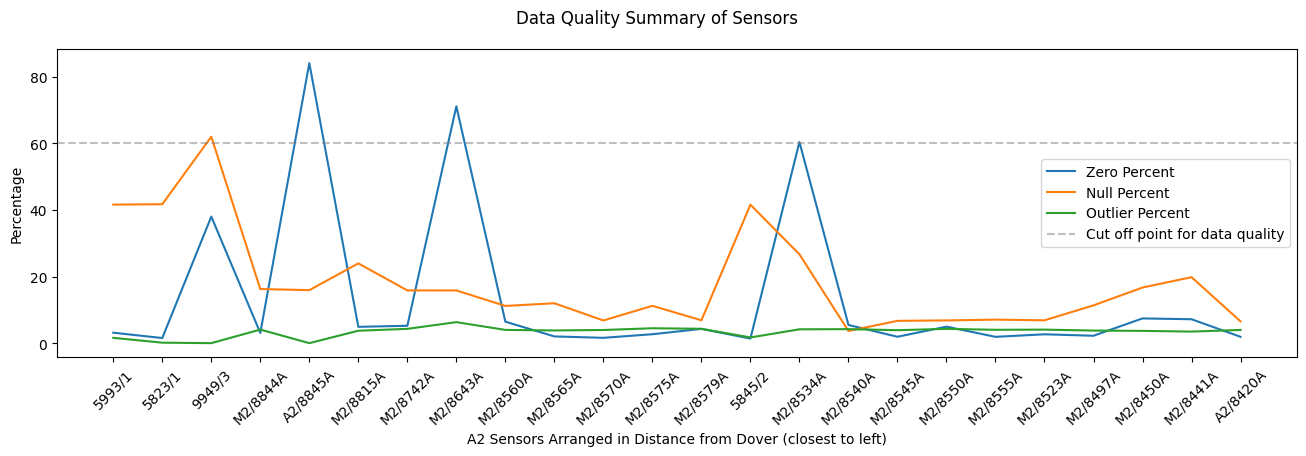

In [318]:
plot_quality_list = []

for col in a2_ts_data_raw.columns:
    sensor_data = a2_ts_data_raw[col]
    
    mean_value = sensor_data.mean()
    std_dev = sensor_data.std()

    plot_append = {}
    
    plot_append['Sensor'] = col
    plot_append['Zero Percent'] = ((sensor_data == 0).sum() / len(sensor_data)) * 100
    plot_append['Null Percent'] = (sensor_data.isnull().sum() / len(sensor_data)) * 100
    plot_append['Outlier Percent'] = (((sensor_data > mean_value + 2 * std_dev) | (sensor_data < mean_value - 2 * std_dev)).sum()) / len(sensor_data) * 100
    plot_quality_list.append(plot_append)

a2_sensor_quality = pd.DataFrame(plot_quality_list).set_index('Sensor')

# Sensor on x axis
# Percentage on y axis
# Three lines (missing, zeros, outliers)

fig, ax = plt.subplots(1,1, figsize = [16,4])
a2_sensor_quality.plot(ax = ax)
ax.set_xticks(range(len(list(a2_sensor_quality.index))),list(a2_sensor_quality.index), rotation=45)
ax.axhline(y=60, color='gray', linestyle='--', alpha=0.5, label = 'Cut off point for data quality')
ax.set_xlabel('A2 Sensors Arranged in Distance from Dover (closest to left)')
ax.set_ylabel('Percentage')
plt.suptitle('Data Quality Summary of Sensors')
plt.legend()
plt.show()

#### Key findings

- Nearby sensors to Dover tend to have poorer data quality

In [319]:
#Add data quality flag

good_sensors = []

for i,r in a2_sensor_quality.iterrows():
    if (r['Zero Percent'] > 60) or (r['Null Percent'] > 60):
        good_sensors.append(False)
    else:
        good_sensors.append(True)

sensor_level_data['Data Quality Check'] = good_sensors

### Analysis 2 - Observe evoluation of traffic along road

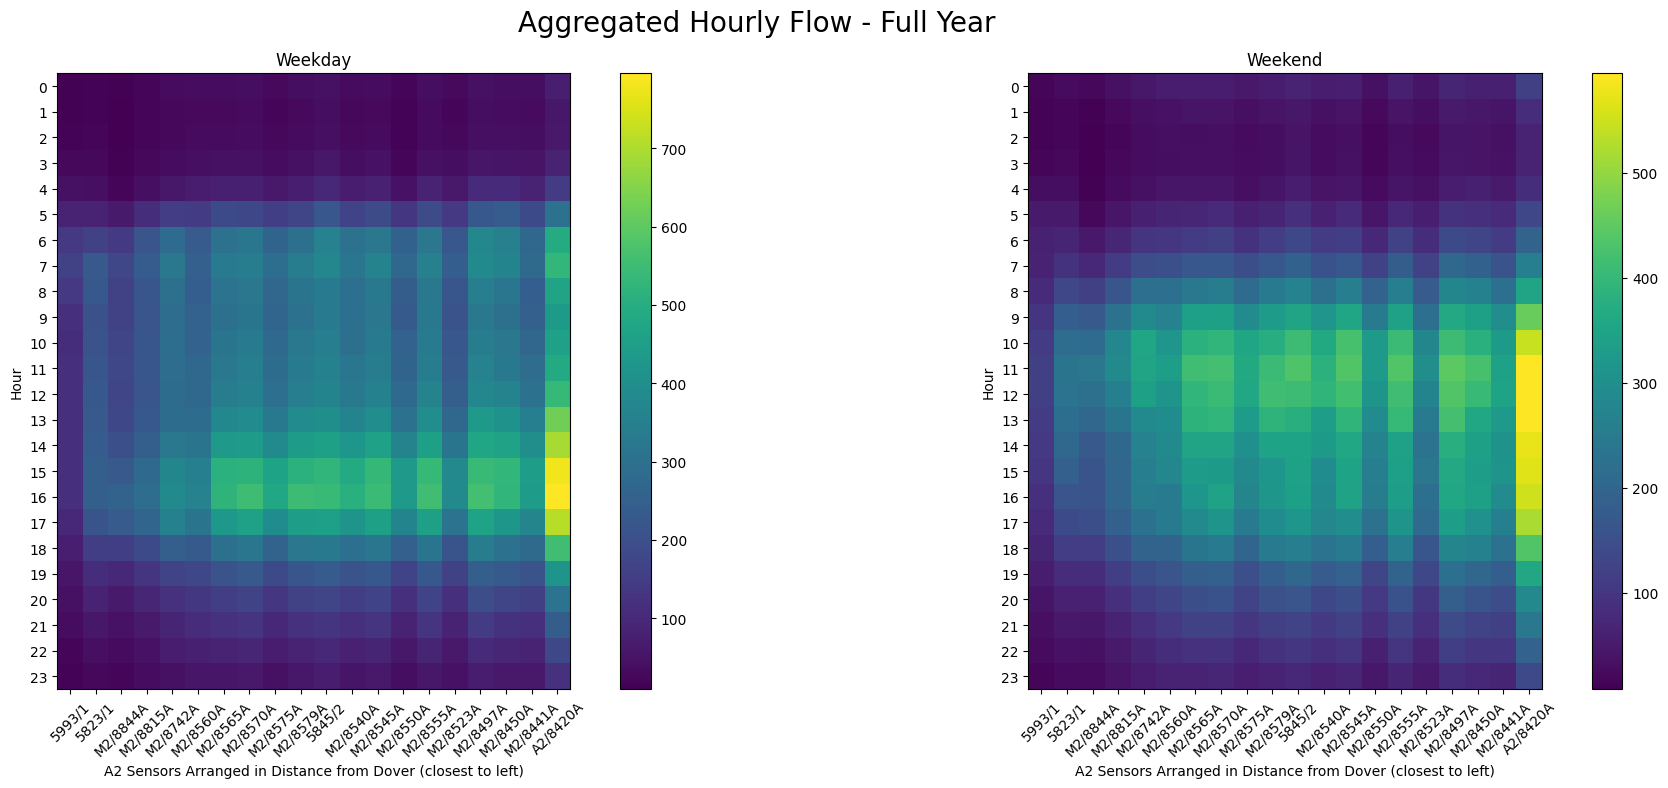

In [321]:
# Yearly weekday
quality_sensors = a2_ts_data_int[list(sensor_level_data[sensor_level_data['Data Quality Check']].index)]
#Get Weekday Readings
weekday_readings = quality_sensors.loc[day_lookup[day_lookup['wd']].index]
hourly_mean_weekday = weekday_readings.groupby(weekday_readings.index.hour).mean()
#Get Weekend Readings
weekend_readings = quality_sensors.loc[day_lookup[day_lookup['we']].index]
hourly_mean_weekend = weekend_readings.groupby(weekend_readings.index.hour).mean()

# Specify the size of the plot using figsize
fig, ax = plt.subplots(1,2,figsize=(20, 8))

#Weekday Plot
im = ax[0].imshow(hourly_mean_weekday.values, cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=ax[0]) 
ax[0].set_xticks(list(range(len(list(hourly_mean_weekday.columns)))),list(hourly_mean_weekday.columns), rotation=45)
ax[0].set_yticks(range(24),range(24))
ax[0].set_ylabel('Hour')
ax[0].set_xlabel('A2 Sensors Arranged in Distance from Dover (closest to left)')
ax[0].set_title('Weekday')

#Weekend Plot
im = ax[1].imshow(hourly_mean_weekend.values, cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=ax[1]) 
ax[1].set_xticks(range(len(list(hourly_mean_weekend.columns))),list(hourly_mean_weekend.columns), rotation=45)
ax[1].set_yticks(range(24),range(24))
ax[1].set_ylabel('Hour')
ax[1].set_xlabel('A2 Sensors Arranged in Distance from Dover (closest to left)')
ax[1].set_title('Weekend')

plt.suptitle('Aggregated Hourly Flow - Full Year',fontsize = 20)

plt.tight_layout()
plt.show()

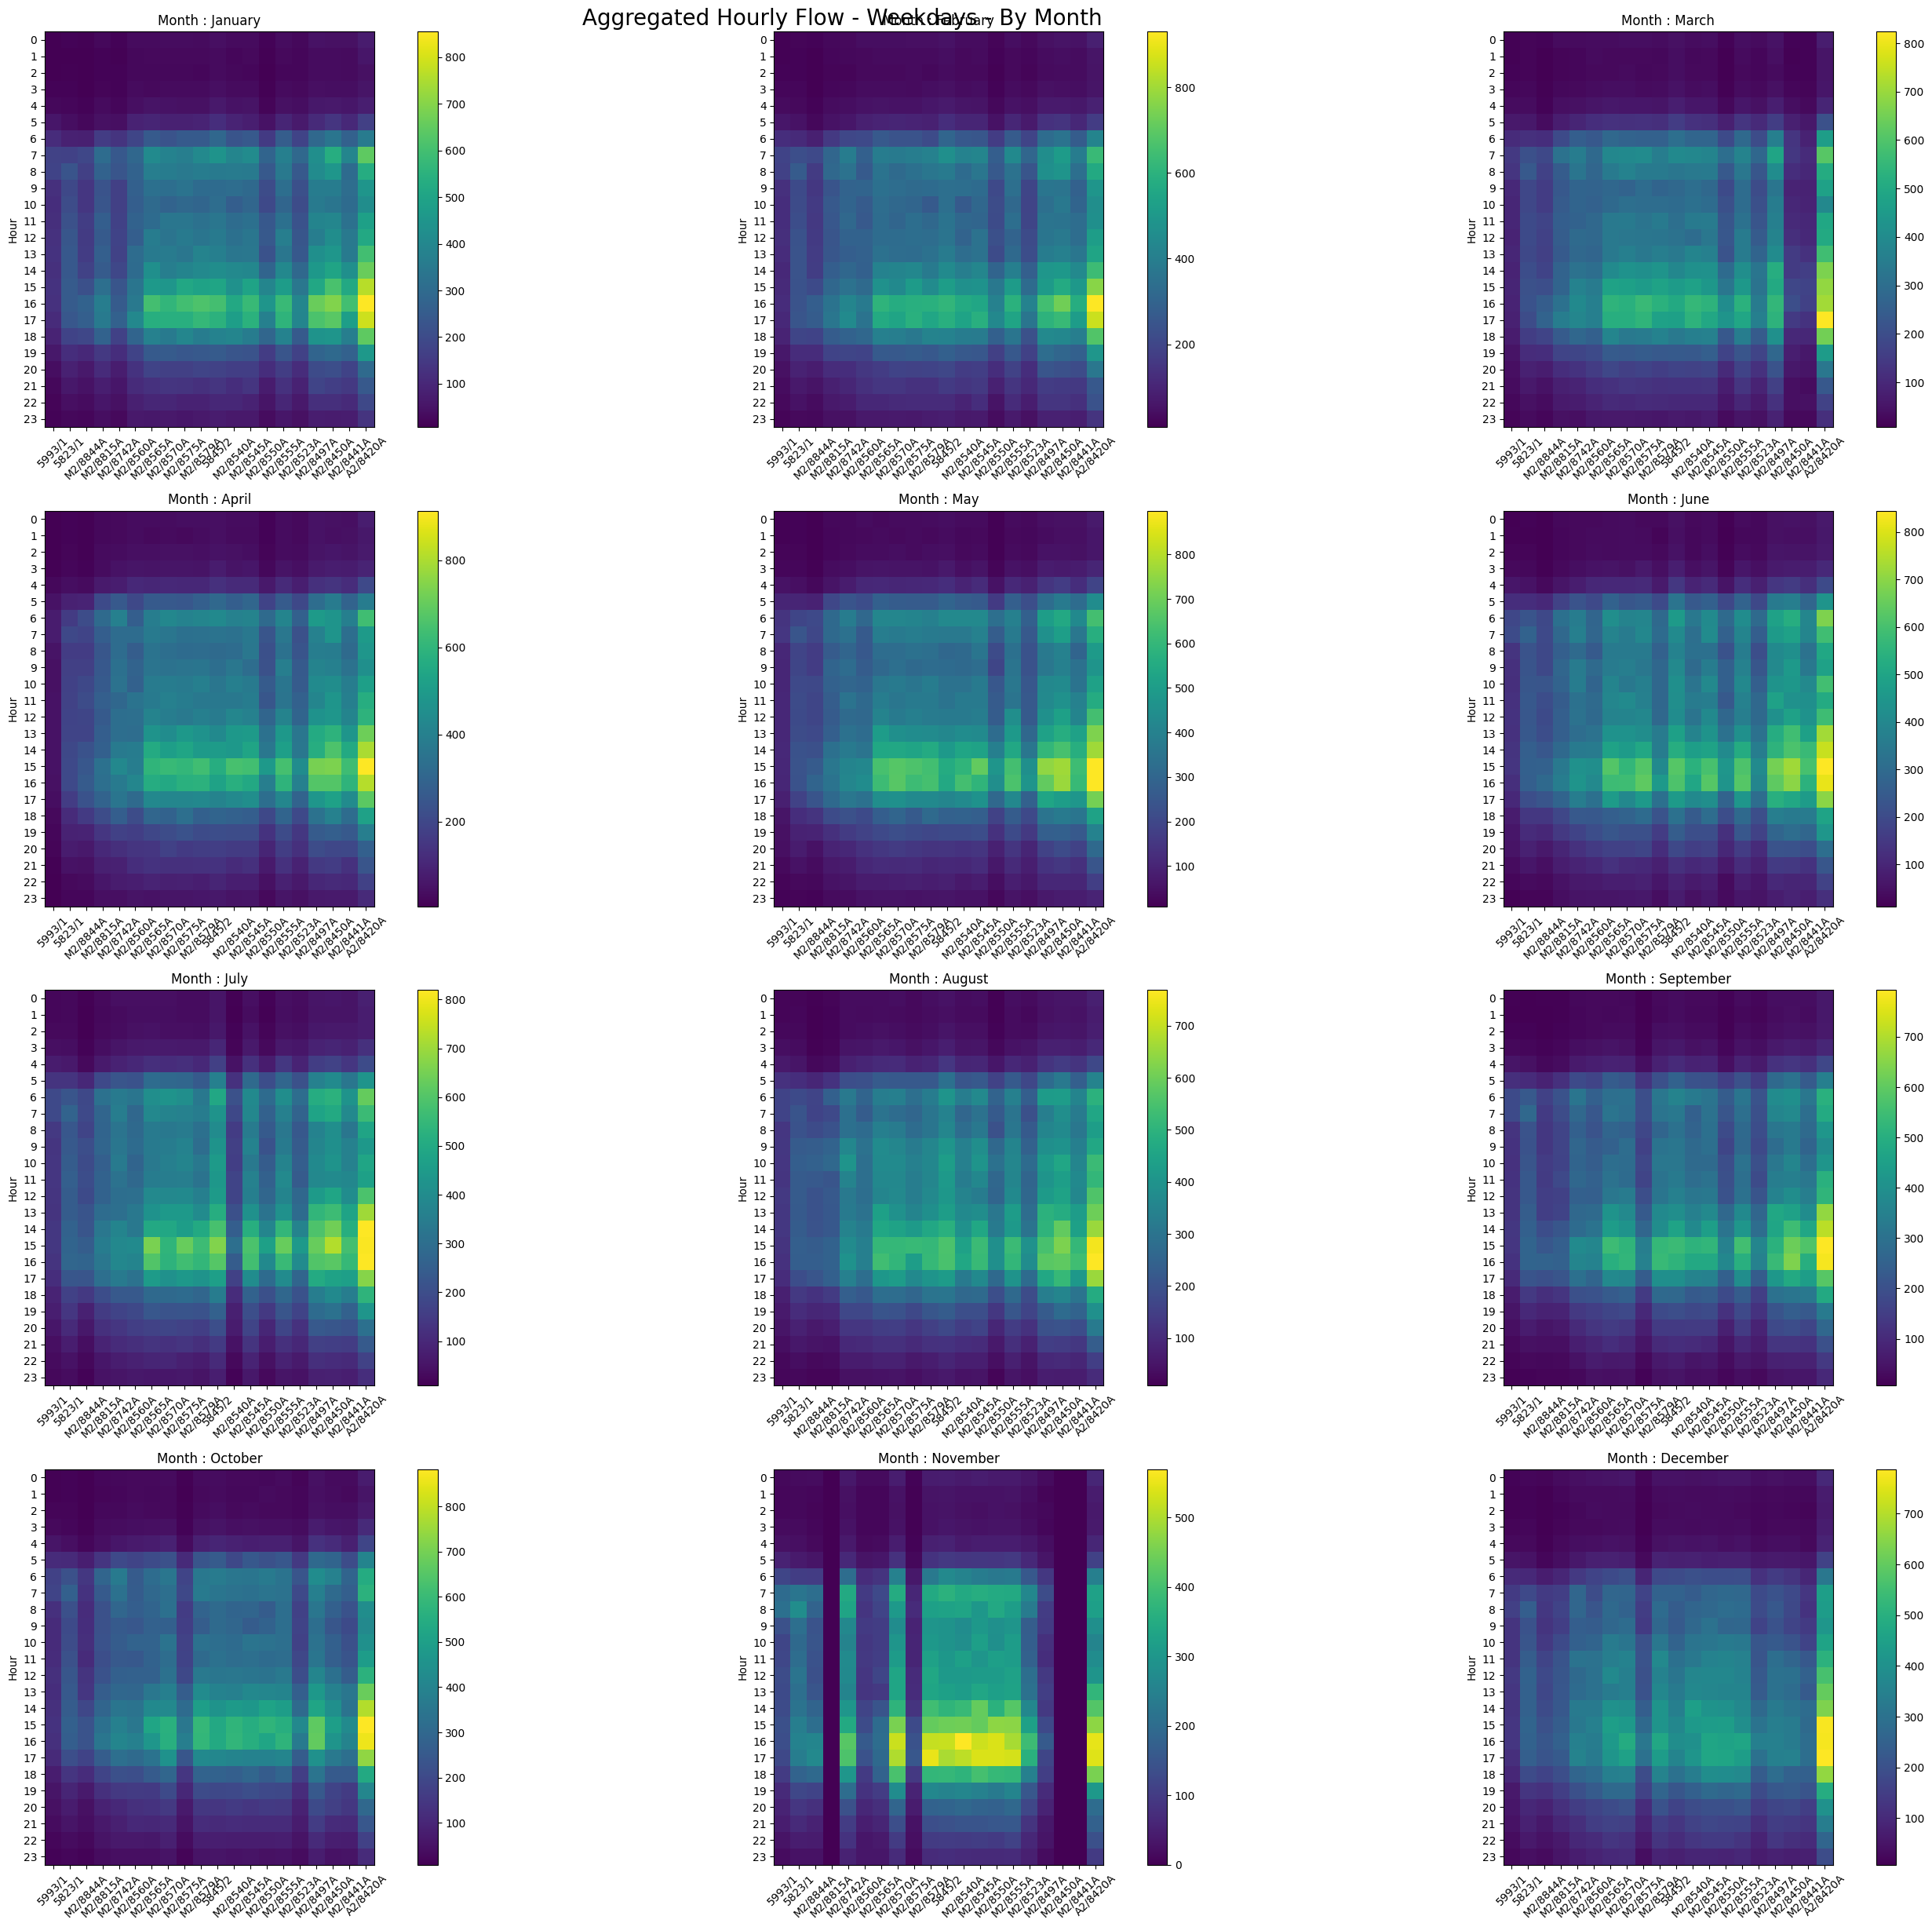

In [323]:
#Weekday

# Yearly weekday

quality_sensors = a2_ts_data_int[list(sensor_level_data[sensor_level_data['Data Quality Check']].index)]
#Get Weekday Readings
weekday_readings = quality_sensors.loc[day_lookup[day_lookup['wd']].index]


fig, ax = plt.subplots(4,3,figsize=(30, 25))

ax_across = 0
ax_down = 0

for m in range(1,13):

    month_data = weekday_readings[weekday_readings.index.month == m].groupby(weekday_readings[weekday_readings.index.month == m].index.hour).mean()

    #Weekday Plot
    im = ax[ax_down,ax_across].imshow(month_data.values, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax[ax_down,ax_across]) 
    ax[ax_down,ax_across].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
    ax[ax_down,ax_across].set_yticks(range(24),range(24))
    ax[ax_down,ax_across].set_ylabel('Hour')
    ax[ax_down,ax_across].set_title('Month : {}'.format(month_label[m]))
    
    if ax_across < 2:
        ax_across += 1
    else:
        ax_across = 0
        ax_down += 1


plt.suptitle('Aggregated Hourly Flow - Weekdays - By Month', fontsize = 20)
plt.tight_layout()  
plt.show()

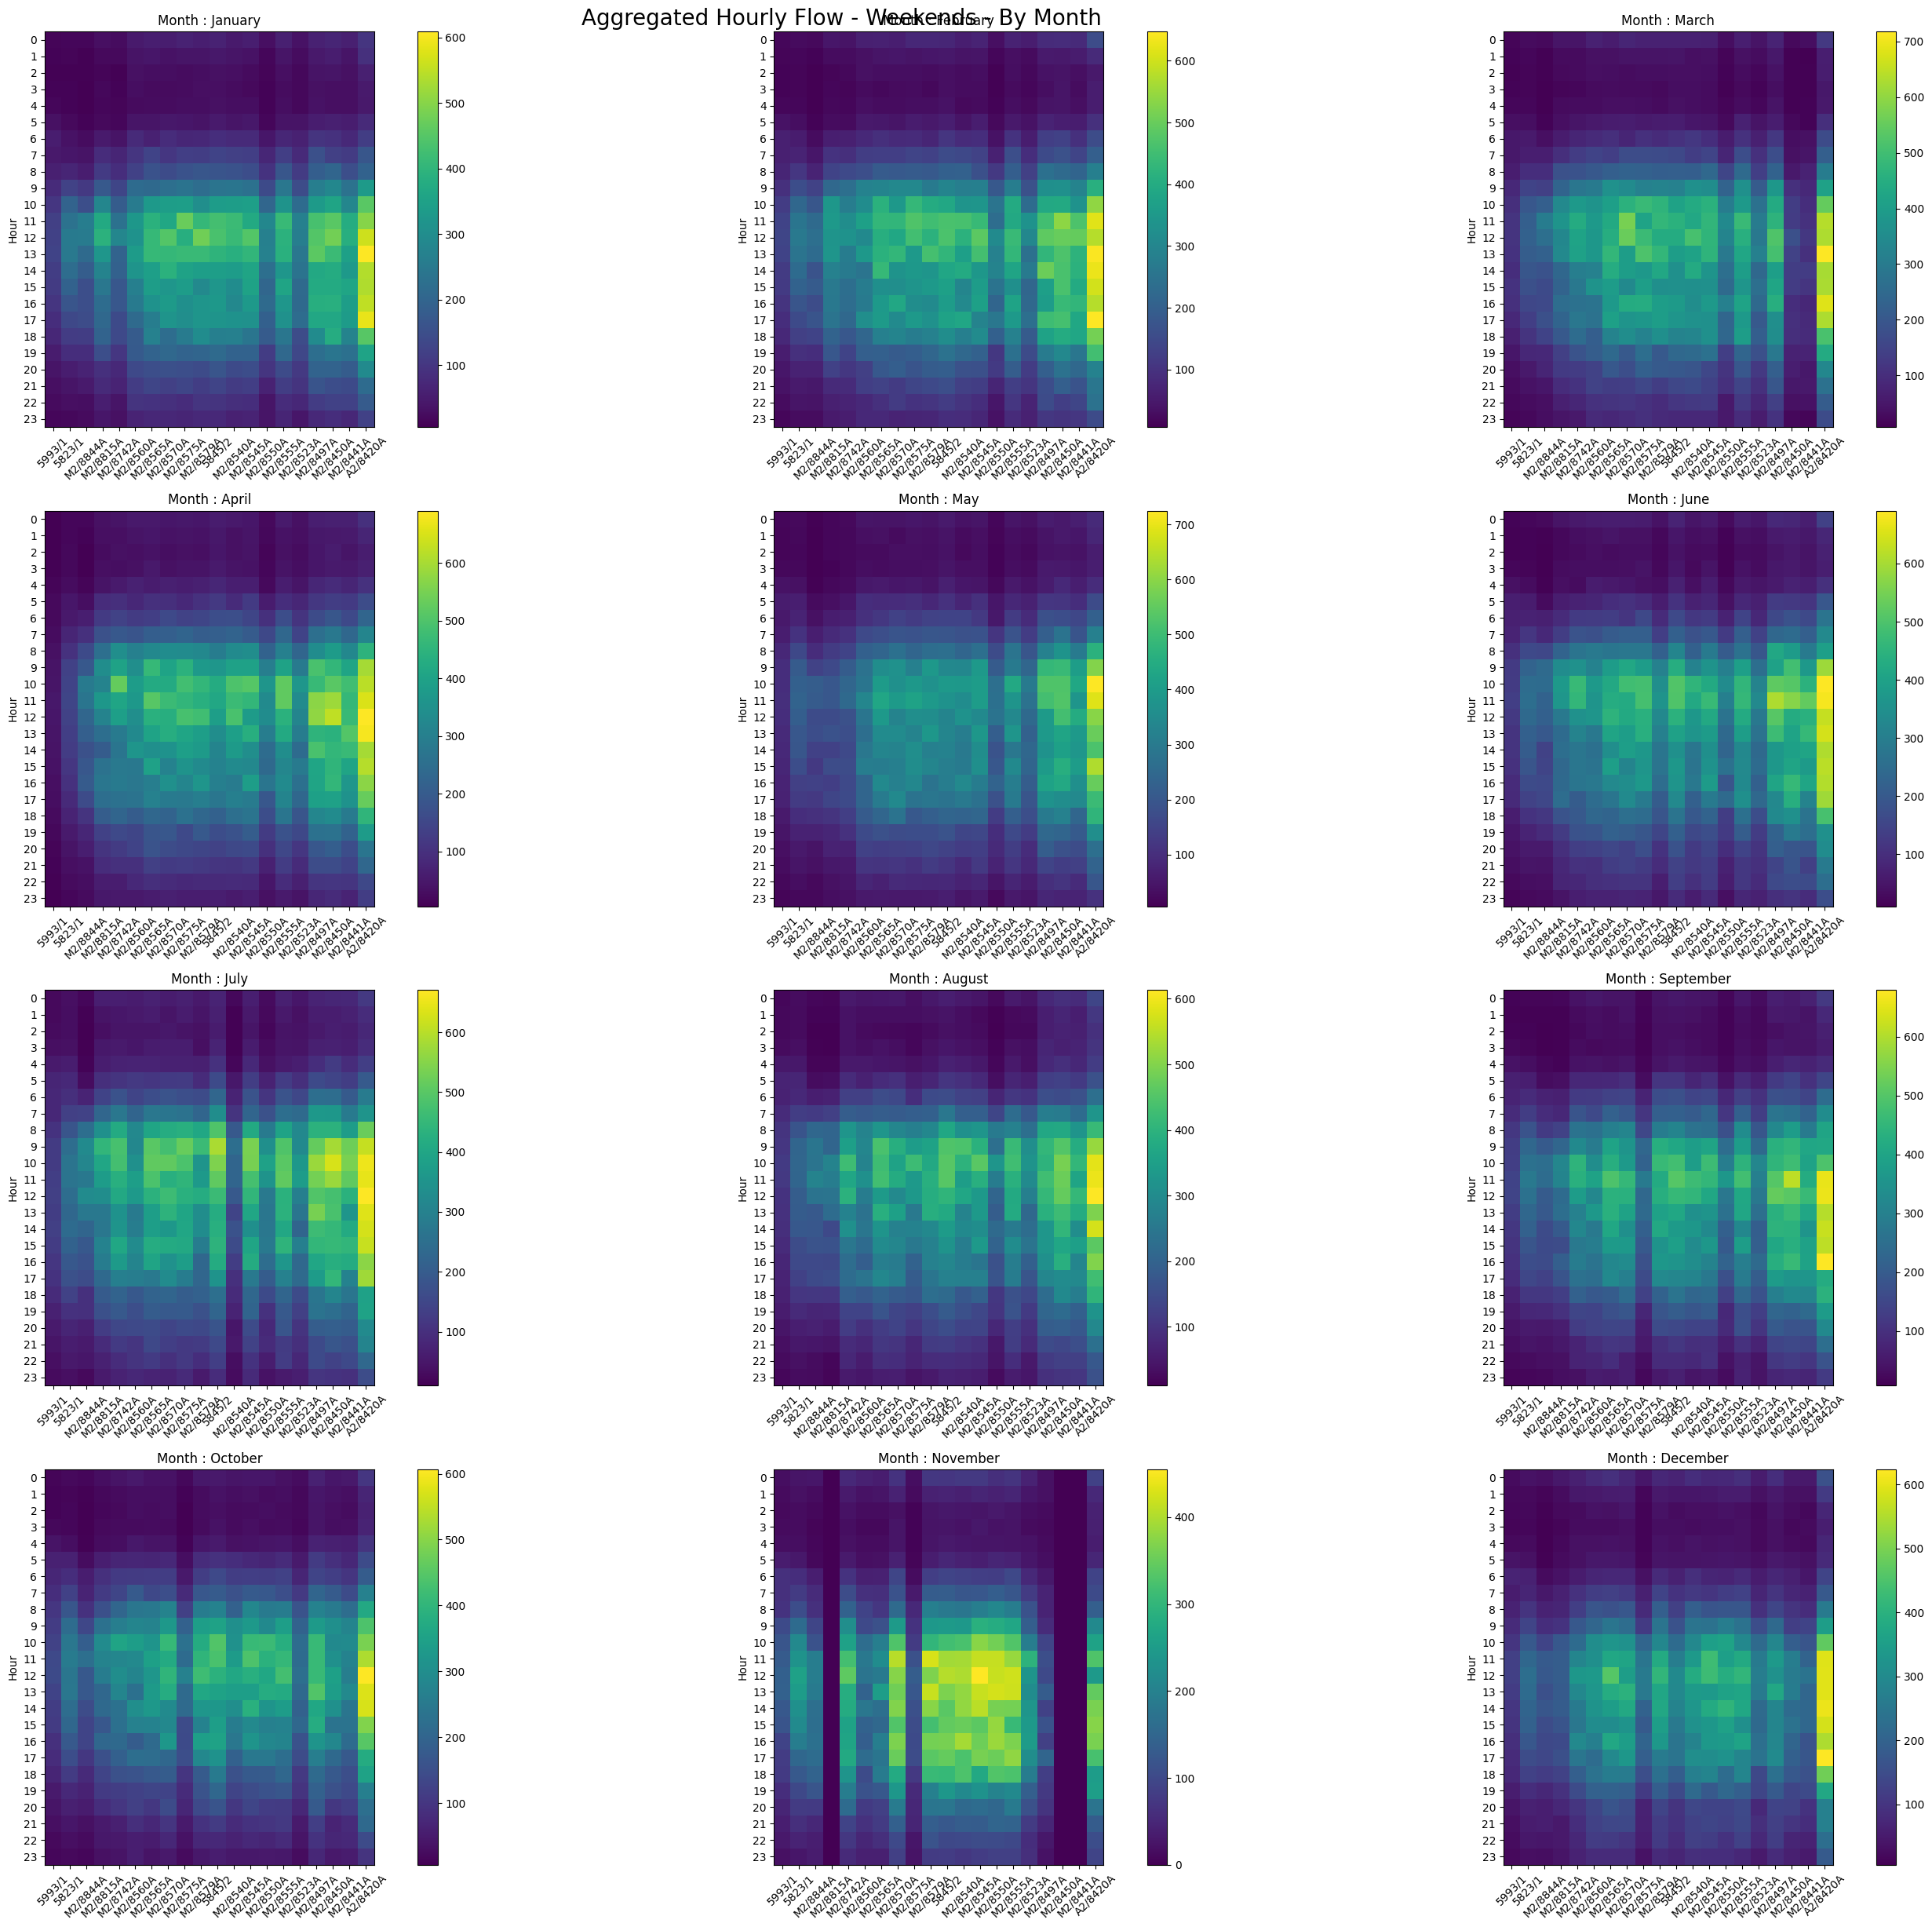

In [325]:
#Weekday

# Yearly weekday
quality_sensors = a2_ts_data_int[list(sensor_level_data[sensor_level_data['Data Quality Check']].index)]
#Get Weekday Readings
weekend_readings = quality_sensors.loc[day_lookup[day_lookup['we']].index]

fig, ax = plt.subplots(4,3,figsize=(30, 25))

ax_across = 0
ax_down = 0

for m in range(1,13):

    month_data = weekend_readings[weekend_readings.index.month == m].groupby(weekend_readings[weekend_readings.index.month == m].index.hour).mean()

    #Weekday Plot
    im = ax[ax_down,ax_across].imshow(month_data.values, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax[ax_down,ax_across]) 
    ax[ax_down,ax_across].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
    ax[ax_down,ax_across].set_yticks(range(24),range(24))
    ax[ax_down,ax_across].set_ylabel('Hour')
    ax[ax_down,ax_across].set_title('Month : {}'.format(month_label[m]))
    
    if ax_across < 2:
        ax_across += 1
    else:
        ax_across = 0
        ax_down += 1

plt.suptitle('Aggregated Hourly Flow - Weekends - By Month', fontsize = 20)
plt.tight_layout()  
plt.show()

### Analysis 3 - Spatial Correlation Analysis

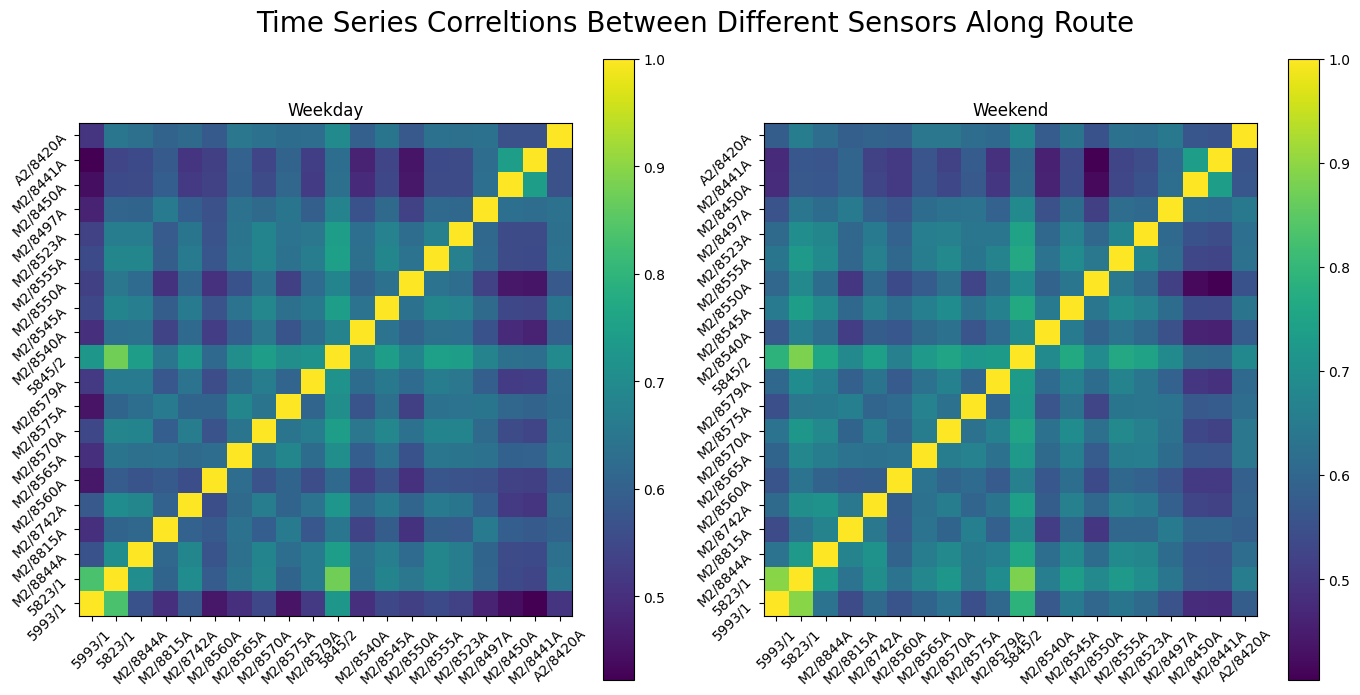

In [327]:
mask = list(sensor_level_data['Data Quality Check'])

fig, ax = plt.subplots(1,2,figsize=(14, 7))

# Weekday
# Create a heatmap with nan values greyed out
im = ax[0].imshow(np.flip(s2s_corr_wd[mask, :][:, mask], axis = 0), cmap='viridis', interpolation='none')
# Add colorbar
plt.colorbar(im, ax=ax[0]) 
ax[0].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax[0].set_yticks(list(range(len(list(month_data.columns)))),list(month_data.columns)[::-1], rotation=45)
ax[0].set_title('Weekday')

# Weekend
# Create a heatmap with nan values greyed out
im = ax[1].imshow(np.flip(s2s_corr_we[mask, :][:, mask], axis = 0), cmap='viridis', interpolation='none')
# Add colorbar
plt.colorbar(im, ax=ax[1]) 
ax[1].set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax[1].set_yticks(list(range(len(list(month_data.columns)))),list(month_data.columns)[::-1], rotation=45)
ax[1].set_title('Weekend')

plt.suptitle('Time Series Correltions Between Different Sensors Along Route', fontsize = 20)

plt.tight_layout()
# Show the plot
plt.show()

### Analysis 4 - Travel Time Analysis

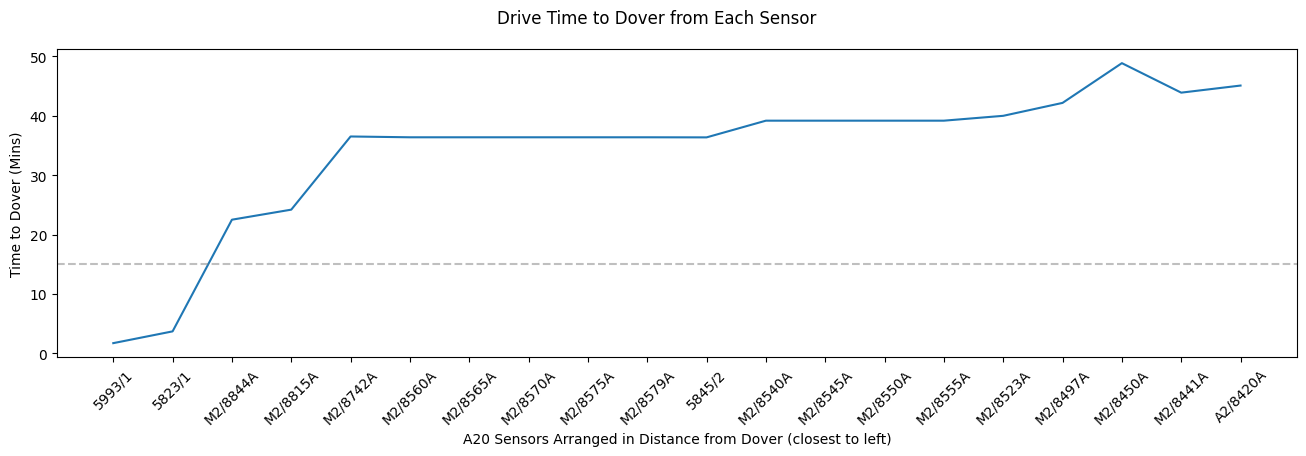

In [328]:
#Travel time to Dover

fig, ax = plt.subplots(1,1, figsize = [16,4])

sensor_level_data[sensor_level_data['Data Quality Check']]['Time to Dover'].plot(ax = ax)
ax.set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax.axhline(y=15, color='gray', linestyle='--', alpha=0.5, label = 'Cut off point for data quality')
ax.set_xlabel('A20 Sensors Arranged in Distance from Dover (closest to left)')
ax.set_ylabel('Time to Dover (Mins)')
plt.suptitle('Drive Time to Dover from Each Sensor')
plt.show()

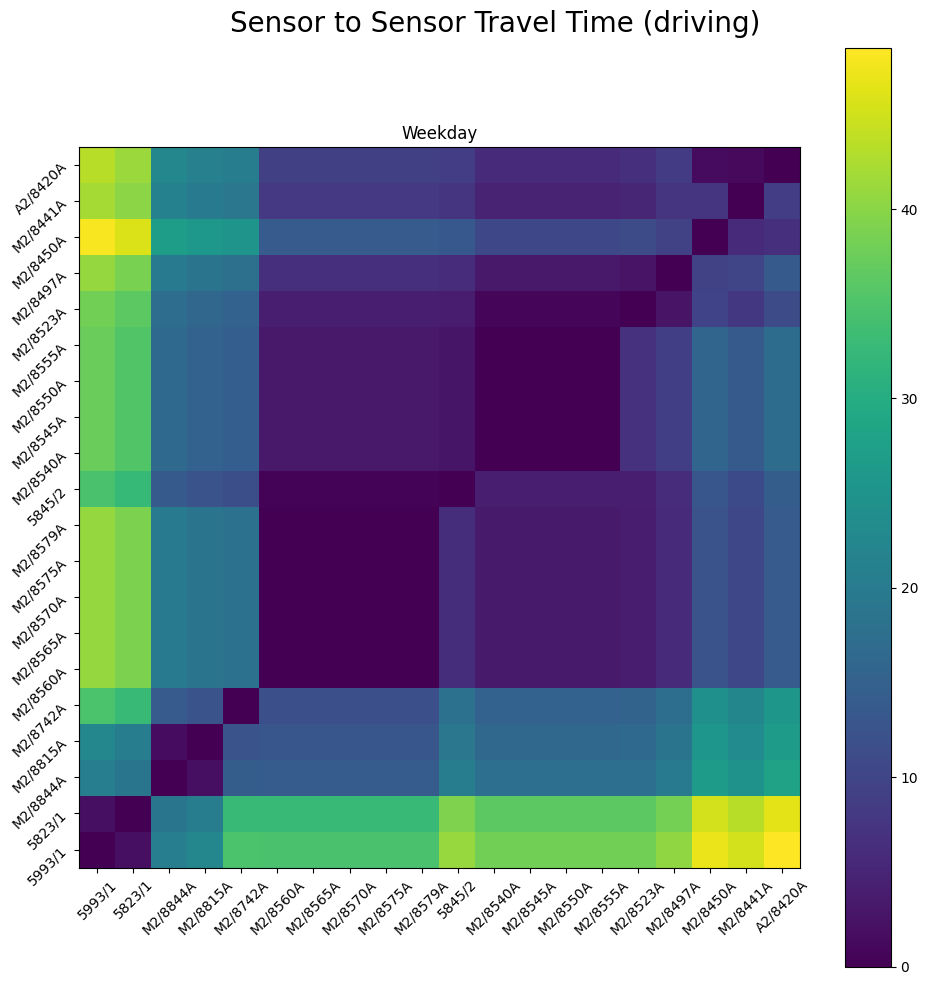

In [329]:
#Travel time cube

fig, ax = plt.subplots(figsize=(10, 10))

# Weekday
# Create a heatmap with nan values greyed out
im = ax.imshow(np.flip(s2s_time[mask, :][:, mask], axis = 0), cmap='viridis', interpolation='none')
# Add colorbar
plt.colorbar(im, ax=ax) 
ax.set_xticks(list(range(len(list(month_data.columns)))),list(month_data.columns), rotation=45)
ax.set_yticks(list(range(len(list(month_data.columns)))),list(month_data.columns)[::-1], rotation=45)
ax.set_title('Weekday')

plt.suptitle('Sensor to Sensor Travel Time (driving)', fontsize = 20)

plt.tight_layout()
# Show the plot
plt.show()

### Analysis 5.1 - Time Series Analysis of Crucial Sensor (sensor closest to Dover)

-----------------
Next Columns : Lane 1
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 1101
Rate of zeros : 3.1%
Count of nulls : 14577
Rate of nulls : 41.6%
Count of outliers : 557
Rate of outliers : 1.6%
-----------------




/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:164: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


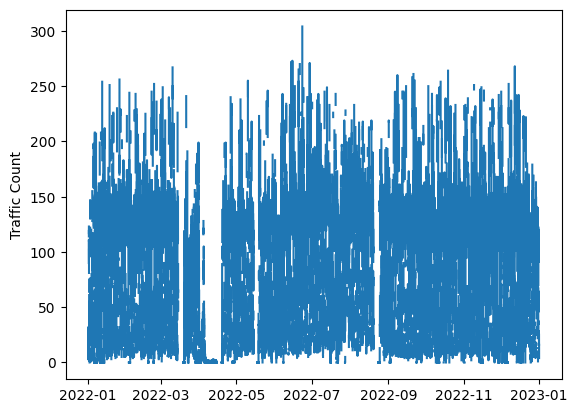

/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

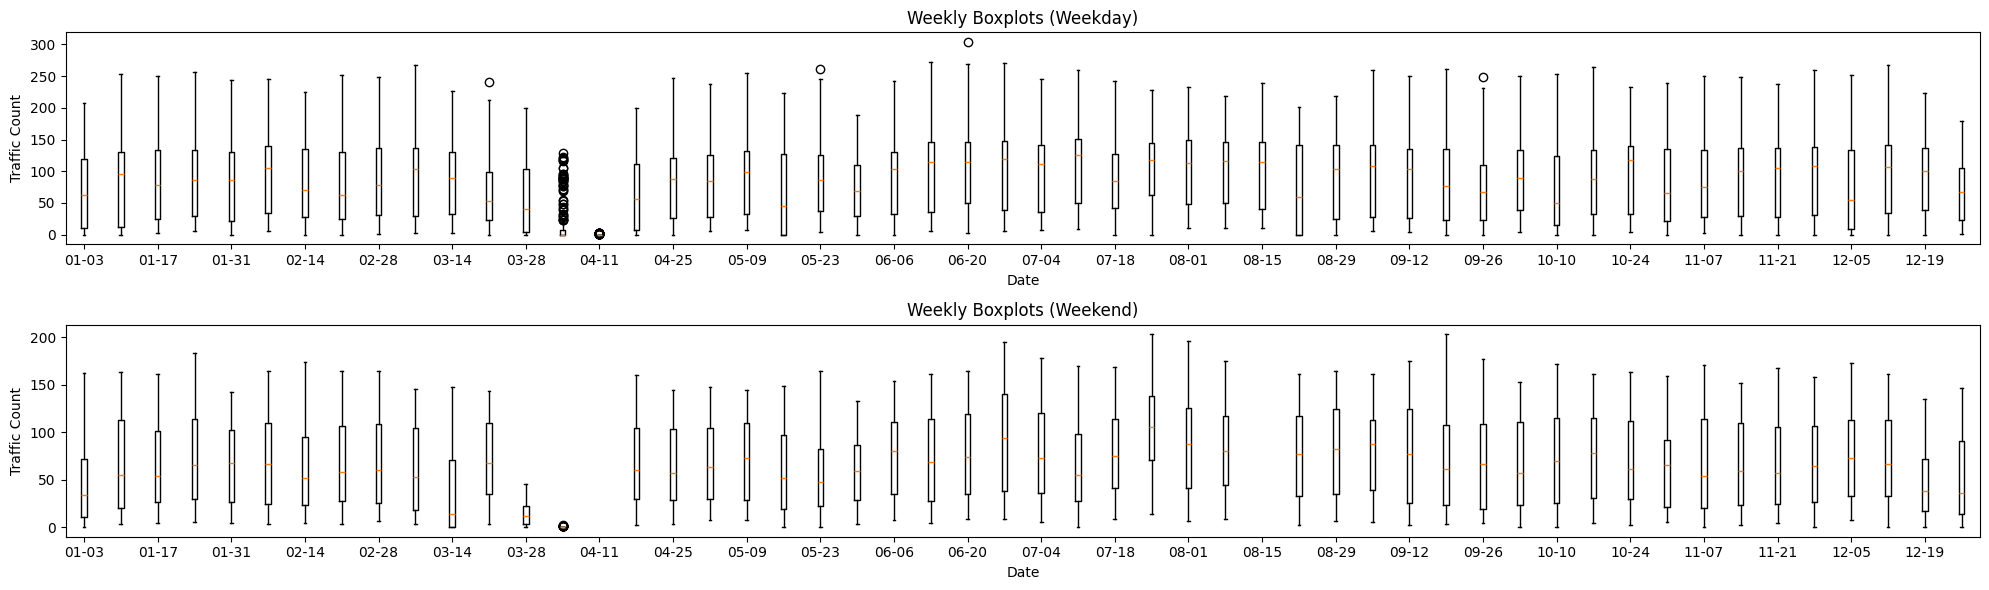

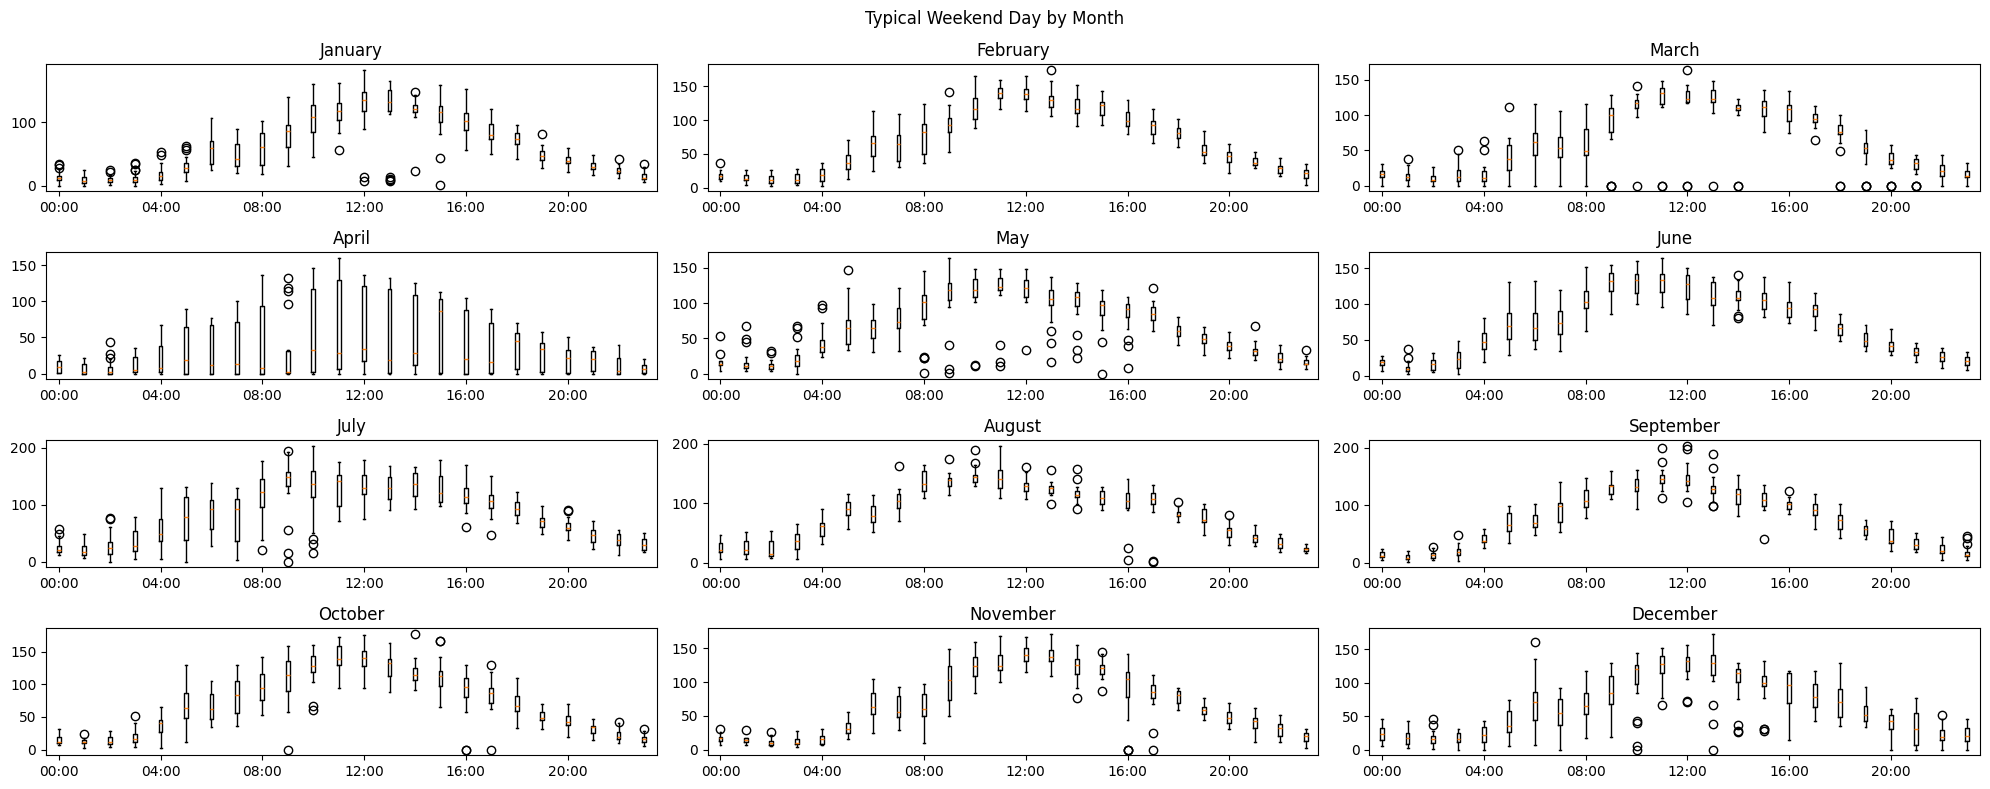

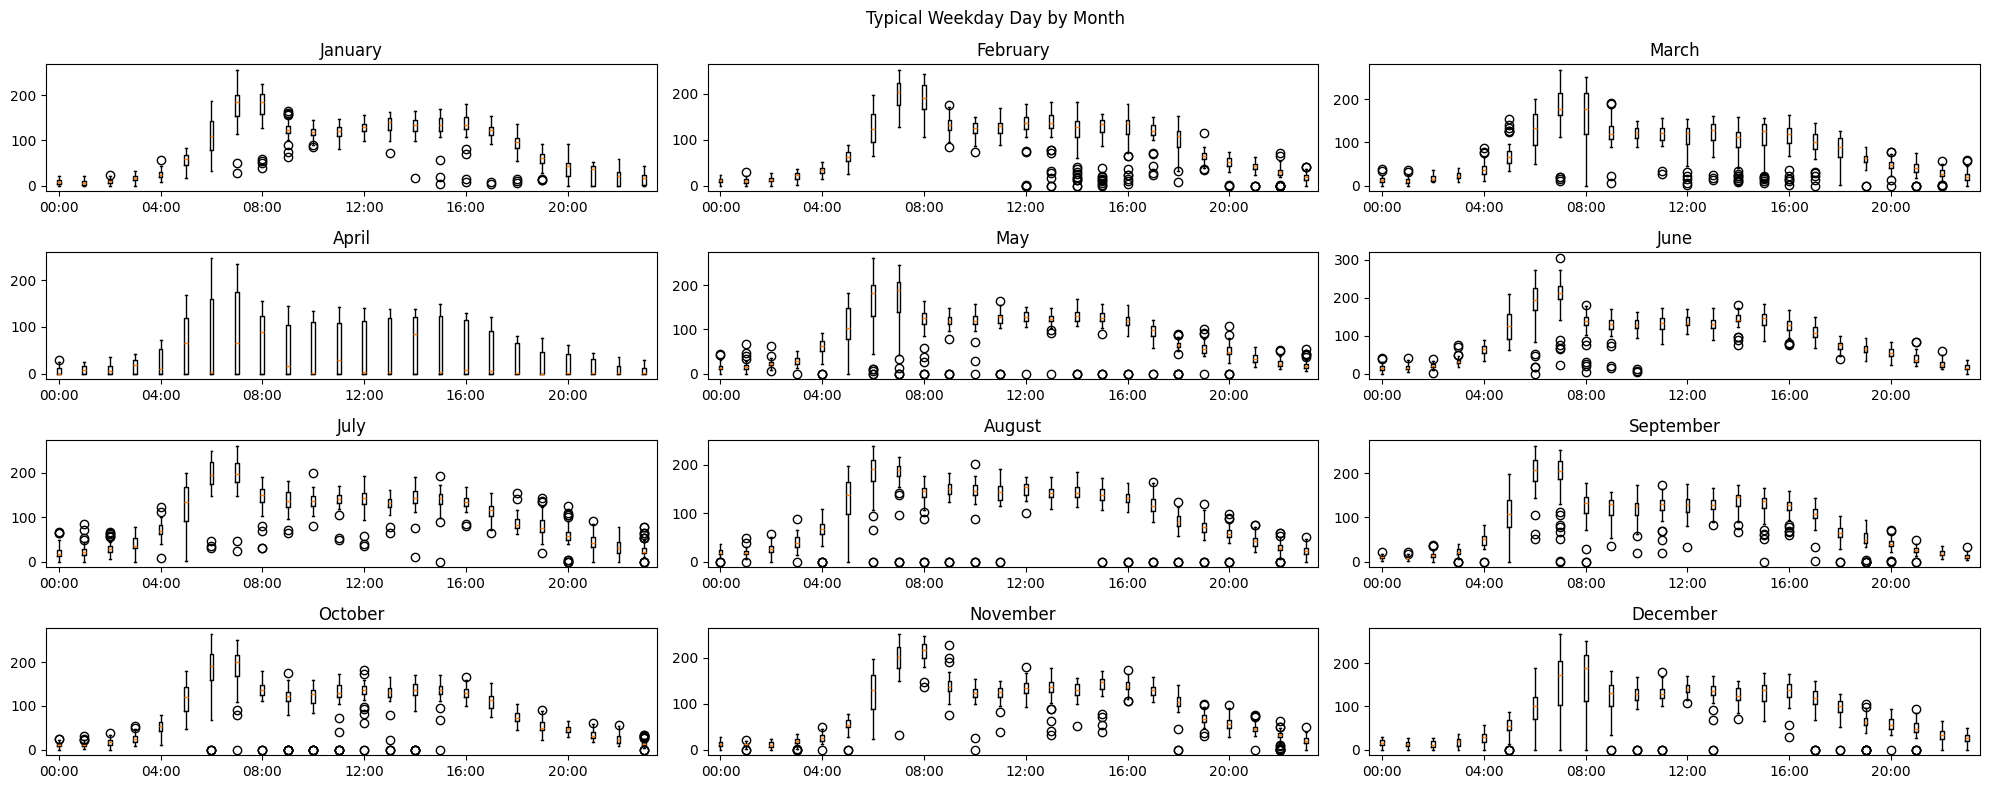

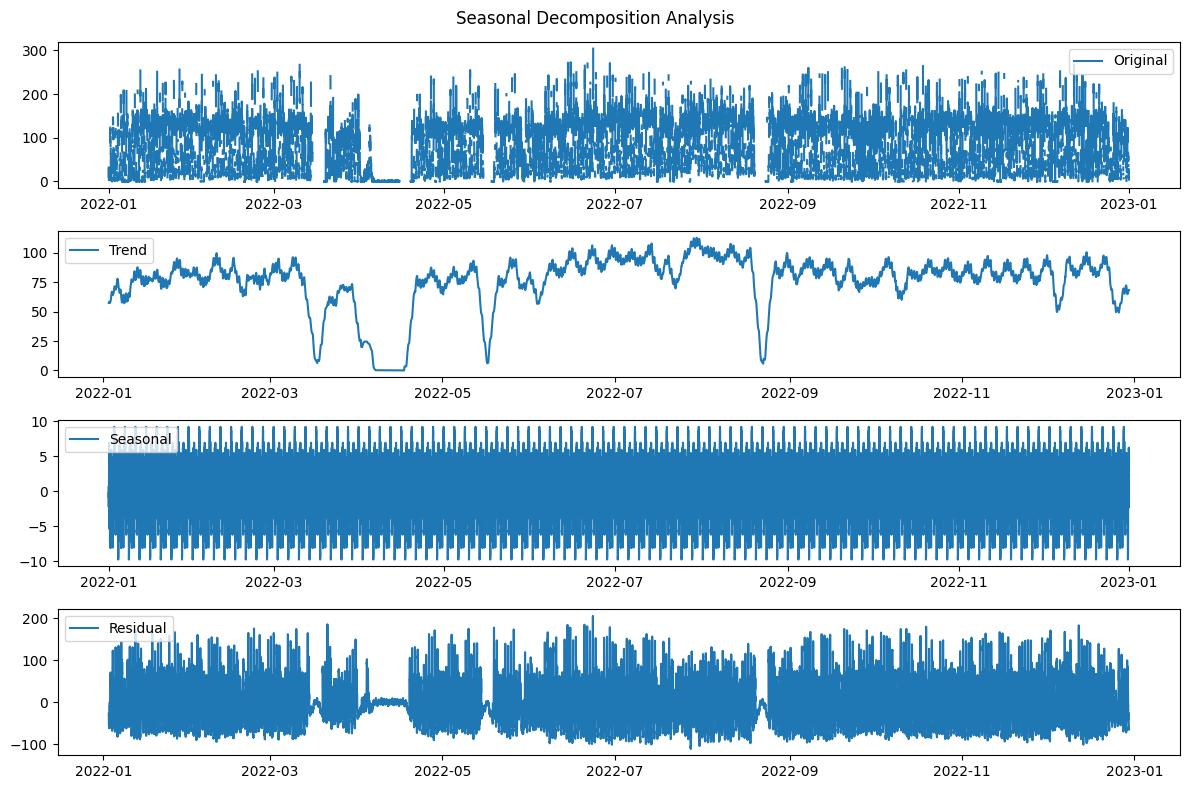

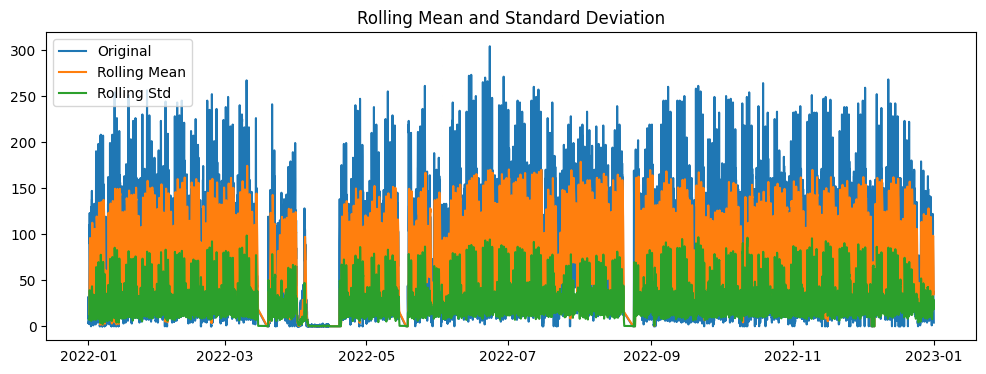

Augmented Dickey-Fuller Test:
Test Statistic: -23.80506814904463
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:355: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:364: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


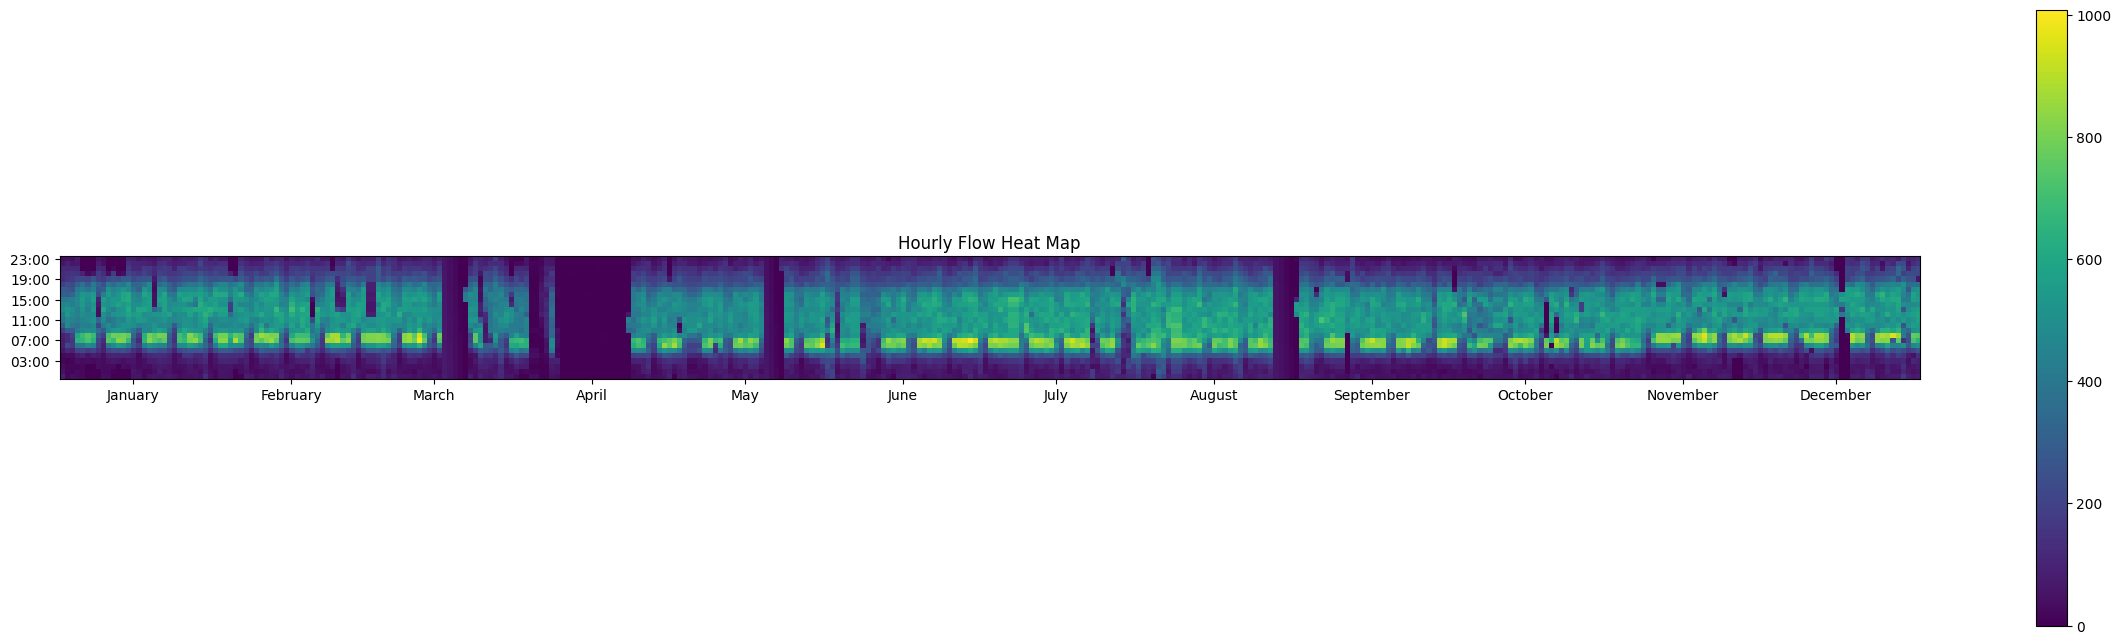

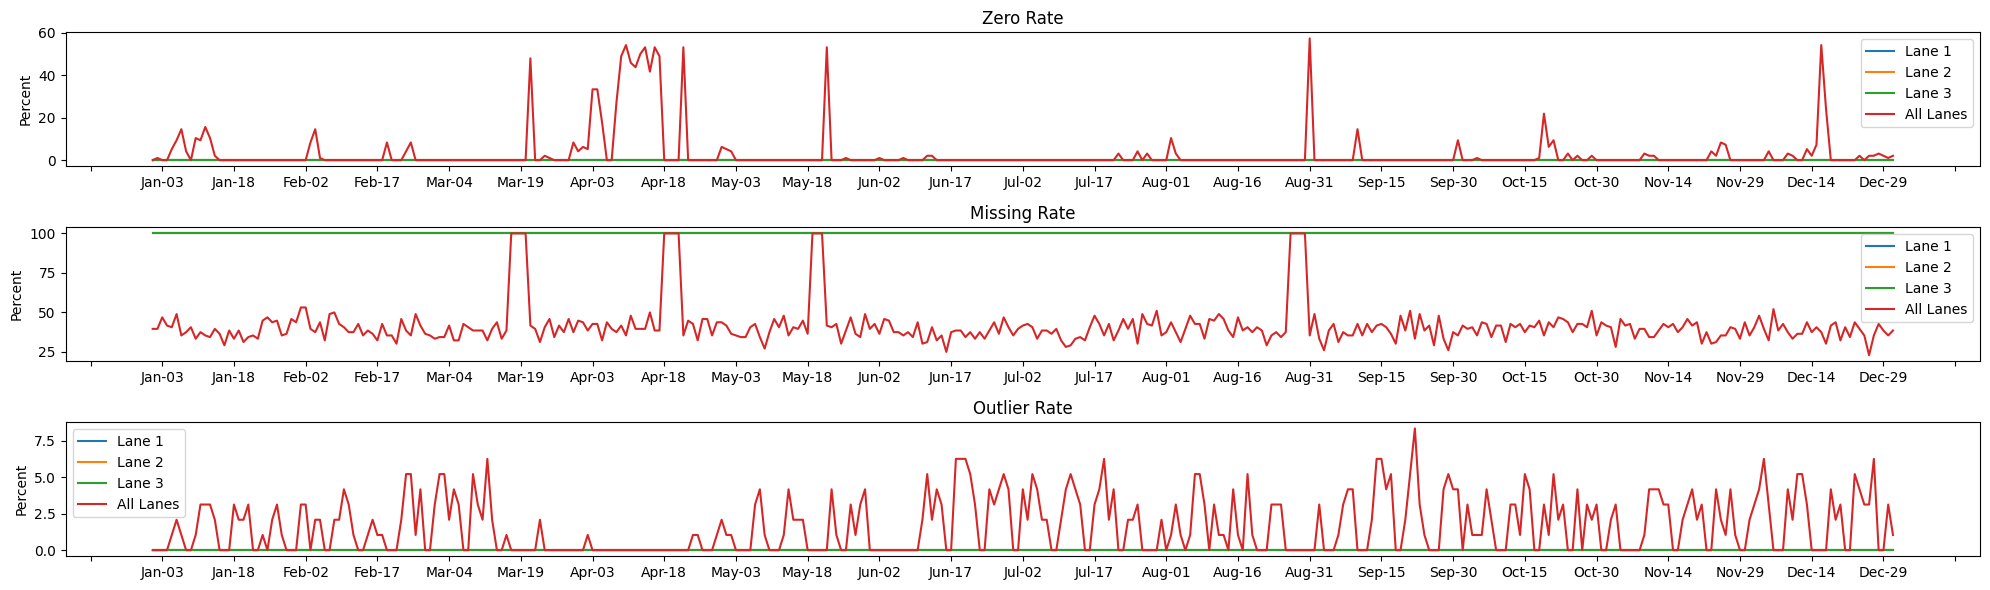

In [330]:
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_level_data[sensor_level_data['Data Quality Check']].index[0],start_date,end_date,cursor)

### Analysis 5.2 - Time Series Analysis of Crucial Sensor (sensor furthest from Dover)

-----------------
Next Columns : Lane 1
Count of zeros : 388
Rate of zeros : 1.1%
Count of nulls : 14477
Rate of nulls : 41.3%
Count of outliers : 538
Rate of outliers : 1.5%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 358
Rate of zeros : 1.0%
Count of nulls : 14523
Rate of nulls : 41.4%
Count of outliers : 21
Rate of outliers : 0.1%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 415
Rate of zeros : 1.2%
Count of nulls : 14565
Rate of nulls : 41.6%
Count of outliers : 58
Rate of outliers : 0.2%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 666
Rate of zeros : 1.9%
Count of nulls : 2289
Rate of nulls : 6.5%
Count of outliers : 1388
Rate of outliers : 4.0%
-----------------




/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:164: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


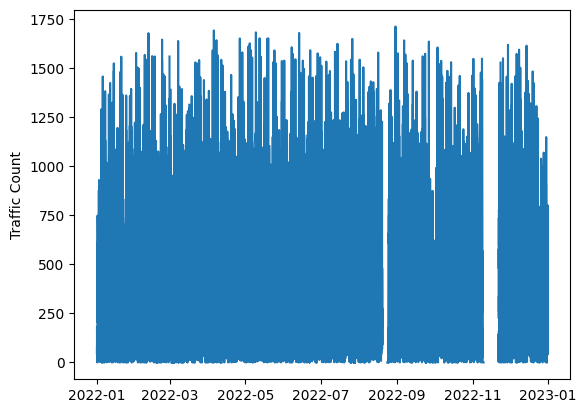

/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:213: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

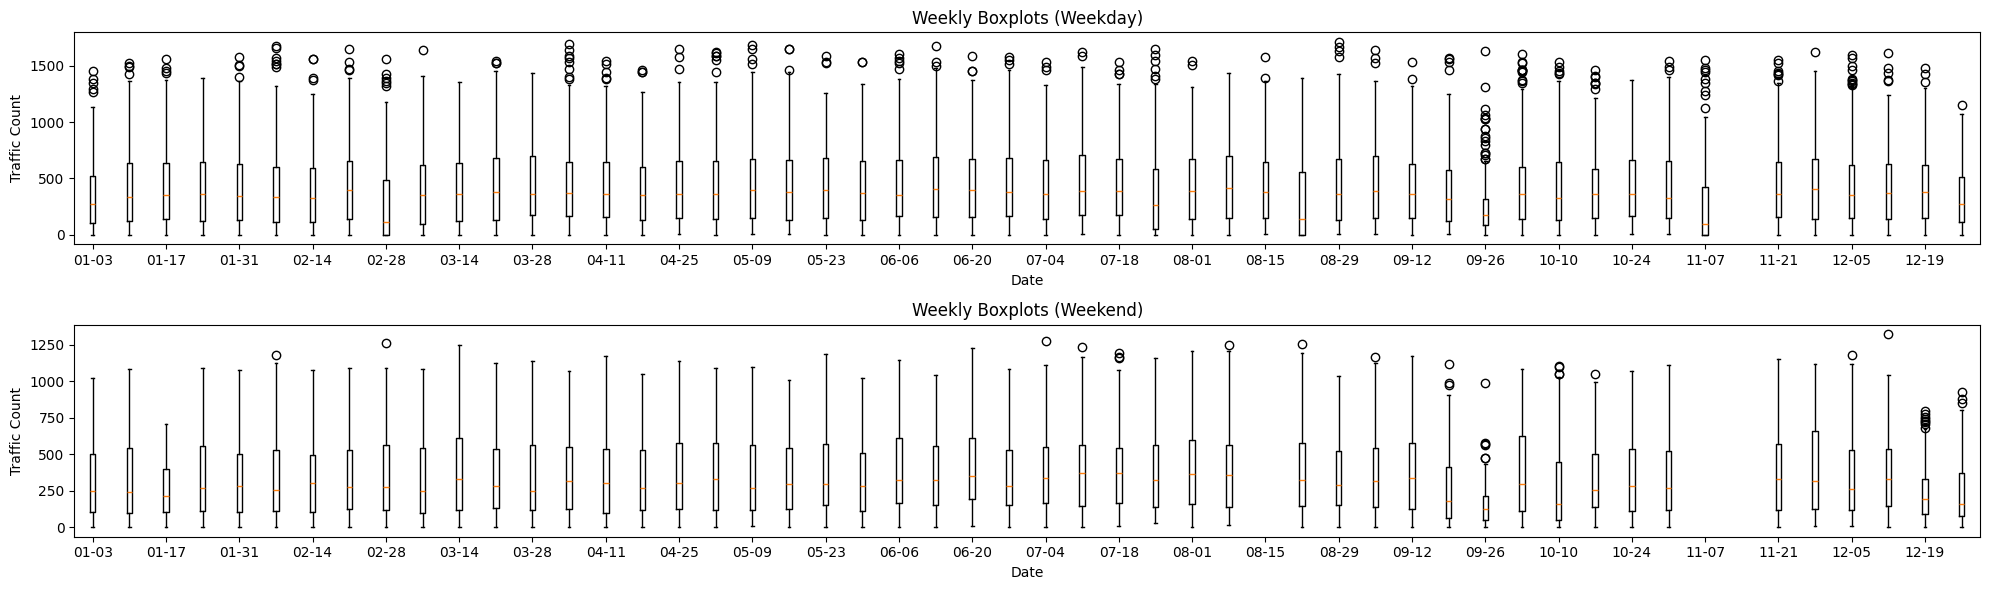

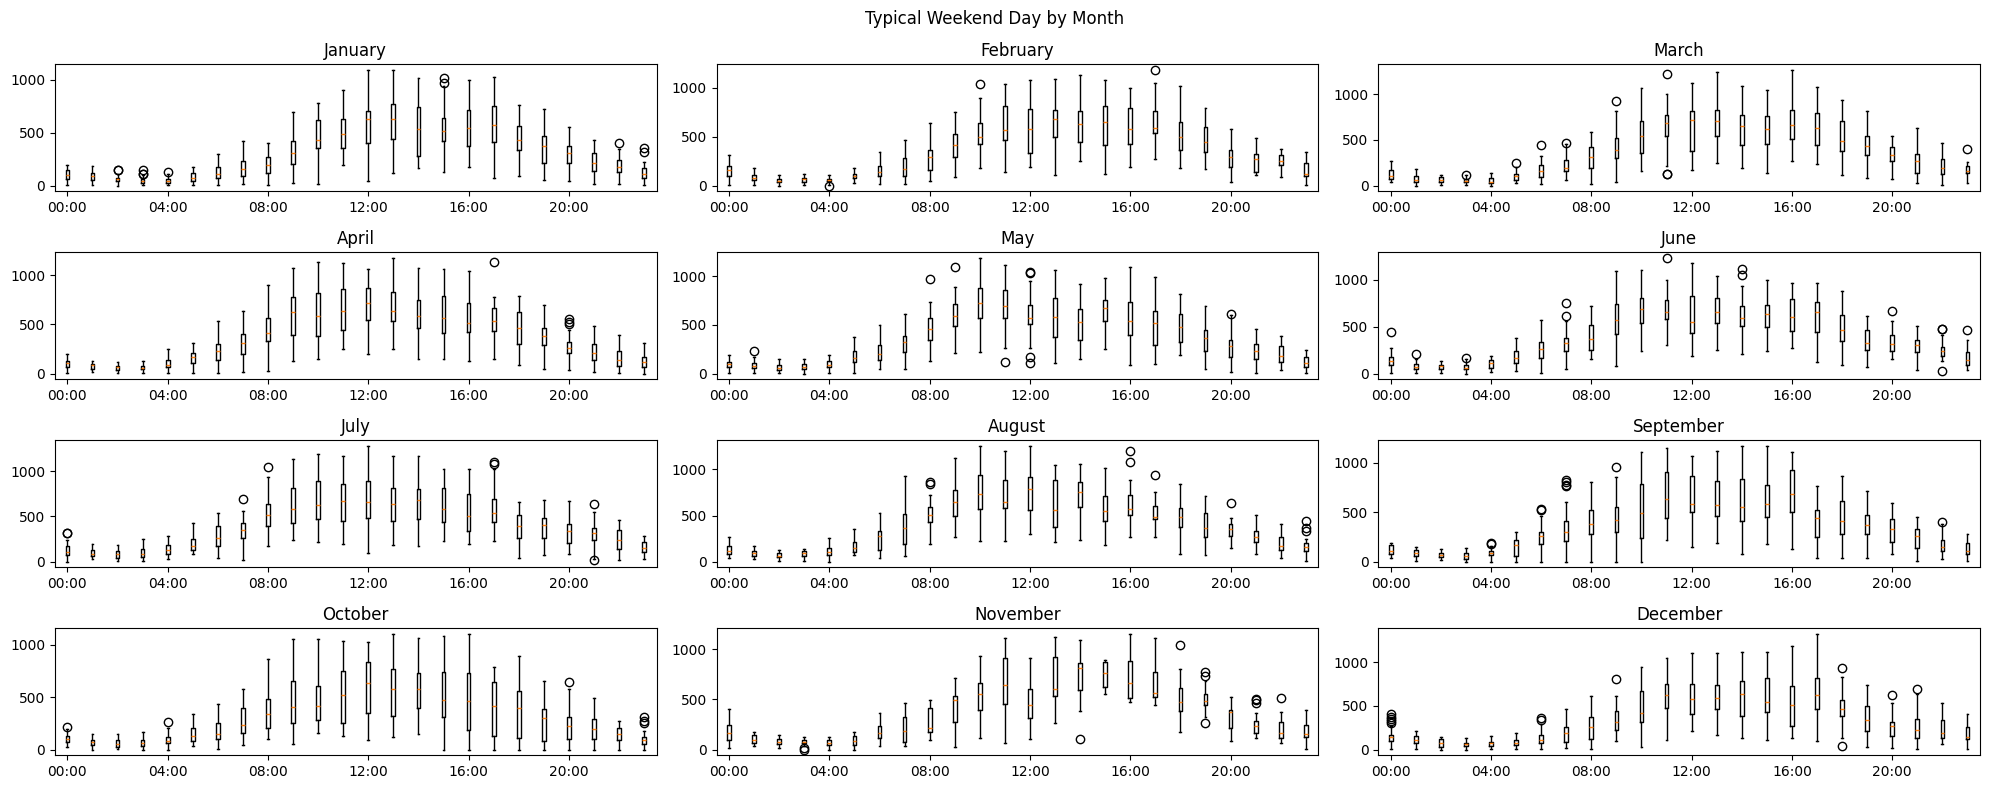

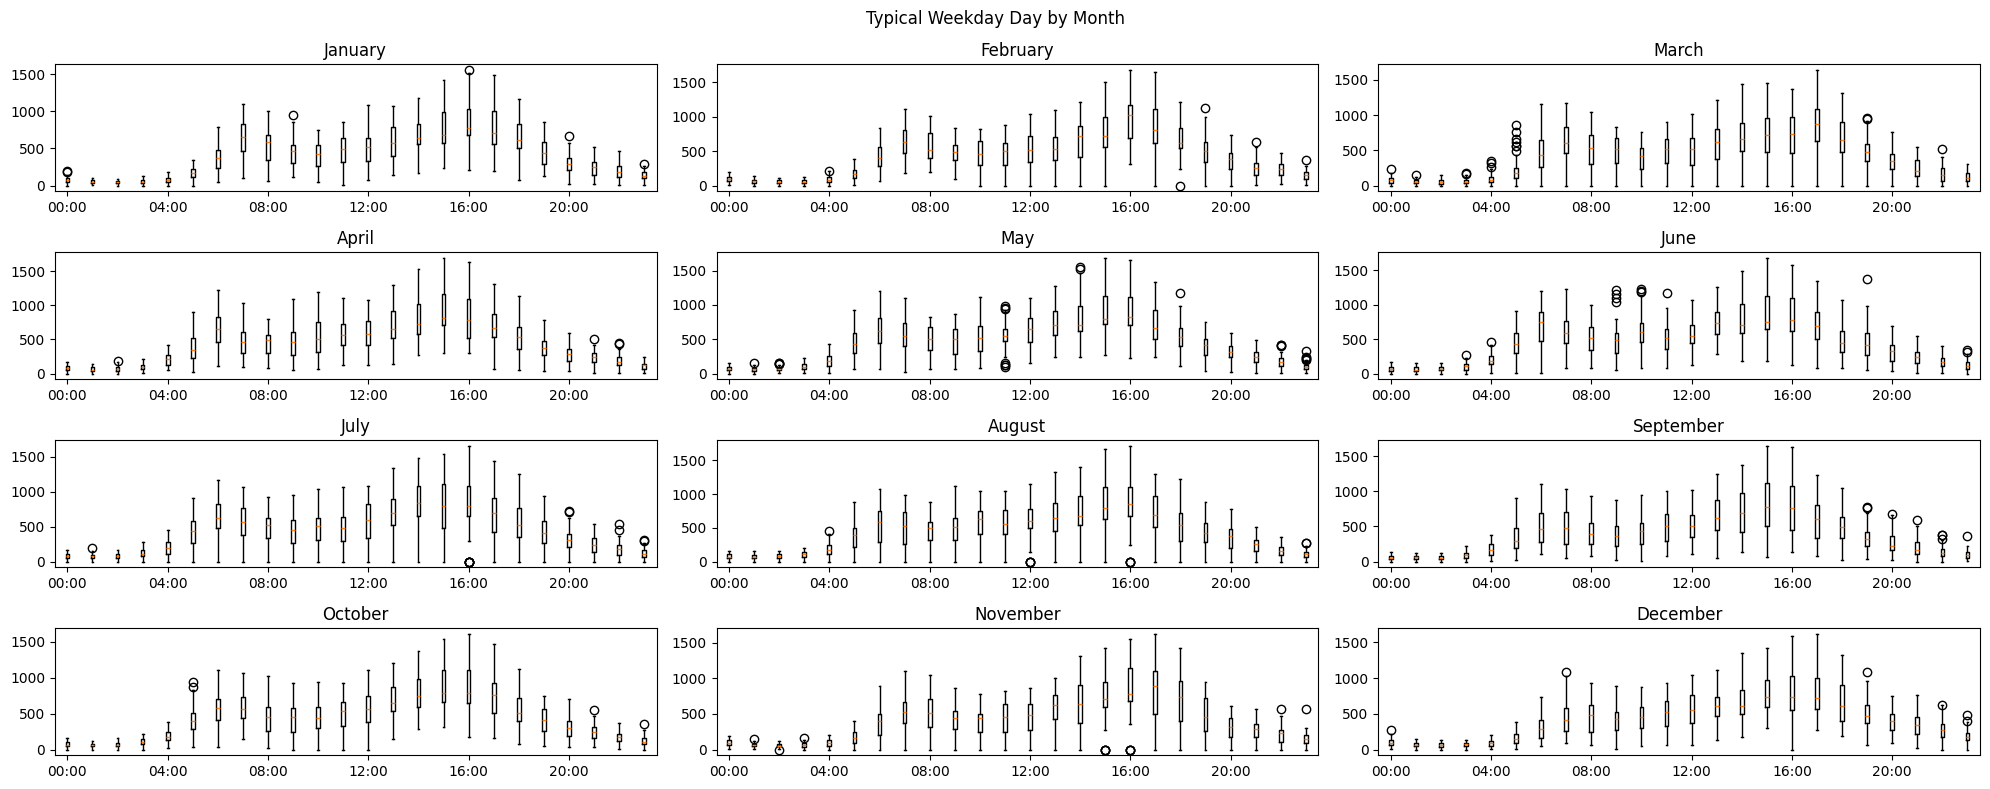

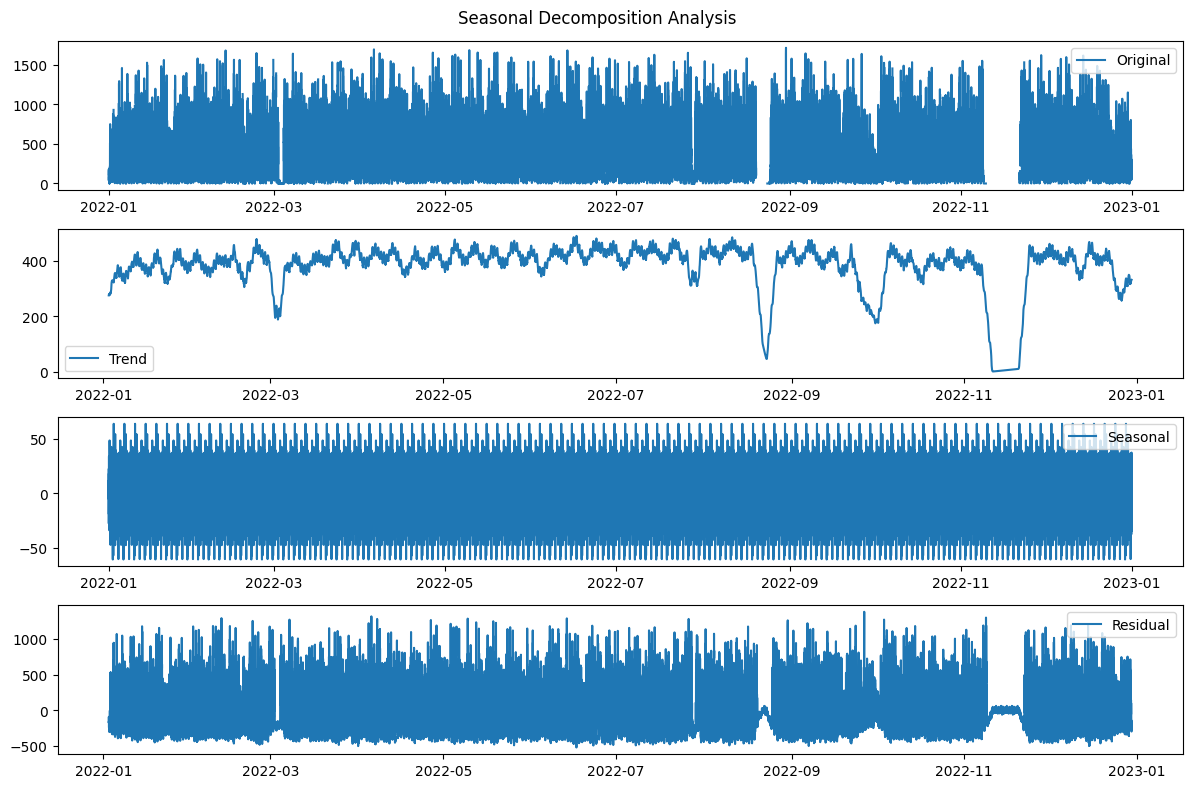

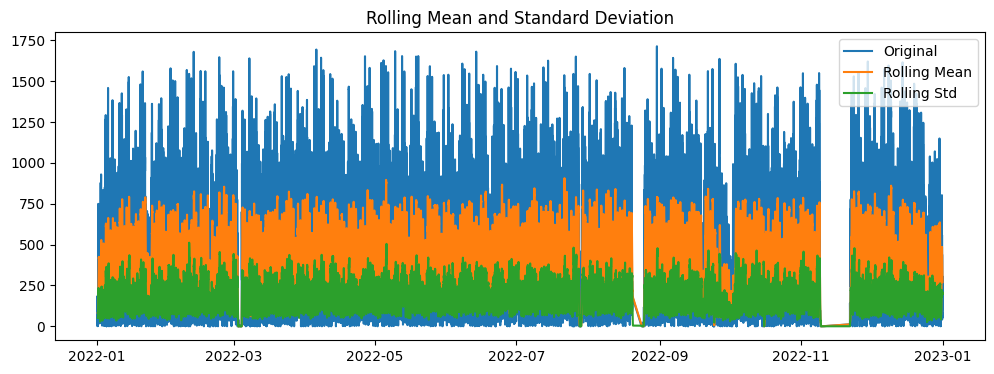

Augmented Dickey-Fuller Test:
Test Statistic: -30.295378265881958
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:355: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/home/chris/projects/Adaptive_Traffic_Simulator/helper_functions.py:364: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


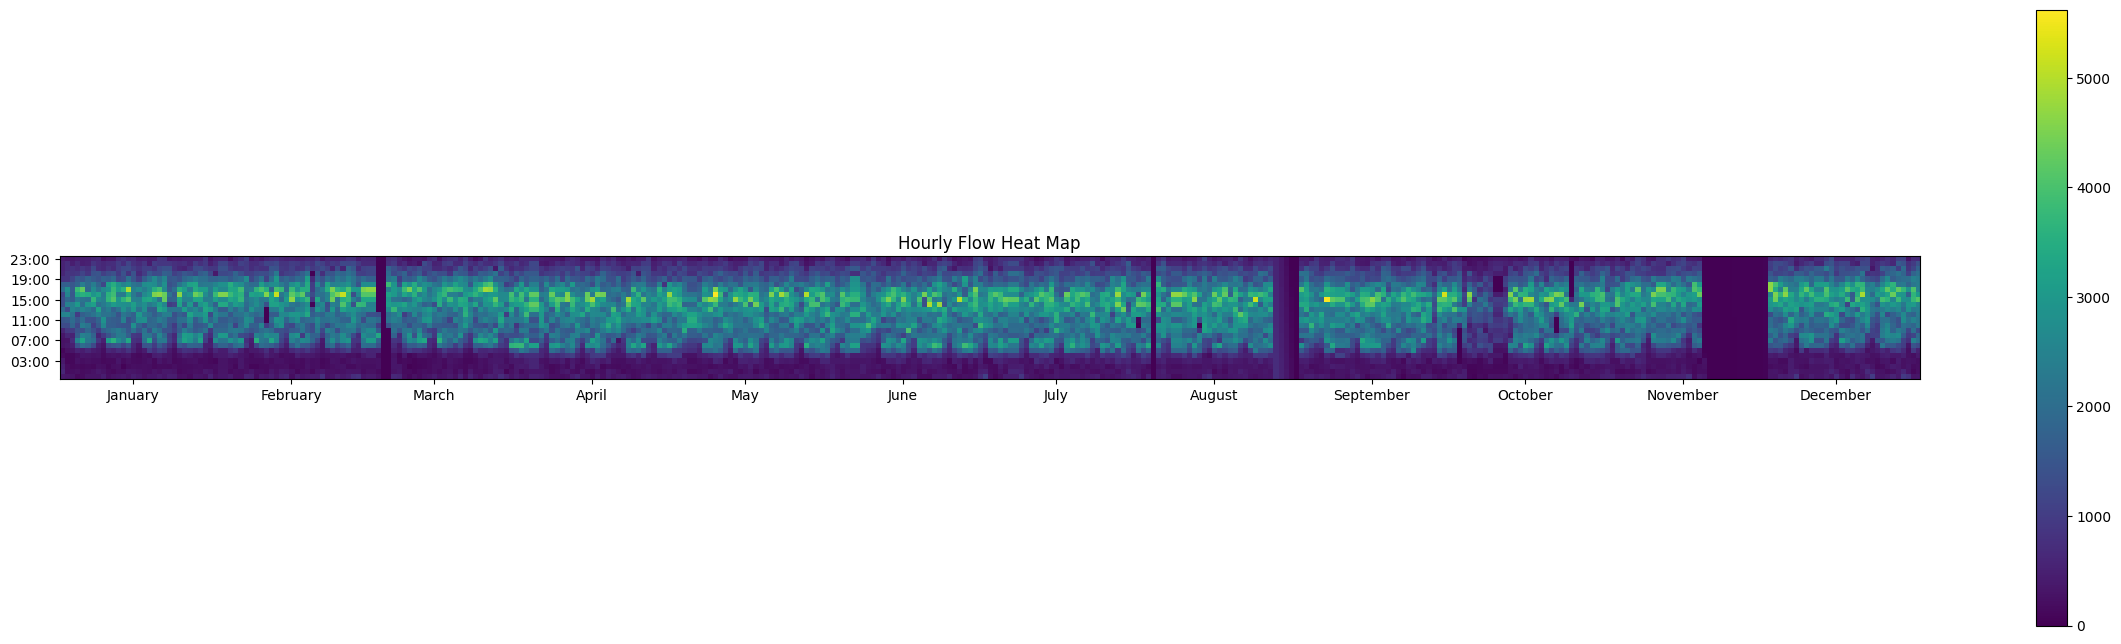

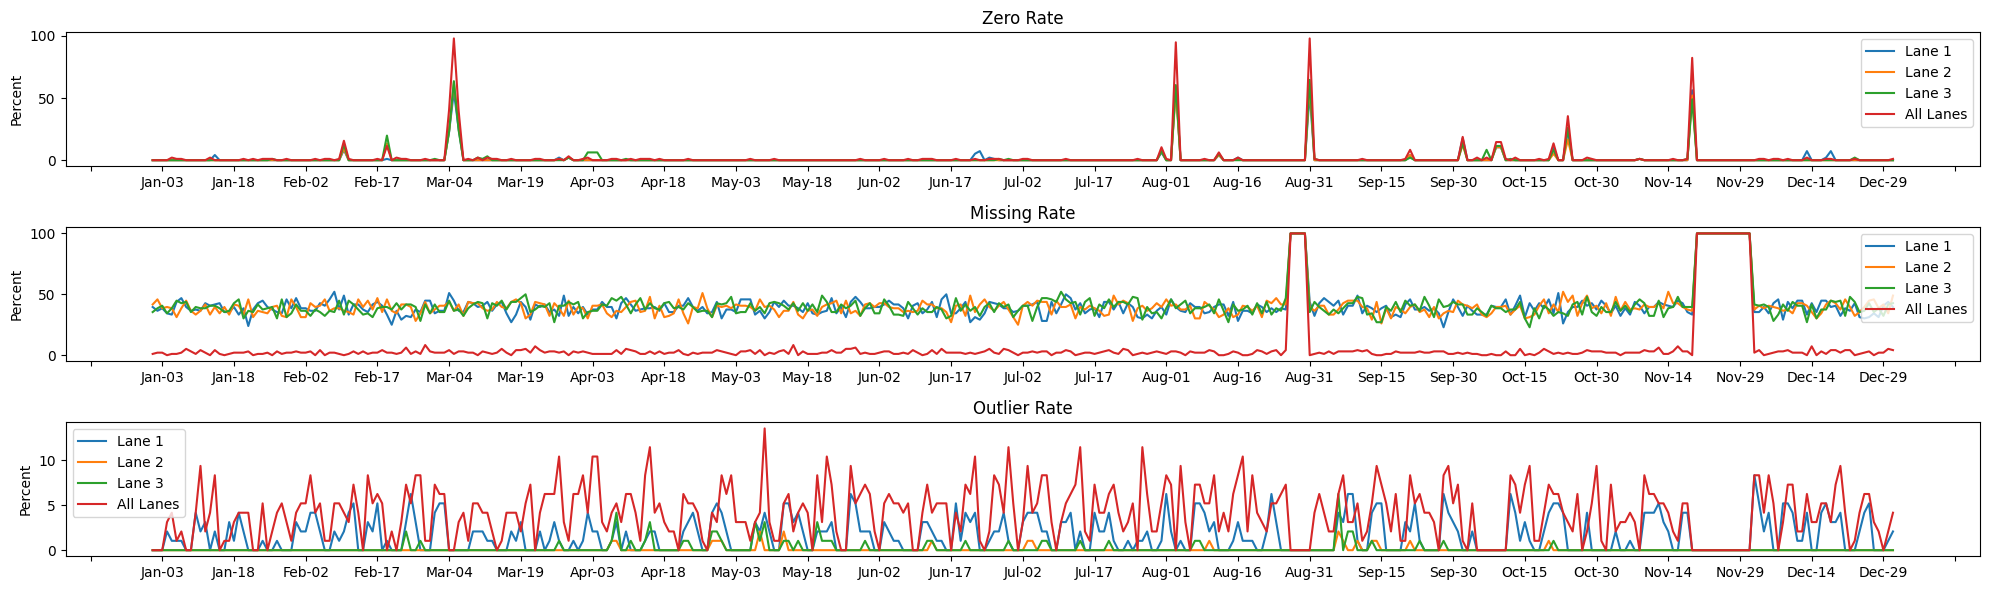

In [331]:
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_level_data[sensor_level_data['Data Quality Check']].index[-1],start_date,end_date,cursor)

## Time Series Exploratory Data Analysis

- Completeness
- Methods for missing data imputation
- Analyse stationarity of data
- Analyse any seasonanality


### Specific To Do:

- For a random sensor:
    - Data quality checks - how are nulls represented? Any processing steps to handle this? How to measure null / missing / outliers
    - What about lanes / vehicle types?
        - Treat separately? Aggregate? Ignore (for now)? Anything else?
    - More detailed time series checks e.g., stationarity etc with analysis & interpretation

### Time Series Analysis

- Missing data
- Summary stats over time. Show summarised boxplots over time.
- Seasonal decomposition
- Auto correlation / partial auto correlation analysis
- Stationarity analysis
- Time-series decomposition
- Heapmaps of data

## GeoSpatial Analysis

### To Consider (ChatGPT):

- Spatial Correlation Analysis (Calculate spatial correlation coefficients, such as Pearson correlation or spatial autocorrelation, between pairs of sensors)
- Geospatial Visualization (Create geospatial visualizations, such as heatmaps or spatial scatter plots, to visually explore patterns and relationships between sensor locations)
- Distance-Based Analysis (Explore the relationship between sensor readings and the physical distance between sensors. Techniques such as variograms or semivariograms can be used to analyze how the spatial correlation changes with distance.)
- Spatial Regression Models (Use spatial regression models to account for spatial dependencies explicitly. Spatial autoregressive models or spatial lag models incorporate spatial relationships into regression analyses, considering the influence of neighboring sensors)
- Cluster Analysis (Apply clustering techniques to group sensors with similar behavior or characteristics. Hierarchical clustering or k-means clustering can help identify spatially cohesive groups of sensors.)
- Network Analysis (Treat the sensors as nodes in a network and analyze the connectivity and flow of information or traffic between them. Network metrics, such as centrality measures, can identify key sensors in the network.)
- Spatial Decomposition (Apply spatial decomposition methods to decompose the spatial variability of sensor data. Principal Component Analysis (PCA) can be extended to consider spatial relationships when analyzing sensor data.)
- Spatial Clustering of Sensors (Use spatial clustering algorithms to group sensors based on their geographical proximity and similarities in observed patterns. This can help identify regions with coherent sensor behavior)
- Geostatistics (Utilize geostatistical methods, such as kriging, to model and predict sensor values while considering the spatial structure and dependencies in the data)
- "Fan out from Dover" - time to reach sensor along with sensor quality


### Notes
Spatial auto correlation (e.g, using moran's I) is challenging with time-series. See this paper for proposed method if it's going to be useful. https://www.tandfonline.com/doi/full/10.1080/10095020.2019.1643609

In [ ]:
#A20-A - Towards Dover
#A20-B - Away from Dover